# Pupil size QA

In [9]:
import os
import re
import pandas as pd
from glob import glob
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import numpy as np

# Add src folder to path to import utility functions
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from utils import downsample_data, interpolate_blink

def detect_and_interpolate_dips(signal, v_thresh=800, max_duration=0.01, fs=100):
    """
    Detect and interpolate dips in a 1D signal based on velocity (first derivative).

    Parameters:
    - signal (np.ndarray): 1D array of pupil data.
    - drop_thresh (float): Threshold for detecting fast decrease (velocity).
    - rise_thresh (float): Threshold for detecting fast increase (velocity).
    - max_duration (float): Max allowed duration between dip start and end (seconds).
    - fs (int): Sampling rate in Hz (default 100Hz).

    Returns:
    - cleaned_signal (np.ndarray): Signal with interpolated dips.
    - dip_mask (np.ndarray): Boolean array marking dip regions.
    """
    t_sample = np.arange(len(signal)) / fs
    dt = 1 / fs
    margin = 5

    # Velocity
    velocity = np.gradient(signal) / dt

    drop_idxs = np.where(velocity < -v_thresh)[0]
    rise_idxs = np.where(velocity > v_thresh)[0]

    dip_mask = np.zeros_like(signal, dtype=bool)
    used = np.zeros_like(signal, dtype=bool)
    max_samples = int(max_duration * fs)

    for drop_idx in drop_idxs:
        if used[drop_idx]:
            continue

        # Look for rise after drop within max duration
        candidates = rise_idxs[(rise_idxs > drop_idx) & (rise_idxs - drop_idx <= max_samples)]
        if len(candidates) == 0:
            continue

        rise_idx = candidates[0]
        start = max(0, drop_idx - margin)
        end = min(len(dip_mask), rise_idx + margin + 1)

        dip_mask[start:end] = True
        used[start:end] = True

    # Interpolate over dip regions
    cleaned_signal = signal.copy()
    valid = ~dip_mask
    if np.sum(valid) > 1:
        interp_func = interp1d(
            t_sample[valid], signal[valid],
            kind='linear', bounds_error=False, fill_value='extrapolate'
        )
        cleaned_signal[dip_mask] = interp_func(t_sample[dip_mask])

    return cleaned_signal, dip_mask


def interpolate_missing(signal, mode='linear', mindur=5, margin=10, invalid=-1):
    
    """Returns signal with interpolated results, based on a cubic or linear
    interpolation of the invalid data in the signal
    
    arguments
    signal	--	a vector (i.e. a NumPy array) containing a single
                trace of your signal
    
    keyword arguments
    mode		--	string indicating what kind of interpolation to use:
                'linear' for a linear interpolation
                'cubic' for a cubic interpolation
                'auto' for a cubic interpolation is possible (i.e.
                    when more than four data points are available)
                    and linear when this is not the case
                (default = 'auto')
    mindur	--	minimal amount of consecutive samples to interpolate
                cubically; otherwise a linear interpolation is used;
                this is to prevent weird results in the interpolation
                of very short strings of missing data (default = 5)
    margin	--	margin (in samples) to compensate for missing duration
                underestimatiom; missing is extended for detected start
                minus margin, and detected end plus margin; this helps
                in reducing errors in blink interpolation that has not
                been done by interpolate_blink (default = 10)
    invalid	--	a single value coding for invalid data, e.g. -1 or 0.0
                (default = -1)
    
    returns
    signal	--	a NumPy array containing the interpolated signal
    """
    
    # # # # #
    # input errors
    
    # wrong interpolation method	
    if mode not in ['auto','linear','cubic']:
        raise Exception("Error in pyenalysis.interpolate_missing: mode '%s' is not supported, please use one of the following: 'auto','linear','cubic'" % mode)
    # wrong signal dimension
    if signal.ndim != 1:
        raise Exception("Error in pyenalysis.interpolate_missing: input is not a single signal trace, but has %d dimensions; please provide a 1-dimension array" % signal.ndim)

    # # # # #
    # find successive strings of missing data
    
    # empty lists for starting and ending indexes
    starts = []
    ends = []
    
    # check if beginning sample is missing, and add to starting indexes if
    # needed (algorithm does not pick up changes before the start or after
    # the end if the signal)
    if signal[0] == invalid:
        starts.append(0)
        si = 1
    else:
        si = 0
    
    # find invalid data
    inval = signal == invalid
    
    # code connected strings of missing data 1
    # (by substracting the previous number from the current, for every
    # missing data index number: this will produce a value of 1 for
    # successive index numbers, and higher values for nonsuccessive ones)
    diff = np.diff(inval)
    
    # find out what the index numbers of changes are
    # (i.e.: every difference that is 1)
    changes = np.where(diff==True)[0]
    
    # loop through changes, finding start and begining index numbers for
    # strings of successive missings
    for i in range(si,len(changes),2):
        ns = changes[i]-margin
        if ns < 0:
            ns = 0
        starts.append(ns)
    for i in range(1-si,len(changes),2):
        ne = changes[i]+1+margin
        if ne >= len(signal):
            ne = len(signal)-1
        ends.append(ne)
    # if the signal ended on an invalid sample, add the ending index number
    if signal[-1] == invalid:
        ends.append(len(signal)-1)
    
    # # # # #
    # interpolate
    
    # correct start and end point if these are invalid, by replacing them
    # with the trial average
    if signal[0] == invalid:
        signal[0] = np.mean(signal[signal != invalid])
    if signal[-1] == invalid:
        signal[-1] = np.mean(signal[signal != invalid])
    

    # loop through all starting and ending positions
    for i in range(len(starts)):
        
        # empty list to store data points for interpolation
        pl = []
        
        # duration in samples
        duration = ends[i]-starts[i]
        
        # starting point
        if starts[i] - duration >= 0 and signal[starts[i]-duration] != invalid:
            pl.extend([starts[i]-duration])
        # central points (data between these points will be replaced)
        pl.extend([starts[i],ends[i]])
        # ending point
        if ends[i] + duration < len(signal) and signal[ends[i]+duration] != invalid:
            pl.extend([ends[i]+duration])
        
        # if the duration is too low, use linear interpolation
        if duration < mindur:
            kind = 'linear'
        # if the duration is long enough, choose interpolation type
        else:
            if mode == 'auto':
                # if our range is wide enough, we can interpolate cubicly
                if len(pl) >= 4:
                    kind = 'cubic'
                # if not, we use a linear interpolation
                else:
                    kind = 'linear'
            else:
                kind = mode[:]
        
        # create interpolation function
        x = np.array(pl)
        y = signal[x]
        intfunc = interp1d(x,y,kind=kind)
        
        # do interpolation
        xint = np.arange(starts[i],ends[i])
        yint = intfunc(xint)
        
        # insert interpolated values into signal
        signal[xint] = yint
        
    return signal

def remove_outliers(signal, maxdev=2.5, invalid=-1, interpolate=True, mode='auto', allowp=0.05):
    """
    Detects and replaces outliers in a 1D signal using standard deviation, and interpolates over them.

    Parameters:
    - signal (np.ndarray): 1D array of signal values (e.g., pupil size).
    - maxdev (float): Max allowed deviation from mean in SD units (default: 2.5).
    - invalid (float): Placeholder value for invalid entries (default: -1).
    - interpolate (bool): Whether to interpolate over invalids (default: True).
    - mode (str): Interpolation mode ('auto', 'linear', or 'cubic').
    - allowp (float): If SD is less than this proportion of mean, skip outlier removal.

    Returns:
    - np.ndarray: Cleaned (and interpolated) signal.
    """
    if signal.ndim != 1:
        raise ValueError("Signal must be 1D.")

    signal = signal.copy()
    mean_val = np.mean(signal)
    std_val = np.std(signal)

    if std_val < allowp * abs(mean_val):
        return signal  # too stable to meaningfully detect outliers

    # Define outlier bounds
    lower_bound = mean_val - maxdev * std_val
    upper_bound = mean_val + maxdev * std_val

    # Mark outliers with invalid placeholder
    outliers = (signal < lower_bound) | (signal > upper_bound)
    signal[outliers] = invalid

    # Interpolate if requested
    if interpolate:
        # signal = interpolate_missing(signal, mode=mode, invalid=invalid)
        
        x = np.arange(len(signal))
        valid = signal != invalid

        if valid.sum() < 2:
            return signal  # not enough valid points to interpolate

        interp_func = interp1d(
            x[valid], signal[valid], kind='linear',
            bounds_error=False, fill_value='extrapolate'
        )
        signal = interp_func(x)
        
    return signal

data_root = r"/Volumes/GBLDrive/MindlessReading/Data"
path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/PupilQA"
file_pattern = 'Sample.csv'
eye = 'R'
# Get all subject directories
subject_folders = [f.path for f in os.scandir(data_root) if f.is_dir()]

# Iterate over each subject
for subject_folder in tqdm(subject_folders, desc="Processing Subjects"):
    
    # Extract subject ID
    match = re.search(r's\d{5}', subject_folder)
    if not match:
        continue
    subject_id = match.group(0)

    # Load the subject's default timing and features file
    timing_file = os.path.join(subject_folder, f"{subject_id}_R_features_default_sr.csv")
    df_timing = pd.read_csv(timing_file)

    # Recursively find all Sample.csv files
    sample_files = glob(os.path.join(subject_folder, '**', f'*{file_pattern}'), recursive=True)

    for sample_file in sample_files:
        df_sample = pd.read_csv(sample_file)
        # get a copy of dataframe
        df_ = df_sample.copy()
        # Get run number from file path
        file_dir = os.path.dirname(sample_file)
        run_match = re.search(r'_r(\d)_', file_dir)
        run_number = int(run_match.group(1))
        
        # Load blink and saccade files
        blink_files = glob(os.path.join(file_dir, '*_Blink.csv'))
        saccade_files = glob(os.path.join(file_dir, '*_Saccade.csv'))
        df_blink = pd.read_csv(blink_files[0])
        df_saccade = pd.read_csv(saccade_files[0])
        # interpolate the pupil size
        df_sample = interpolate_blink(df_sample, df_blink, df_saccade)

        # downsample both df
        df_ = downsample_data(df_)
        df_sample = downsample_data(df_sample)
        
        # # Detect outliers using IQR rule
        # # ==========================================================================================
        # # Define the pupil column
        # pupil_col = f"{eye}Pupil"
        # pupil_values = df_sample[pupil_col].copy()

        # # Compute IQR and outlier bounds
        # Q1 = pupil_values.quantile(0.25)
        # Q3 = pupil_values.quantile(0.75)
        # IQR = Q3 - Q1
        # lower_bound = Q1 - 1.5 * IQR
        # upper_bound = Q3 + 1.5 * IQR

        # # Identify outliers
        # is_outlier = (pupil_values < lower_bound) | (pupil_values > upper_bound)

        # # Set outliers to NaN
        # df_sample.loc[is_outlier, pupil_col] = np.nan

        # # Use interp1d for interpolation over non-NaN values
        # valid = ~df_sample[pupil_col].isna()
        # if valid.sum() > 1:
        #     interp_func = interp1d(
        #         df_sample.loc[valid, 'tSample'], 
        #         df_sample.loc[valid, pupil_col], 
        #         kind='linear', 
        #         bounds_error=False, 
        #         fill_value='extrapolate'
        #     )
        #     df_sample[pupil_col] = interp_func(df_sample['tSample'])
        # # ==========================================================================================

        # https://github.com/esdalmaijer/PyGazeAnalyser/blob/de44913fb60876134c5b942690d586e5dab40476/pygazeanalyser/traces.py#L371
        
        pupil_array = df_sample[f'{eye}Pupil'].to_numpy()
        dip_remove, dip_mask = detect_and_interpolate_dips(pupil_array)
        cleaned_signal = remove_outliers(dip_remove, maxdev=2.5, interpolate=True, mode='auto')
        df_sample[f'c_{eye}Pupil'] = cleaned_signal

        # Convert time to seconds and zero-baseline it
        baseline_time = df_sample.loc[0, "tSample"] / 1000
        time_series = df_sample["tSample"]/1000 - baseline_time

        # Extract timing info for this run
        df_run_timing = df_timing[df_timing['run'] == run_number].copy()
        for col in ["page_start", "page_end", "mw_onset", "mw_offset"]:
            df_run_timing[col] = df_run_timing[col] - baseline_time

        # Determine cutoff time: 5 seconds after the last page_end
        cutoff_time = df_run_timing['page_end'].max() + 5

        # Crop time series and pupil data to cutoff
        crop_mask = (time_series <= cutoff_time)
        dip_mask = dip_mask[crop_mask]
        time_series = time_series[crop_mask]
        df_sample = df_sample.loc[crop_mask].copy()
        df_ = df_.loc[crop_mask].copy()

        # Plot raw and interpolated pupil signals
        plt.figure(figsize=(20, 8))
        # plt.plot(time_series, df_[f'{eye}Pupil'], label=f'Original {eye}Pupil', alpha=0.6)
        # plt.plot(time_series, df_sample[f'{eye}Pupil'], label=f'Interpolated {eye}Pupil', alpha=0.8)
        # plt.plot(time_series, df_sample[f'c_{eye}Pupil'], '--', label=f'Cleaned {eye}Pupil')

        plt.plot(
            time_series, 
            df_[f'{eye}Pupil'], 
            color='gray', 
            linestyle='-', 
            linewidth=1.0, 
            alpha=0.4, 
            label=f'Original {eye}Pupil'
        )

        plt.plot(
            time_series, 
            df_sample[f'{eye}Pupil'], 
            color='tab:blue', 
            linestyle='-', 
            linewidth=2.0, 
            alpha=0.9, 
            label=f'Interpolated {eye}Pupil'
        )
        plt.plot(
            time_series, 
            df_sample[f'c_{eye}Pupil'], 
            color='tab:orange', 
            linestyle='--', 
            linewidth=2.5, 
            alpha=1.0, 
            label=f'Cleaned {eye}Pupil'
        )

        plt.plot(
            time_series[dip_mask],
            df_sample[f'{eye}Pupil'][dip_mask],
            'ro',  # red dots
            markersize=2,
            label='Detected Dip'
        )

        # Plot vertical lines for page and MW event timings
        for _, row in df_run_timing.iterrows():
            plt.axvline(row['page_start'], color='black', linestyle='--', alpha=0.8, label='Page Start')
            plt.axvline(row['page_end'], color='grey', linestyle='--', label='Page End')
            plt.axvline(row['mw_onset'], color='tab:red', linestyle='-', alpha=0.8, label='MW Onset')
            plt.axvline(row['mw_offset'], color='tab:green', linestyle='-', alpha=0.8, label='MW Offset')

        # De-duplicate legend entries
        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        plt.legend(unique.values(), unique.keys())
        plt.title(f'{subject_id}, Run {run_number}')
        plt.xlabel('Time (s)')
        plt.ylabel('Pupil Size')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_save, f"{subject_id}_r{run_number}_eye{eye}.png"))
        plt.close()

        # if subject_id == 's10014' and run_number == 2:
        #     plt.xlim(110, 140)
        #     plt.show()
        # else:
        #     plt.close()

Processing Subjects: 100%|██████████| 48/48 [11:21<00:00, 14.21s/it]


# Brightness analysis
Investigates whether screen brightness (top, middle, bottom) affects pupil size during reading.

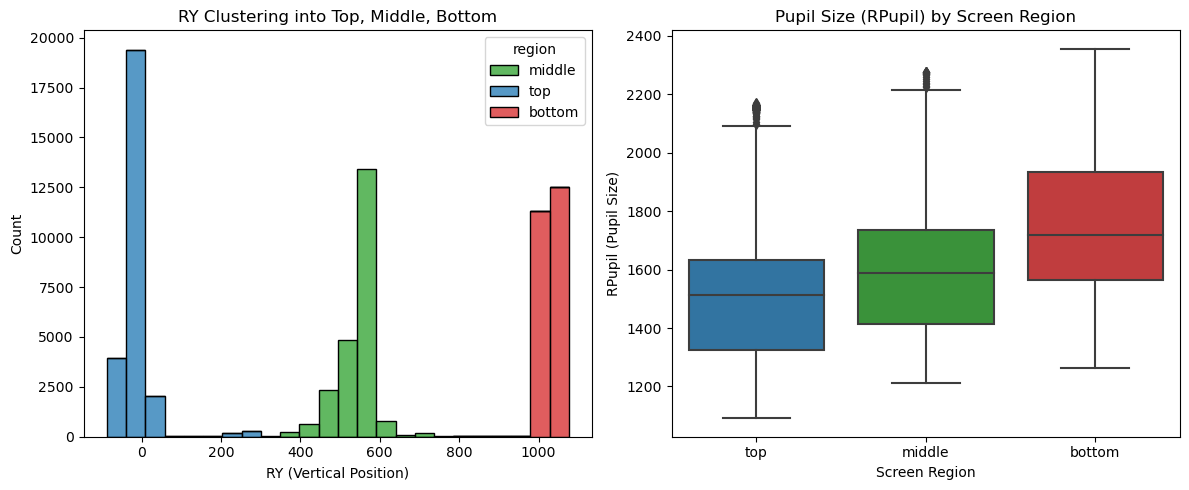

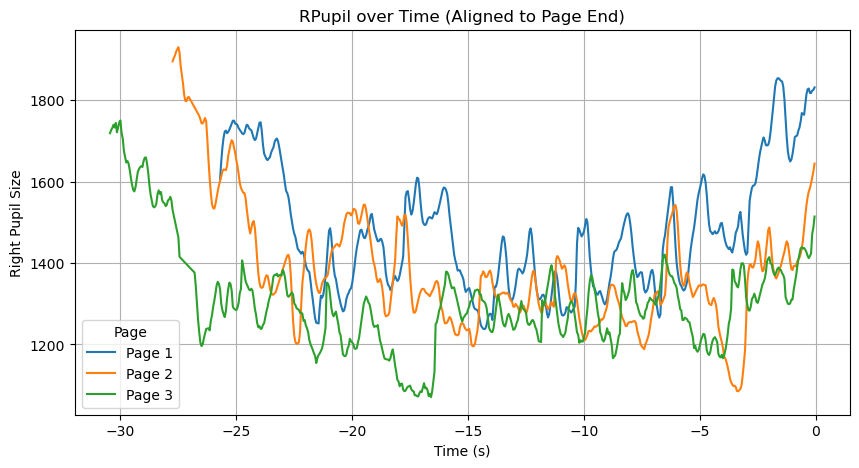

In [ ]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.cluster import KMeans


# ============================================================================
# Add project root to the path so "src" can be found to load page objects
project_root = "/Users/hsun11/Documents/GlassBrainLab/MindlessReading/GitHub/MindlessReadingAnalysis/EyeAnalysisCode" 
sys.path.append(project_root)
# ============================================================================

# define root path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Archive/brightnesstest/page"
# read the page object
page_file_path = os.path.join(path, 'r2_pages')
with open(page_file_path, "rb") as f:
    pages = pickle.load(f)  # Assuming each file contains a list of pages

# ============================================================================
# 1st task: looking at top, middle, and bottom of the screen
df = pd.DataFrame()
page_ = pages[:3]
for page in page_:
    dfSample = page.dfSamples.copy()

    # Cluster RY into 3 regions using KMeans
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(dfSample[['RY']])

    # Assign clusters to the DataFrame
    dfSample['cluster'] = clusters

    # Sort cluster labels by mean RY to consistently map to 'top', 'middle', 'bottom'
    cluster_order = dfSample.groupby('cluster')['RY'].mean().sort_values().index
    cluster_mapping = {cluster_order[0]: 'top', cluster_order[1]: 'middle', cluster_order[2]: 'bottom'}
    dfSample['region'] = dfSample['cluster'].map(cluster_mapping)

    df = pd.concat([df, dfSample], ignore_index=True)


# Visualize
# Define consistent color palette
region_palette = {'top': '#1f77b4', 'middle': '#2ca02c', 'bottom': '#d62728'}  # blue, green, red

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: RY histogram with clusters
sns.histplot(df, x='RY', hue='region', multiple='stack', ax=axes[0], palette=region_palette)
axes[0].set_title("RY Clustering into Top, Middle, Bottom")
axes[0].set_xlabel("RY (Vertical Position)")
axes[0].set_ylabel("Count")

# Right plot: RPupil distribution by region
sns.boxplot(data=df, x='region', y='RPupil', order=['top', 'middle', 'bottom'], palette=region_palette, ax=axes[1])
axes[1].set_title("Pupil Size (RPupil) by Screen Region")
axes[1].set_xlabel("Screen Region")
axes[1].set_ylabel("RPupil (Pupil Size)")

plt.tight_layout()
plt.show()


# ============================================================================
# 2nd task: pupil size change when just reading half the page
# df = pd.DataFrame()
# page_ = pages[4:7]
# for page in page_:
#     dfSample = page.dfSamples.copy()
#     max_t = dfSample['tSample'].max()
#     dfSample['tSample'] = (dfSample['tSample'] - max_t)/1000
#     df = pd.concat([df, dfSample], ignore_index=True)

# plt.figure()
# sns.lineplot(df, x='tSample', y='RPupil')

aligned_dfs = []
page_ = pages[4:7]

# Step 1: Determine global time range
min_t, max_t = 0, 0
for page in page_:
    t = page.dfSamples['tSample']
    max_t = max(max_t, t.max())
    min_t = min(min_t, t.min())

# Step 2: Create common time axis (in seconds)
common_t = np.arange(min_t - max_t, 0.001, 0.05)  # every 50ms

# Step 3: Align each page's data
for i, page in enumerate(page_):
    dfSample = page.dfSamples.copy()
    max_t = dfSample['tSample'].max()
    dfSample['tSample'] = (dfSample['tSample'] - max_t) / 1000  # convert to seconds
    dfSample = dfSample.iloc[::50].reset_index(drop=True)
    # Remove duplicate time entries by averaging
    dfSample = dfSample.groupby('tSample', as_index=False)['RPupil'].mean()

    # Interpolate onto the common time grid
    interp_func = np.interp(
        common_t,
        dfSample['tSample'],
        dfSample['RPupil'],
        left=np.nan,
        right=np.nan
    )

    interpolated = pd.DataFrame({
        'tSample': common_t,
        'RPupil': interp_func,
        'Page': f'Page {i+1}'
    })
    aligned_dfs.append(interpolated)

# Step 4: Combine and plot
df_all = pd.concat(aligned_dfs, ignore_index=True)

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_all, x='tSample', y='RPupil', hue='Page')
plt.title("RPupil over Time (Aligned to Page End)")
plt.xlabel("Time (s)")
plt.ylabel("Right Pupil Size")
plt.grid(True)
plt.show()


# Interblink interval

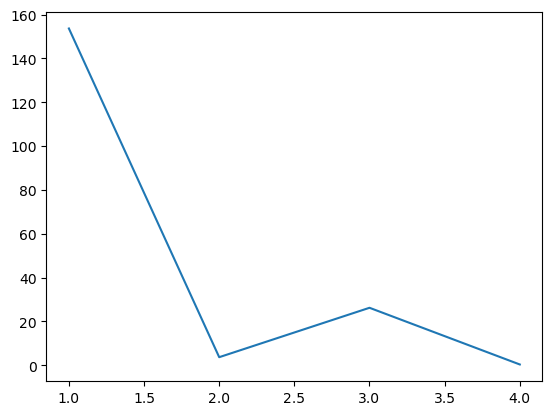

In [ ]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.cluster import KMeans


# ============================================================================
# Add project root to the path so "src" can be found to load page objects
project_root = "/Users/hsun11/Documents/GlassBrainLab/MindlessReading/GitHub/MindlessReadingAnalysis/EyeAnalysisCode" 
sys.path.append(project_root)
# ============================================================================

# define root path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Archive/brightnesstest/page"
# read the page object
page_file_path = os.path.join(path, 'r2_pages')
with open(page_file_path, "rb") as f:
    pages = pickle.load(f)  # Assuming each file contains a list of pages


df = pd.DataFrame()
page_ = pages[:3] + pages[4:7]
for page in page_:
    dfBlink = page.dfBlink.copy()
    dfBlink = dfBlink[dfBlink['eye']=='R']
    dfBlink['time'] = (dfBlink['tStart'] + dfBlink['tEnd']) / 2
    df = pd.concat([df, dfBlink[['time']]], ignore_index=True)

# Sort and compute IBI
df = df.sort_values('time').reset_index(drop=True)
df['IBI'] = df['time'].diff() / 1000  # convert ms to s
df = df.dropna(subset=['IBI'])

# Interpolate to 4 Hz (every 250 ms)
fs = 4
step_ms = 1000 / fs  # 250 ms
new_times = np.arange(df['time'].min(), df['time'].max(), step=step_ms)

ibi_interp = np.interp(new_times, df['time'], df['IBI'])

df_interp = pd.DataFrame({
    'time': new_times,
    'IBI': ibi_interp
})

plt.figure()
plt.plot(df['IBI'])

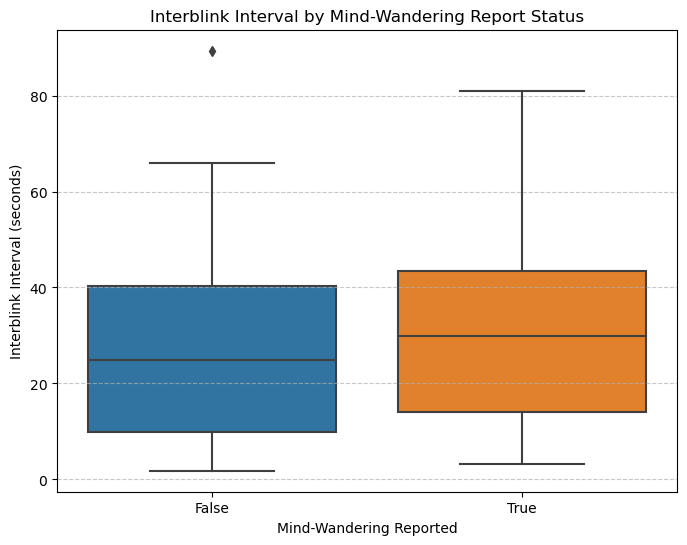

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV file
file_path = r"/Volumes/GBLDrive/MindlessReading/Data/s10014/s10014_R_features_mw_fixed_sr.csv"
df = pd.read_csv(file_path)

# Plot the box plot for interblink interval with MW report status as hue
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_MWreported', y='interblink_interval')
plt.title('Interblink Interval by Mind-Wandering Report Status')
plt.xlabel('Mind-Wandering Reported')
plt.ylabel('Interblink Interval (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Generate discrete eye features around events

In [ ]:
import os
import re
import sys
import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

# ============================================================================
# Add project root to the path so "src" can be found to load page objects
project_root = "/Users/hsun11/Documents/GlassBrainLab/MindlessReading/GitHub/MindlessReadingAnalysis/EyeAnalysisCode" 
sys.path.append(project_root)
# ============================================================================

# define root path
path = r"/Volumes/GBLDrive/MindlessReading/Data"

# load event label file
file_path = os.path.join(path, 'group_event_label.csv')
df_event = pd.read_csv(file_path)

dfFix = pd.DataFrame()
dfSacc = pd.DataFrame()
dfBlink = pd.DataFrame()
dfSamples = pd.DataFrame()

# get all subject folders in the root path
subject_folders = glob.glob(f'{path}/s[0-9]*')
# Define the directory where page objects are stored
for sub_folder in tqdm(subject_folders, desc="Processing subjects"):
    # extract subject ID
    sub_id = re.findall(r's\d+', sub_folder)[0]

    dir_page = os.path.join(sub_folder, "page")
    # List to store all loaded/generated pages
    all_pages = []

    # Get all matching pickle files
    for file in os.listdir(dir_page):
        # Ensure we are matching only valid filenames
        if not re.match(r"r[1-5]_pages$", file):  # Apply regex to `file`, NOT `file_path`
            continue
        file_path = os.path.join(dir_page, file)  # Construct full file path

        with open(file_path, "rb") as f:
            pages = pickle.load(f)  # Assuming each file contains a list of pages
        all_pages += pages


    for page in all_pages:
        
        row = df_event[(df_event['sub_id']==sub_id) & (df_event['page']==page.page_number) &   (df_event['run']==page.run_number)]

        if len(row) == 0:
            print(f'subject {sub_id} run {page.run_number} page {page.page_number} NOT FOUND!')
            continue

        page_start = row['page_start'].iloc[0]
        page_end = row['page_end'].iloc[0]

        if page.mw_reported:
            for label_type in ['MW_onset', 'self_report']:
                row_ = row[row['label'] == label_type]

                if len(row_) != 1:
                    raise ValueError(f'Only one {label_type} label for each page!')

                event_time = row_['event_time'].iloc[0]
                win_start = max(page_start, event_time - 5) * 1000
                win_end = min(event_time + 5, page_end) * 1000

                # fixations
                # tEnd > win_start & tStart < win_end
                df_ = page.dfFix[(page.dfFix['tEnd'] > win_start) & 
                                 (page.dfFix['tStart'] < win_end)].copy()
                df_['sub_id'] = sub_id
                df_['run'] = page.run_number
                df_['page'] = page.page_number
                df_['event_time'] = event_time
                df_['relative_time'] = (df_['tStart'] + df_['tEnd']) / 2000 - event_time
                df_['label'] = label_type
                dfFix = pd.concat([dfFix, df_], ignore_index=True)

                # saccades
                df_ = page.dfSacc[(page.dfSacc['tEnd'] > win_start) & 
                                  (page.dfSacc['tStart'] < win_end)].copy()
                df_['sub_id'] = sub_id
                df_['run'] = page.run_number
                df_['page'] = page.page_number
                df_['event_time'] = event_time
                df_['relative_time'] = (df_['tStart'] + df_['tEnd']) / 2000 - event_time
                df_['label'] = label_type
                dfSacc = pd.concat([dfSacc, df_], ignore_index=True)

                # blinks
                df_ = page.dfBlink[(page.dfBlink['tStart'] > win_start) & 
                                (page.dfBlink['tEnd'] < win_end)].copy()
                df_['sub_id'] = sub_id
                df_['run'] = page.run_number
                df_['page'] = page.page_number
                df_['event_time'] = event_time
                df_['relative_time'] = (df_['tStart'] + df_['tEnd']) / 2000 - event_time
                df_['label'] = label_type
                dfBlink = pd.concat([dfBlink, df_], ignore_index=True)

        else:
            if len(row) != 1:
                # print(f'subject {sub_id} run {page.run_number} page {page.page_number} has one more control event!')
                # continue
                raise ValueError('Only one control label for each page!')

            event_time = row['event_time'].iloc[0]
            win_start = max(page_start, event_time - 5) * 1000
            win_end = min(event_time + 5, page_end) * 1000

            # fixations
            df_ = page.dfFix[(page.dfFix['tEnd'] > win_start) & 
                            (page.dfFix['tStart'] < win_end)].copy()
            df_['sub_id'] = sub_id
            df_['run'] = page.run_number
            df_['page'] = page.page_number
            df_['event_time'] = event_time
            df_['relative_time'] = (df_['tStart'] + df_['tEnd']) / 2000 - event_time
            df_['label'] = 'control'
            dfFix = pd.concat([dfFix, df_], ignore_index=True)

            # saccades
            df_ = page.dfSacc[(page.dfSacc['tEnd'] > win_start) & 
                            (page.dfSacc['tStart'] < win_end)].copy()
            df_['sub_id'] = sub_id
            df_['run'] = page.run_number
            df_['page'] = page.page_number
            df_['event_time'] = event_time
            df_['relative_time'] = (df_['tStart'] + df_['tEnd']) / 2000 - event_time
            df_['label'] = 'control'
            dfSacc = pd.concat([dfSacc, df_], ignore_index=True)

            # blinks
            df_ = page.dfBlink[(page.dfBlink['tEnd'] > win_start) & 
                            (page.dfBlink['tStart'] < win_end)].copy()
            df_['sub_id'] = sub_id
            df_['run'] = page.run_number
            df_['page'] = page.page_number
            df_['event_time'] = event_time
            df_['relative_time'] = (df_['tStart'] + df_['tEnd']) / 2000 - event_time
            df_['label'] = 'control'
            dfBlink = pd.concat([dfBlink, df_], ignore_index=True)


dfFix.to_csv(os.path.join(path, "fixation_events.csv"))
dfSacc.to_csv(os.path.join(path, "saccade_events.csv"))  
dfBlink.to_csv(os.path.join(path, "blink_events.csv"))


Processing subjects:  14%|█▍        | 6/43 [00:10<01:04,  1.75s/it]

subject s10081 run 1 page 1 NOT FOUND!


Processing subjects:  51%|█████     | 22/43 [00:44<00:50,  2.42s/it]

subject s10139 run 3 page 4 NOT FOUND!


Processing subjects:  93%|█████████▎| 40/43 [01:31<00:08,  2.88s/it]

subject s10192 run 4 page 9 NOT FOUND!


Processing subjects: 100%|██████████| 43/43 [01:43<00:00,  2.42s/it]


# Plot non-windowed eye features

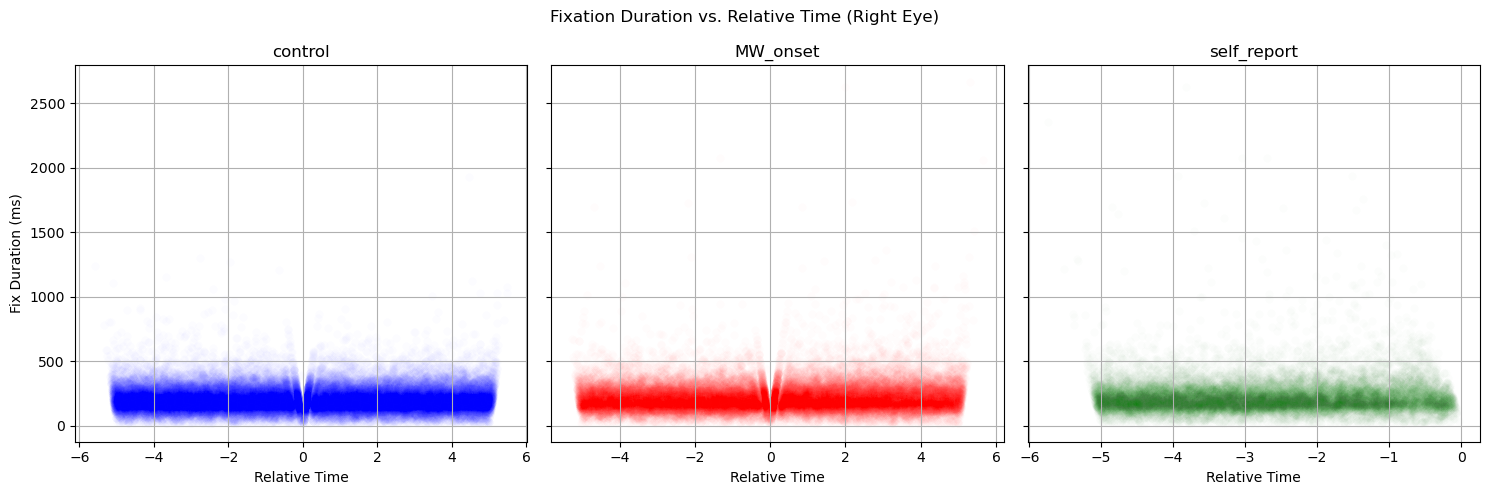

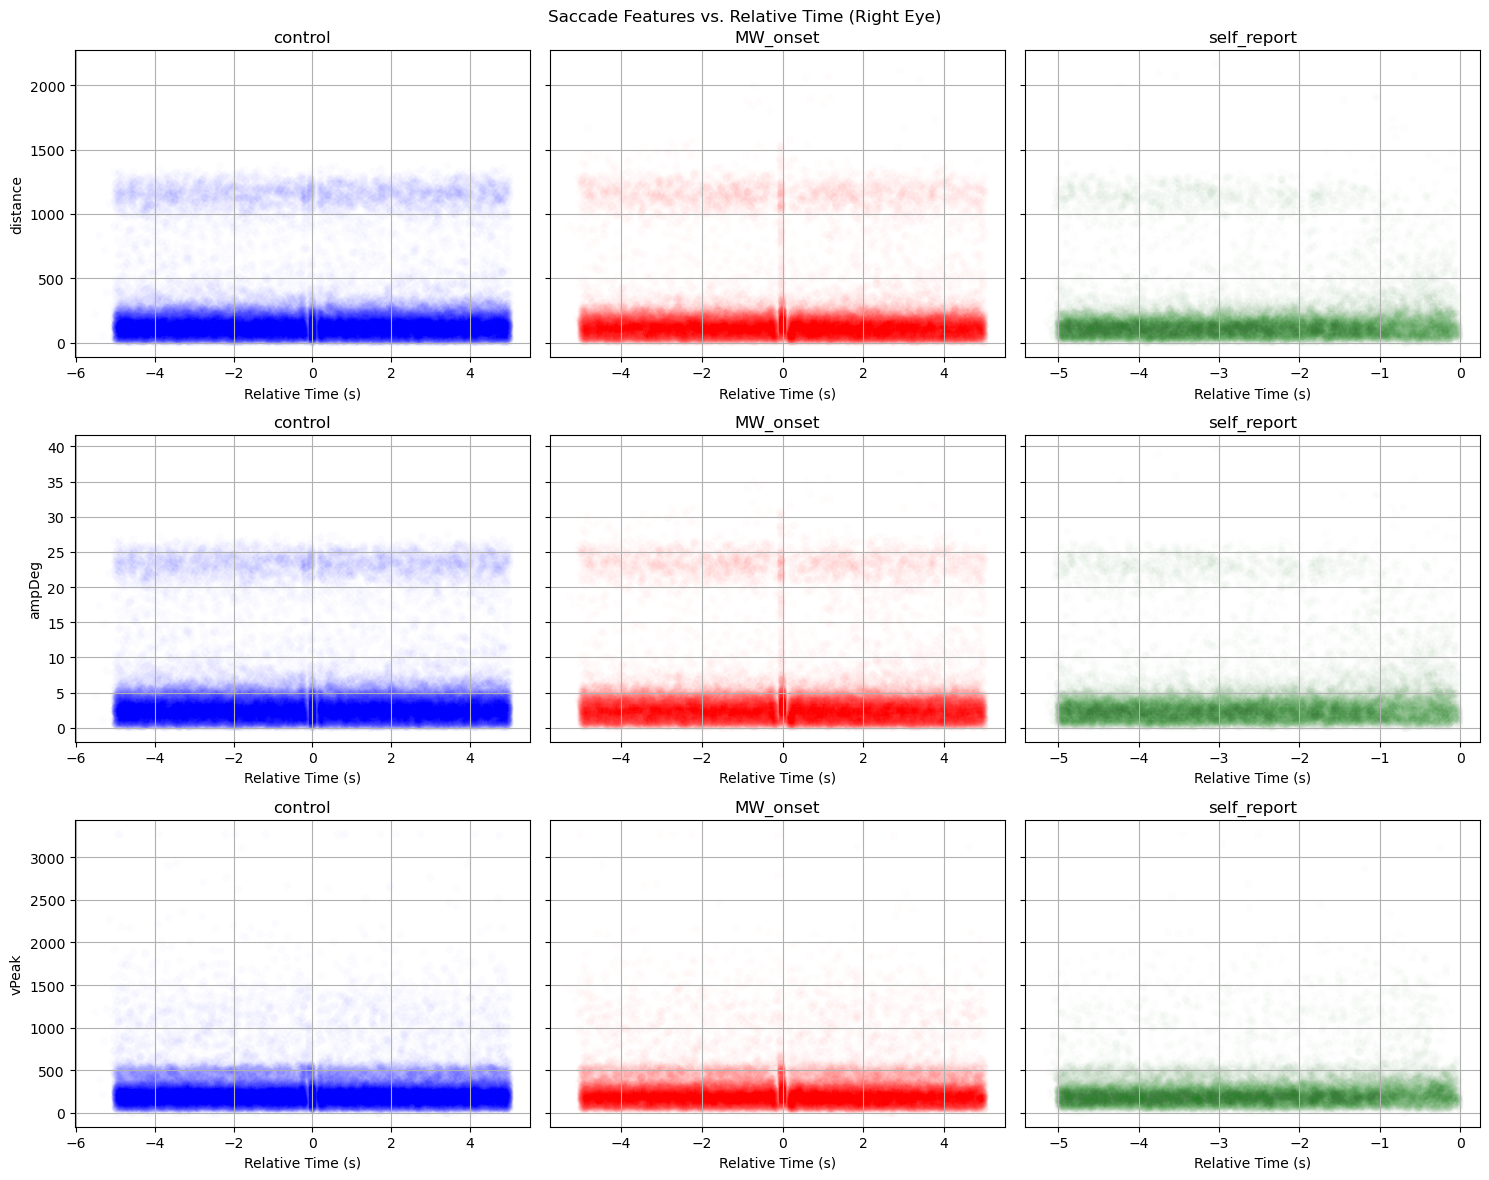

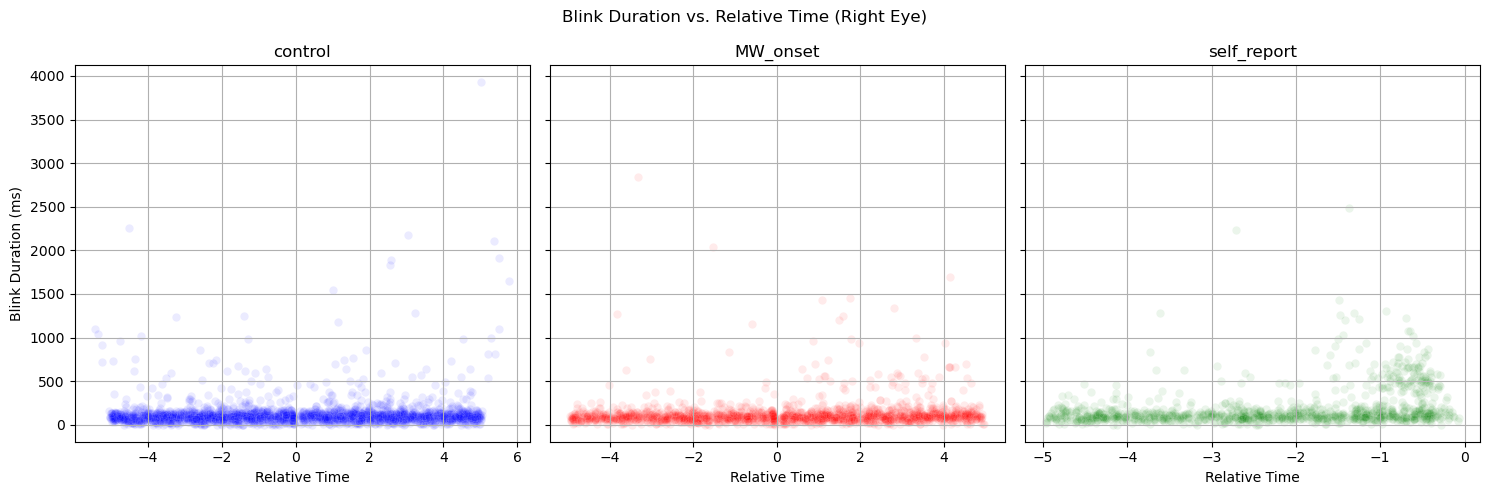

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dfFix_R = dfFix[dfFix['eye'] == 'R']
labels = ['control', 'MW_onset', 'self_report']

colors = ['blue', 'red', 'green']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Fixation Duration vs. Relative Time (Right Eye)")

for i, label in enumerate(labels):
    ax = axes[i]
    
    sns.scatterplot(
        data=dfFix_R[dfFix_R['label'] == label],
        x='relative_time',
        y='duration',
        alpha = 0.01,
        color = colors[i],
        ax=ax
    )
    ax.set_title(label)
    ax.set_xlabel('Relative Time')
    ax.set_ylabel('Fix Duration (ms)')
    ax.grid(True)  # add grid

plt.tight_layout()
plt.show()


dfSacc['distance'] = np.sqrt((dfSacc['xEnd'].astype(float) - dfSacc['xStart'].astype(float))**2 + 
                             (dfSacc['yEnd'].astype(float) - dfSacc['yStart'].astype(float))**2)
df = dfSacc[dfSacc['eye'] == 'R']
df = df[df['relative_time'] < 5]
features = ['distance', 'ampDeg', 'vPeak']

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharey='row')
fig.suptitle("Saccade Features vs. Relative Time (Right Eye)")

for row_idx, feature in enumerate(features):
    for col_idx, label in enumerate(labels):
        ax = axes[row_idx, col_idx]
        values = df[df['label'] == label]['relative_time']
        sns.scatterplot(
            data=df[df['label'] == label],
            x='relative_time',
            y=feature,
            alpha=0.01,
            color=colors[col_idx],
            ax=ax
        )
        ax.set_title(f'{label}')
        ax.set_xlabel('Relative Time (s)')
        ax.set_ylabel(feature)
        ax.grid(True)

plt.tight_layout()
plt.show()


df = dfBlink[dfBlink['eye'] == 'R']
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Blink Duration vs. Relative Time (Right Eye)")

for i, label in enumerate(labels):
    ax = axes[i]
    
    sns.scatterplot(
        data=df[df['label'] == label],
        x='relative_time',
        y='duration',
        alpha = 0.08,
        color = colors[i],
        ax=ax
    )
    ax.set_title(label)
    ax.set_xlabel('Relative Time')
    ax.set_ylabel('Blink Duration (ms)')
    ax.grid(True)  # add grid

plt.tight_layout()
plt.show()



# Interpolate non-windowed eye features

## CubicSpline

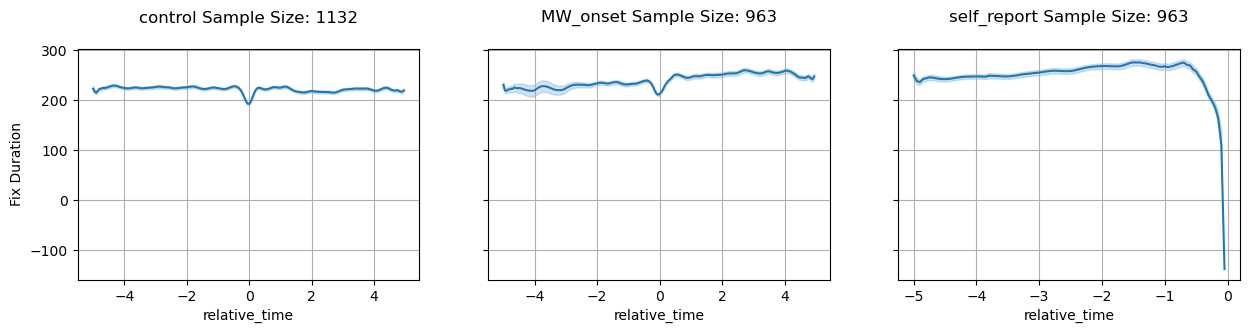

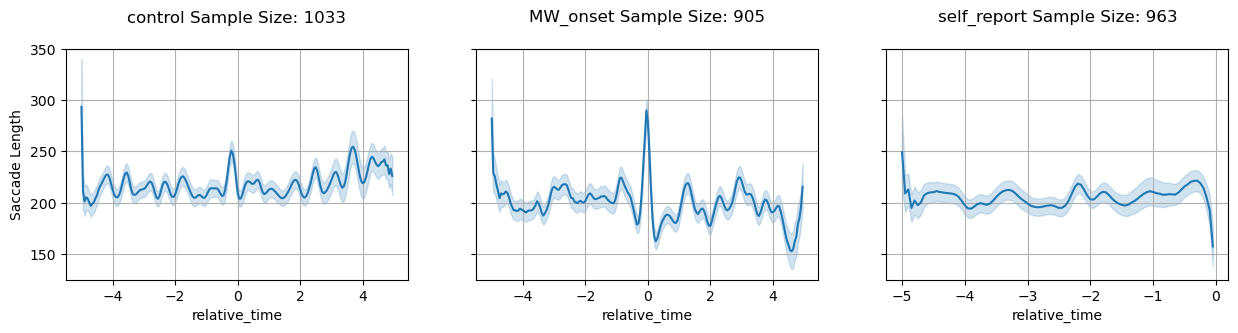

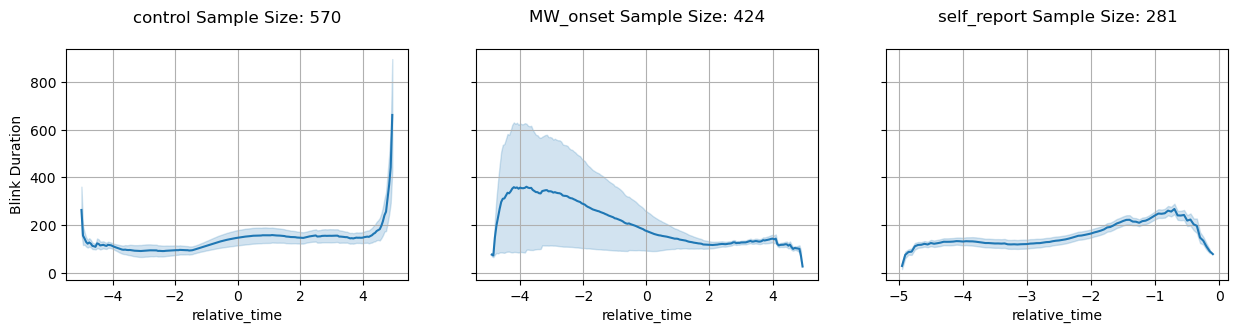

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns

# load dataset
# define root path
path = r"/Volumes/GBLDrive/MindlessReading/Data"
# define time array for interpolation
fs = 20
time_array = np.arange(-5, 5, 1/fs)

dfFix = pd.read_csv(os.path.join(path, "fixation_events.csv"))
dfFix = dfFix[dfFix['eye']=='R']
dfSacc = pd.read_csv(os.path.join(path, "saccade_events.csv"))  
dfSacc = dfSacc[dfSacc['eye']=='R']
dfBlink = pd.read_csv(os.path.join(path, "blink_events.csv"))
dfBlink = dfBlink[dfBlink['eye']=='R']

fs = 20
time_array = np.arange(-5, 5, 1/fs)

# Fixation
df = pd.read_csv(os.path.join(path, "fixation_events.csv"))
df = df[df['eye']=='R']

df_trials = df[['sub_id', 'run', 'page', 'label']].drop_duplicates()
df_interp = pd.DataFrame()

for _, row in df_trials.iterrows():
    sub_id, run, page, label = row[['sub_id', 'run', 'page', 'label']]

    df_ = df[
        (df['sub_id'] == sub_id) &
        (df['run'] == run) &
        (df['page'] == page) &
        (df['label'] == label)
    ]

    x = df_['relative_time'].values
    y = df_['duration'].values

    if len(x) >= 2:  # CubicSpline requires at least two points
        spl = CubicSpline(x, y, extrapolate=False)
        y_interp = spl(time_array)

        # Replace values outside x range with NaN
        y_interp[(time_array < x.min()) | (time_array > x.max())] = np.nan

        df_interp_ = pd.DataFrame({
            'relative_time': time_array,
            'duration': y_interp,
            'sub_id': sub_id,
            'run': run,
            'page': page,
            'label': label
        })

        df_interp = pd.concat([df_interp, df_interp_], ignore_index=True)
    
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
df = df_interp
for ax, condition in zip(axes, ['control', 'MW_onset', 'self_report']):
    # Filter dataset for the current condition
    df_condition = df[df['label'] == condition]

    # Plot lineplot with error bars (mean ± standard error)
    sns.lineplot(
        data=df_condition, 
        x='relative_time', 
        y='duration', 
        estimator='mean', 
        errorbar='se',  # Standard errors as error bars
        err_style='band',  # Shaded error band
        ax=ax
    )

    sample_size = len(df_condition[['sub_id', 'run', 'page', 'label']].drop_duplicates())

    # Initialize title text
    title_text = f"{condition} Sample Size: {sample_size}\n"

    # Update plot title
    ax.set_title(title_text)
    ax.grid()
    ax.set_ylabel('Fix Duration')


# Saccade
df = pd.read_csv(os.path.join(path, "saccade_events.csv")) 
df = df[df['eye']=='R']
df['distance'] = np.sqrt((df['xEnd'].astype(float) - df['xStart'].astype(float))**2 + 
                         (df['yEnd'].astype(float) - df['yStart'].astype(float))**2)

df_trials = df[['sub_id', 'run', 'page', 'label']].drop_duplicates()
df_interp = pd.DataFrame()

for _, row in df_trials.iterrows():
    sub_id, run, page, label = row[['sub_id', 'run', 'page', 'label']]

    df_ = df[
        (df['sub_id'] == sub_id) &
        (df['run'] == run) &
        (df['page'] == page) &
        (df['label'] == label)
    ]

    x = df_['relative_time'].values
    y = df_['distance'].values

    if x.max() > 5:
        continue

    if len(x) >= 2:  # CubicSpline requires at least two points
        spl = CubicSpline(x, y, extrapolate=False)
        y_interp = spl(time_array)

        # Replace values outside x range with NaN
        y_interp[(time_array < x.min()) | (time_array > x.max())] = np.nan

        df_interp_ = pd.DataFrame({
            'relative_time': time_array,
            'distance': y_interp,
            'sub_id': sub_id,
            'run': run,
            'page': page,
            'label': label
        })

        df_interp = pd.concat([df_interp, df_interp_], ignore_index=True)
    
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
df = df_interp
for ax, condition in zip(axes, ['control', 'MW_onset', 'self_report']):
    # Filter dataset for the current condition
    df_condition = df[df['label'] == condition]

    # Plot lineplot with error bars (mean ± standard error)
    sns.lineplot(
        data=df_condition, 
        x='relative_time', 
        y='distance', 
        estimator='mean', 
        errorbar='se',  # Standard errors as error bars
        err_style='band',  # Shaded error band
        ax=ax
    )

    sample_size = len(df_condition[['sub_id', 'run', 'page', 'label']].drop_duplicates())

    # Initialize title text
    title_text = f"{condition} Sample Size: {sample_size}\n"

    # Update plot title
    ax.set_title(title_text)
    ax.grid()
    ax.set_ylabel('Saccade Length')
    

# Blink
df = pd.read_csv(os.path.join(path, "blink_events.csv"))
df = df[df['eye']=='R']

df_trials = df[['sub_id', 'run', 'page', 'label']].drop_duplicates()
df_interp = pd.DataFrame()

for _, row in df_trials.iterrows():
    sub_id, run, page, label = row[['sub_id', 'run', 'page', 'label']]

    df_ = df[
        (df['sub_id'] == sub_id) &
        (df['run'] == run) &
        (df['page'] == page) &
        (df['label'] == label)
    ]

    x = df_['relative_time'].values
    y = df_['duration'].values

    if len(x) >= 2:  # CubicSpline requires at least two points
        spl = CubicSpline(x, y, extrapolate=False)
        y_interp = spl(time_array)

        # Replace values outside x range with NaN
        y_interp[(time_array < x.min()) | (time_array > x.max())] = np.nan

        df_interp_ = pd.DataFrame({
            'relative_time': time_array,
            'duration': y_interp,
            'sub_id': sub_id,
            'run': run,
            'page': page,
            'label': label
        })

        df_interp = pd.concat([df_interp, df_interp_], ignore_index=True)
    
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
df = df_interp
for ax, condition in zip(axes, ['control', 'MW_onset', 'self_report']):
    # Filter dataset for the current condition
    df_condition = df[df['label'] == condition]

    # Plot lineplot with error bars (mean ± standard error)
    sns.lineplot(
        data=df_condition, 
        x='relative_time', 
        y='duration', 
        estimator='mean', 
        errorbar='se',  # Standard errors as error bars
        err_style='band',  # Shaded error band
        ax=ax
    )

    sample_size = len(df_condition[['sub_id', 'run', 'page', 'label']].drop_duplicates())

    # Initialize title text
    title_text = f"{condition} Sample Size: {sample_size}\n"

    # Update plot title
    ax.set_title(title_text)
    ax.grid()
    ax.set_ylabel('Blink Duration')


## Forward interpolation

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns
# load dataset
# define root path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
# define time array for interpolation
fs = 20
time_array = np.arange(-5, 5+1/fs, 1/fs)

dfFix = pd.read_csv(os.path.join(path, "fixation_events.csv"))
dfFix = dfFix[dfFix['eye']=='R']
dfSacc = pd.read_csv(os.path.join(path, "saccade_events.csv"))  
dfSacc = dfSacc[dfSacc['eye']=='R']
dfBlink = pd.read_csv(os.path.join(path, "blink_events.csv"))
dfBlink = dfBlink[dfBlink['eye']=='R']

# Fixation interpolation
df = dfFix.copy()
df_trials = df[['sub_id', 'run', 'page', 'label']].drop_duplicates()
df_interp = pd.DataFrame()

for _, row in df_trials.iterrows():
    sub_id, run, page, label = row[['sub_id', 'run', 'page', 'label']]

    df_ = df[
        (df['sub_id'] == sub_id) &
        (df['run'] == run) &
        (df['page'] == page) &
        (df['label'] == label)
    ]

    x = df_['relative_time'].values
    y = df_['duration'].values

    if len(x) >= 1:
        # Step 1: Set up time-indexed segment
        df_segment = pd.DataFrame({'relative_time': x, 'duration': y}).dropna()
        df_segment = df_segment.set_index('relative_time').sort_index()

        # Step 2: Reindex to uniform time array with forward fill
        df_interp_ = pd.DataFrame(index=time_array)
        df_interp_['duration'] = df_segment.reindex(time_array, method='ffill')['duration']

        # Step 3: Optional backfill at the beginning
        df_interp_['duration'] = df_interp_['duration'].bfill()

        # Step 4: Add metadata
        df_interp_ = df_interp_.reset_index().rename(columns={'index': 'relative_time'})
        df_interp_['sub_id'] = sub_id
        df_interp_['run'] = run
        df_interp_['page'] = page
        df_interp_['label'] = label

        # Step 5: Append to full dataset
        df_interp = pd.concat([df_interp, df_interp_], ignore_index=True)

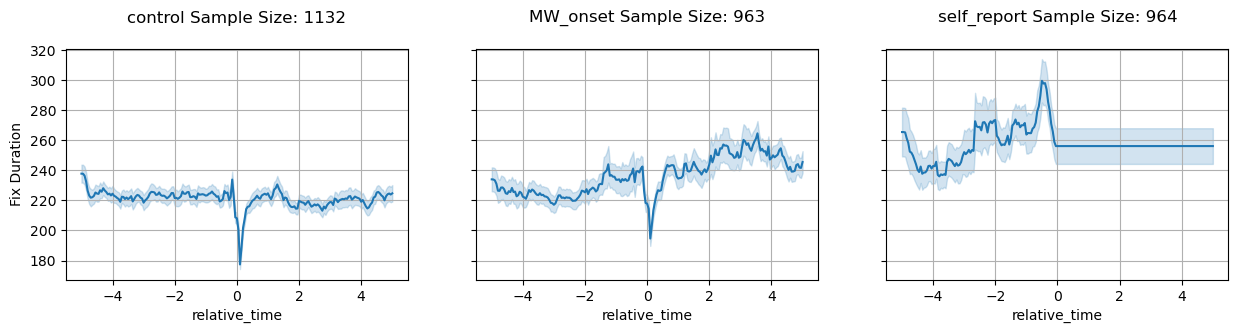

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
df = df_interp
for ax, condition in zip(axes, ['control', 'MW_onset', 'self_report']):
    # Filter dataset for the current condition
    df_condition = df[df['label'] == condition]

    df_subj = (
        df_condition
        .groupby(['sub_id', 'relative_time'])['duration']
        .mean()
        .reset_index()
    )

    # Plot lineplot with error bars (mean ± standard error)
    sns.lineplot(
        data=df_subj, 
        x='relative_time', 
        y='duration', 
        estimator='mean', 
        errorbar='se',  # Standard errors as error bars
        err_style='band',  # Shaded error band
        ax=ax
    )

    sample_size = len(df_condition[['sub_id', 'run', 'page', 'label']].drop_duplicates())

    # Initialize title text
    title_text = f"{condition} Sample Size: {sample_size}\n"

    # Update plot title
    ax.set_title(title_text)
    ax.grid()
    ax.set_ylabel('Fix Duration')

In [ ]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def extract_cq_info(data_file):
    '''
    This function reads in psychopy csv file and extracts answers and subject
    responses to the comprehension questions

    Parameters
    ----------
    data_file : string
        DESCRIPTION. The path to PsychoPy csv file.

    Returns
    -------
    answer df: dataframe
        DESCRIPTION. df contains answers and subject responses

    '''
    # read the csv file
    df = pd.read_csv(data_file)
    # locate to rows that store answers and responses
    mask = np.where(pd.isnull(df['key_resp_question.keys']) == False)[0]
    reading = df.loc[mask, 'reading']
    answers = df.loc[mask, 'Answer']
    responses = df.loc[mask, 'key_resp_question.keys']
    pages = np.arange(len(reading))
    # create the return dataframe with these two series
    frame = {'reading': reading, 'page': pages, 'answer': answers, 'response':responses}
    
    return pd.DataFrame(frame)


# root path
path = r"/Volumes/GBLDrive/MindlessReading/Data"

# grab every sub folders under the input path
sub_folders = [f.path for f in os.scandir(path) if f.is_dir()]
# define group dataframe
df = pd.DataFrame()

# loop through every folder
for folder_path in sub_folders:
    # extract subject id
    subject_id = re.findall(r's[0-9]+', folder_path)
    if subject_id:
        subject_id = subject_id[0]
    else:
        continue  # Skip this iteration or handle the error as needed

    # extract tracking and behavior features
    file_path = glob.glob(os.path.join(folder_path, '**/*R[0-9]_MindlessReading_*.csv'))
    
    # for each psychopy csv file
    for file in file_path: 
        # read in the subject csv
        df_ind = extract_cq_info(file)
        # add subject id columne
        df_ind['sub_id'] = subject_id
        # append to the group dataframe
        df = pd.concat([df, df_ind], ignore_index=True)

# Convert columns to float and replace None with np.nan
df['answer'] = df['answer'].replace('None', np.nan).astype(float)
df['response'] = df['response'].replace('None', np.nan).astype(float)

# Now you can compare the two columns
df['is_correct'] = df['answer'] == df['response']
df1 = df

# load MW results
df2 = pd.read_csv(os.path.join(path, 'group_features_end2_sr.csv'))

# merge two dataframes
df = pd.merge(df1, df2, on=['reading', 'page', 'sub_id'], how='inner')
df['MW_dur'] = df['MW_end'] - df['MW_start']

# Create the 'status' column based on the conditions
df['status'] = np.where(df['response'] == 5, 'not attempted', 
                            np.where(df['is_correct'], 'correct', 'incorrect'))


# Line-plot 2 seconds

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statannot import add_stat_annotation
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.patches import PathPatch
from matplotlib.path import Path

wlen = 2

def fill_between_gradient_imshow(ax, x, y1, y2, color_start, color_end, alpha=0.3, resolution=300):
    x = np.asarray(x)
    y1 = pd.Series(y1).interpolate(method='linear', limit_direction='both').to_numpy()
    y2 = pd.Series(y2).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(y2)
    x, y1, y2 = x[valid], y1[valid], y2[valid]
    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y1, y2 = x[sort_idx], y1[sort_idx], y2[sort_idx]

    cmap = LinearSegmentedColormap.from_list("grad_fill", [color_start, color_end])
    xx = np.linspace(x.min(), x.max(), resolution)
    yy = np.linspace(min(y1.min(), y2.min()), max(y1.max(), y2.max()), resolution)

    # Build horizontal gradient weights: flat on ends, transition between -2.5 to 2.5
    weights = np.zeros_like(xx, dtype=float)
    mask_grad = (xx >= - wlen/2) & (xx <= wlen/2)
    weights[xx > wlen/2] = 1.0
    weights[mask_grad] = (xx[mask_grad] + wlen/2) / wlen

    gradient = np.repeat(weights.reshape(1, -1), resolution, axis=0)

    im = ax.imshow(
        gradient, aspect='auto', extent=[x.min(), x.max(), yy.min(), yy.max()],
        origin='lower', cmap=cmap, alpha=alpha, interpolation='bicubic', zorder=1
    )

    # Create clip path
    verts = np.column_stack([x, y1])
    verts = np.concatenate([verts, np.column_stack([x[::-1], y2[::-1]])])
    path = Path(verts)
    patch = PathPatch(path, facecolor='none', edgecolor='none', zorder=2)
    ax.add_patch(patch)
    im.set_clip_path(patch)
    ax.autoscale_view()
    
def plot_gradient_line(ax, x, y, color_start, color_end, label=None, linewidth=2, zorder=3):
    x = np.asarray(x)
    y = pd.Series(y).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[valid], y[valid]

    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]

    # Define gradient weights
    weights = np.zeros_like(x, dtype=float)
    mask_grad = (x >= -wlen/2) & (x <= wlen/2)
    weights[x > wlen/2] = 1.0
    weights[mask_grad] = (x[mask_grad] + wlen/2) / wlen  # Normalize [-wlen/2, wlen/2] → [0, 1]

    cmap = LinearSegmentedColormap.from_list("grad", [color_start, color_end])
    colors = cmap(weights)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, colors=colors[:-1], linewidth=linewidth, zorder=zorder)
    ax.add_collection(lc)

    if label:
        ax.plot([], [], color=color_end, label=label)

    ax.autoscale_view()

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
path_to_save = f"/Volumes/GBLDrive/MindlessReading/Results/Eye/Group/line{wlen}"
# Slide Window (window duration 2 seconds)
file_name = f'group_features_slide{wlen}.csv'

# load group file
df = pd.read_csv(os.path.join(path, file_name))

# define the time offset (in seconds) to exclude
alpha = 1.5
mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)

# List of features to analyze
features = [
    'norm_fix_word_num', 'norm_in_word_reg', 
    'norm_out_word_reg', 'zscored_zipf_fixdur_corr', 
    'zscored_word_length_fixdur_corr', 'norm_total_viewing', 
    'fix_dispersion', 'weighted_vergence', 
    'blink_dur', 'blink_freq', 'norm_ibi',
    'norm_sacc_num', 'sacc_length', 
    'pupil', 'pupil_slope', 'norm_pupil'
]


# Loop through each feature
for i, feature in enumerate(features):
    # Create new figure per feature
    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1], sharey=ax0)
    sig_blocks = [[], []]

    for j, ax, label_control, label_target, color, title in zip(
        [0, 1],
        [ax0, ax1],
        ['control_onset', 'control_sr'],
        ['MW_onset', 'self_report'],
        ['tab:red', 'tab:green'],
        ['MW onset', 'self-report']
    ):
        df_control = df[df['label'] == label_control].copy()
        df_target = df[df['label'] == label_target].copy()

        df_avg_control = (
            df_control.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )
        df_avg_target = (
            df_target.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )

        # Statistical test
        timepoints = df_avg_control['relative_time'].unique()
        timepoints.sort()
        p_values = [
            ttest_ind(
                df_avg_control[df_avg_control['relative_time'] == t][feature],
                df_avg_target[df_avg_target['relative_time'] == t][feature],
                equal_var=False
            )[1]
            for t in timepoints
        ]
        # _, p_corrected = fdrcorrection(p_values, alpha=0.05)
        p_corrected = p_values
        sig_times = np.sort(np.array(timepoints)[np.array(p_corrected) < 0.05])

        breaks = np.where(np.diff(sig_times) > 0.25)[0] + 1
        blocks = np.split(sig_times, breaks)
        sig_blocks[j] = blocks

        # Aggregate mean and SEM
        df_plot = (
            df_avg_target
            .groupby(['relative_time'])[feature]
            .agg(['mean', 'sem'])
            .reset_index()
        )

        for d in [df_avg_control, df_avg_target]:
            mask = abs(d['relative_time']) == wlen / 2
            d.loc[mask, features] = np.nan
        mask = abs(df_plot['relative_time']) == wlen / 2
        df_plot.loc[mask, ['mean', 'sem']] = np.nan

        # Control: solid blue line
        sns.lineplot(data=df_avg_control, x='relative_time', y=feature,
                     estimator='mean', errorbar='se', err_style='band',
                     color='tab:blue', label='control', ax=ax)

        # Target: gradient line + gradient fill
        x = df_plot['relative_time'].values
        y = df_plot['mean'].values
        y1 = y - df_plot['sem'].values
        y2 = y + df_plot['sem'].values
        start_color = 'tab:blue' if title == 'MW onset' else 'tab:red'
        end_color = 'tab:red'
        fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, alpha=0.3)
        plot_gradient_line(ax, x, y, start_color, end_color, label="MW")

        ax.grid()
        if j == 0:
            ax.legend()
        else:
            ax.legend().remove()

    # Align y-axes and add significance bars
    ymin = min(ax0.get_ylim()[0], ax1.get_ylim()[0])
    ymax = max(ax0.get_ylim()[1], ax1.get_ylim()[1])
    offset = (ymax - ymin) * 0.05
    y_sig = ymin - offset
    for ax in [ax0, ax1]:
        ax.set_ylim(y_sig - offset, ymax)
        ax.grid(True)

    is_plotted = False
    for block in sig_blocks[0]:
        if len(block) > 1:
            ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='black', linewidth=2)
            if not is_plotted:
                ax0.text((block[0]-0.1), y_sig, '*', ha='center', va='bottom', fontsize=12)
                is_plotted = True

    is_plotted = False
    for block in sig_blocks[1]:
        if len(block) > 1:
            ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='black', linewidth=2)
            if not is_plotted:
                ax1.text((block[0]-0.1), y_sig, '*', ha='center', va='bottom', fontsize=12)
                is_plotted = True

    ax0.set_xticks(range(int(-5), int(5) + 1))
    ax0.axvline(x=0, color='black', linestyle='--', linewidth=2)

    ax0.set_ylabel(feature)
    ax1.set_ylabel("")

    ax0.set_xlabel("Time relative to MW onset (s)")
    ax1.set_xlabel("Time relative to self-report (s)")

    # Save figure
    filename = os.path.join(path_to_save, f"{feature}_wlen{wlen}.png")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close(fig)

# Line-plot 5 seconds

## Control -> MW onset -> Self-report

C:\Users\11376\AppData\Local\Temp\ipykernel_2564\815775044.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 3))


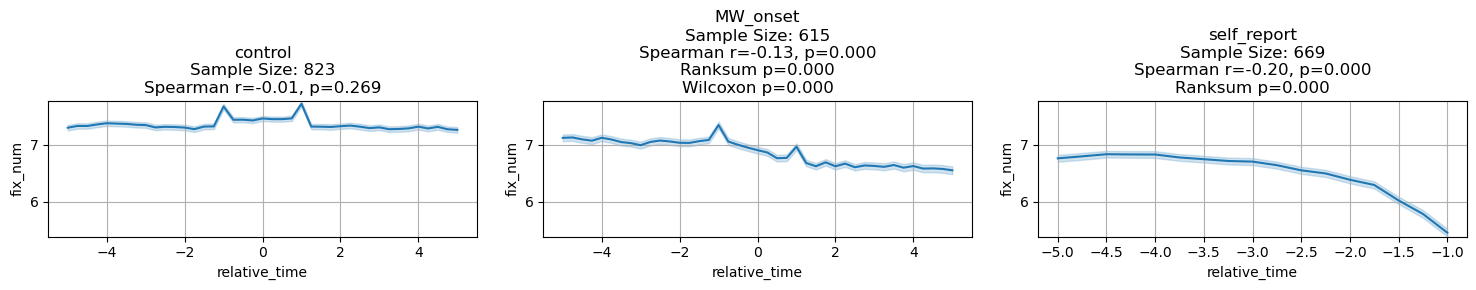

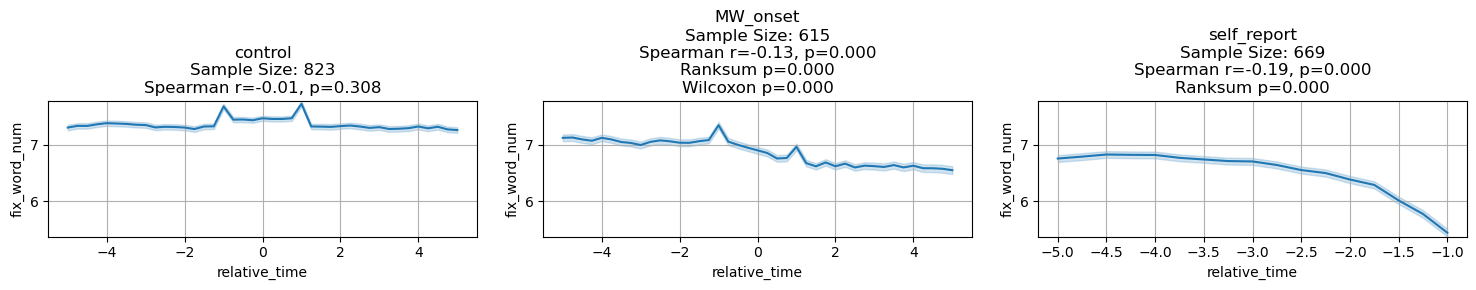

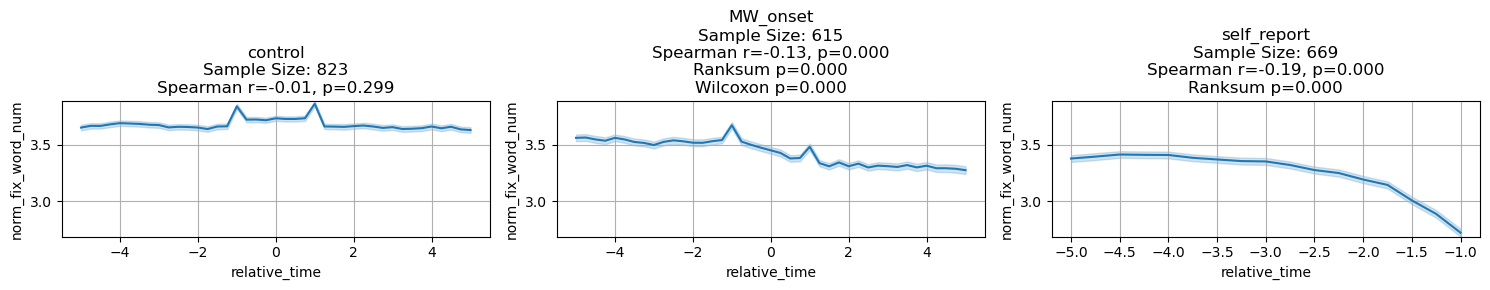

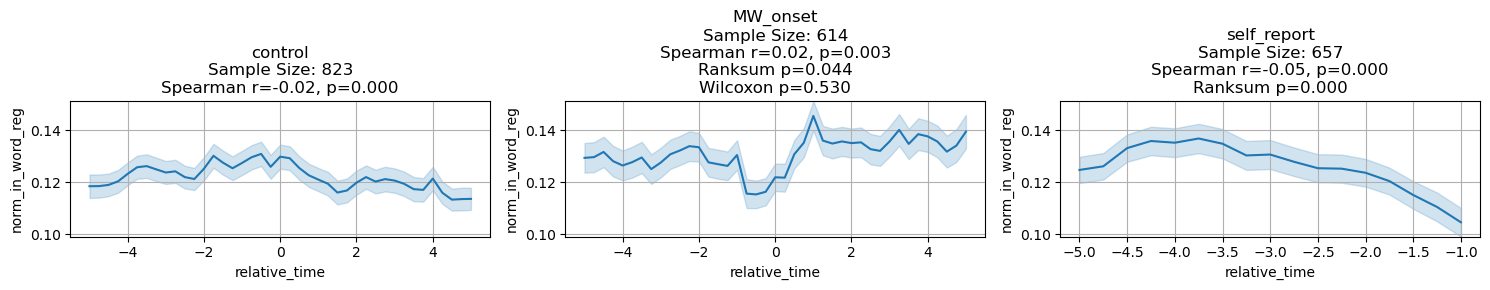

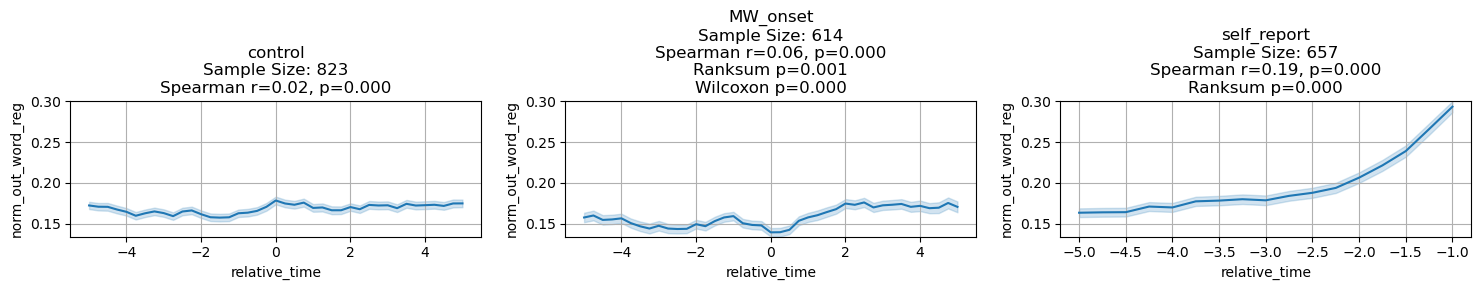

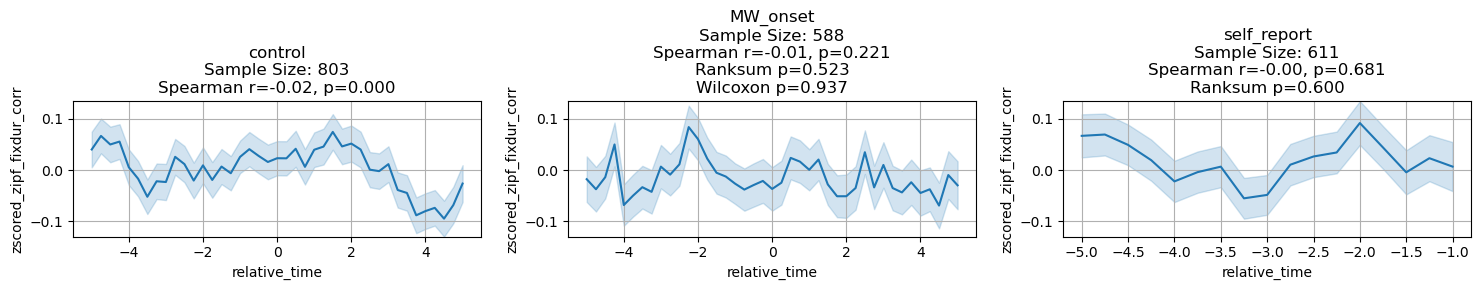

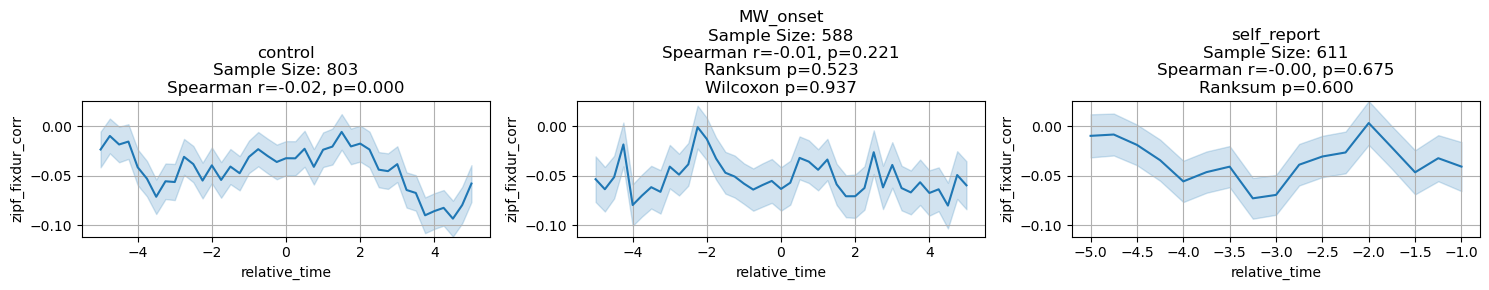

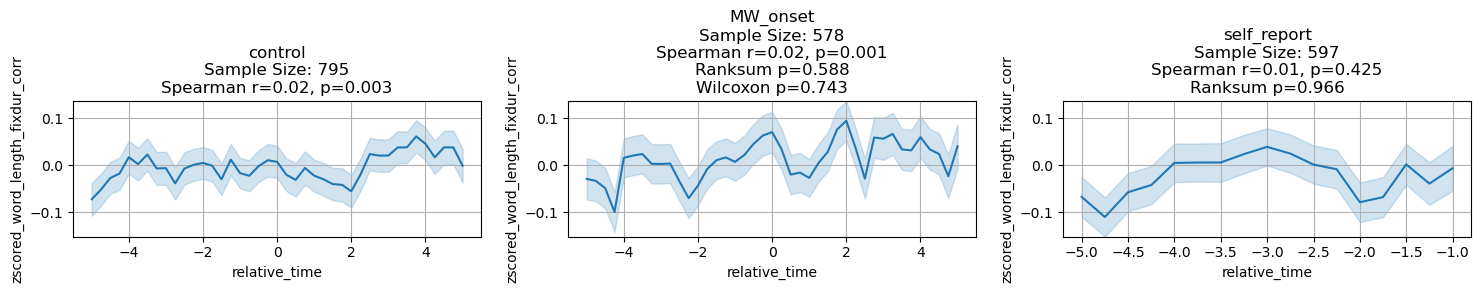

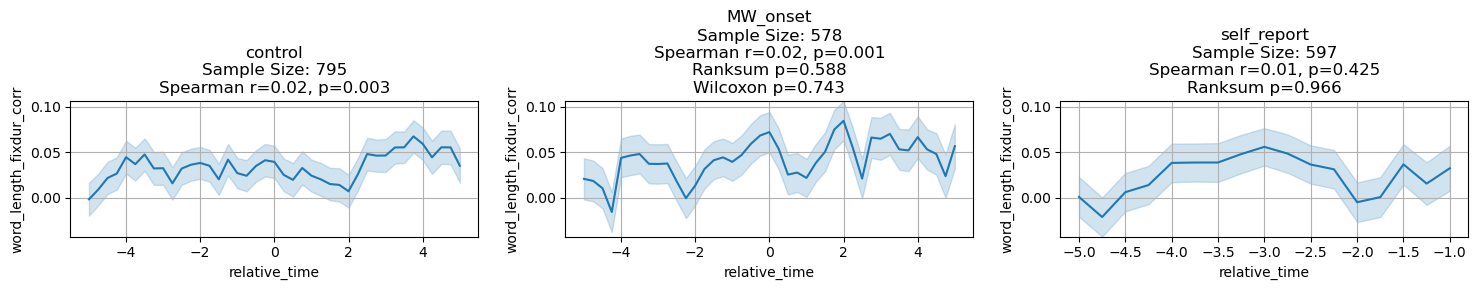

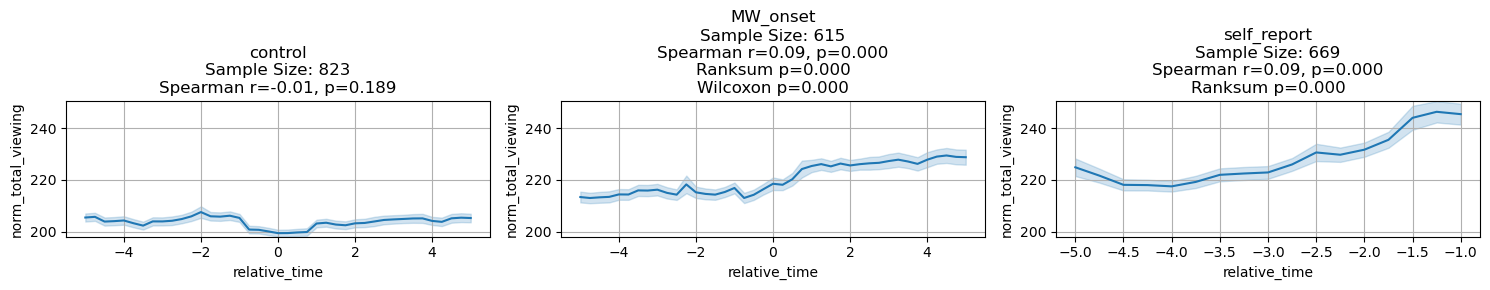

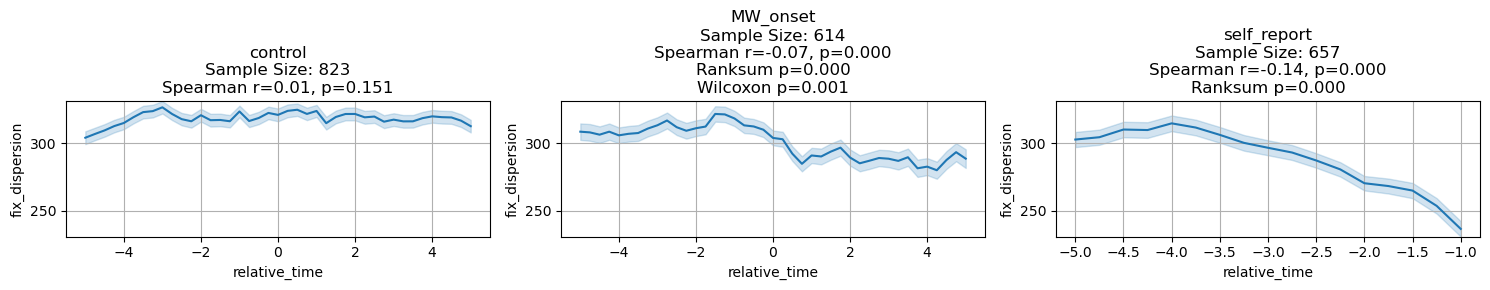

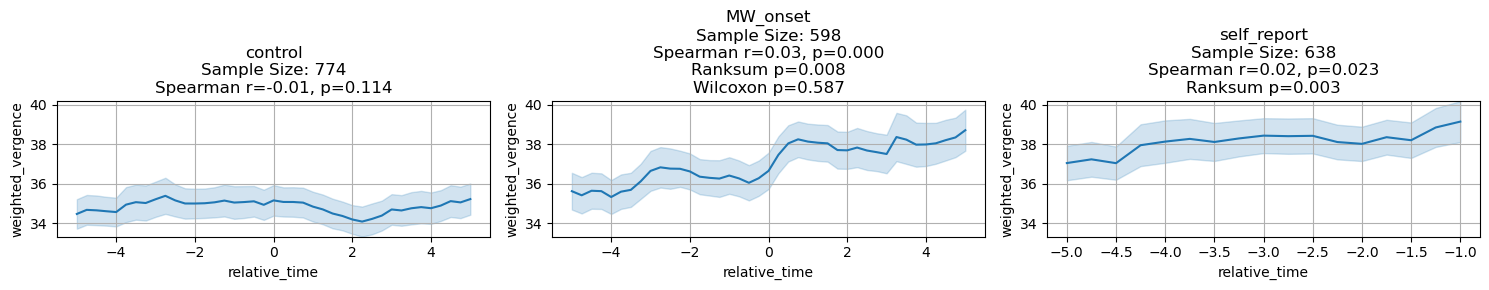

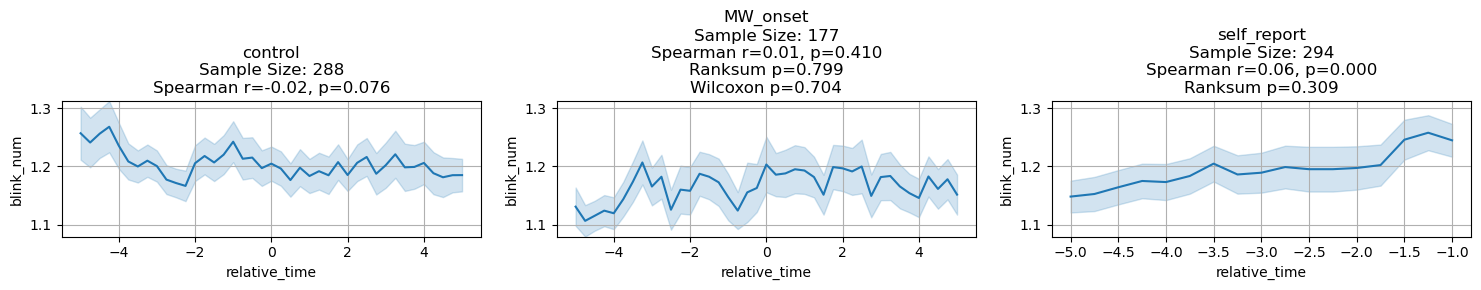

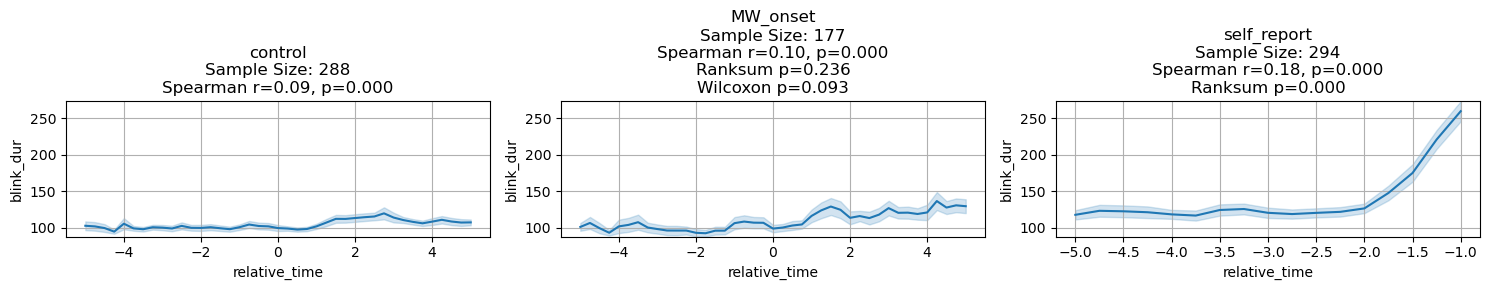

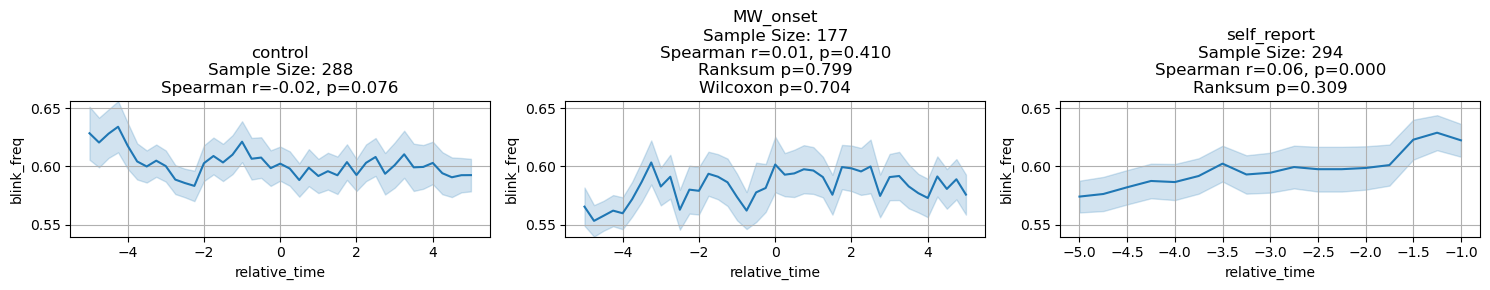

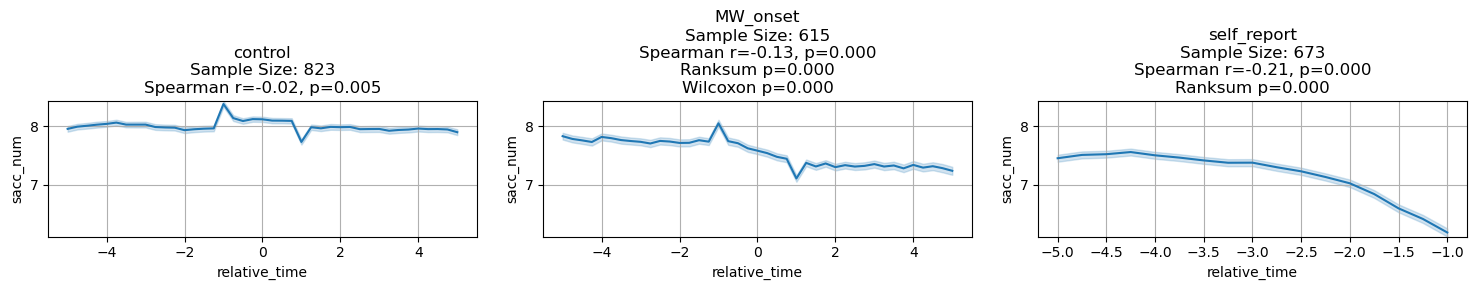

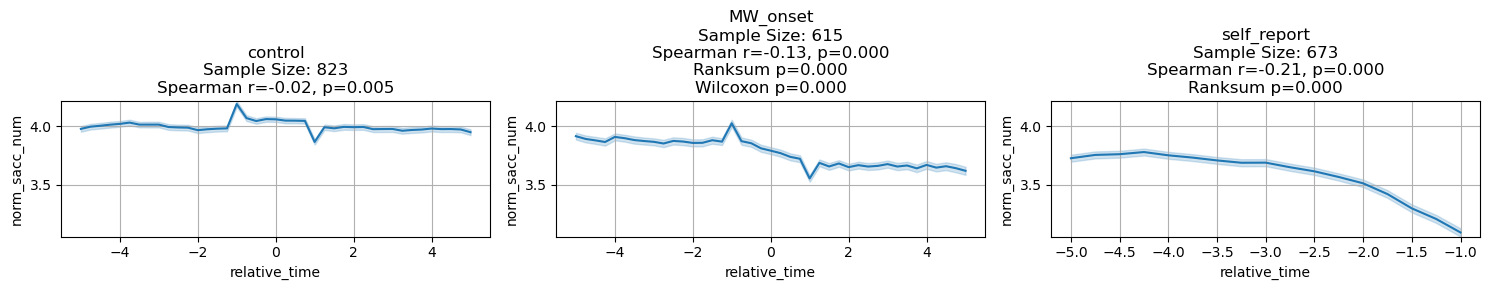

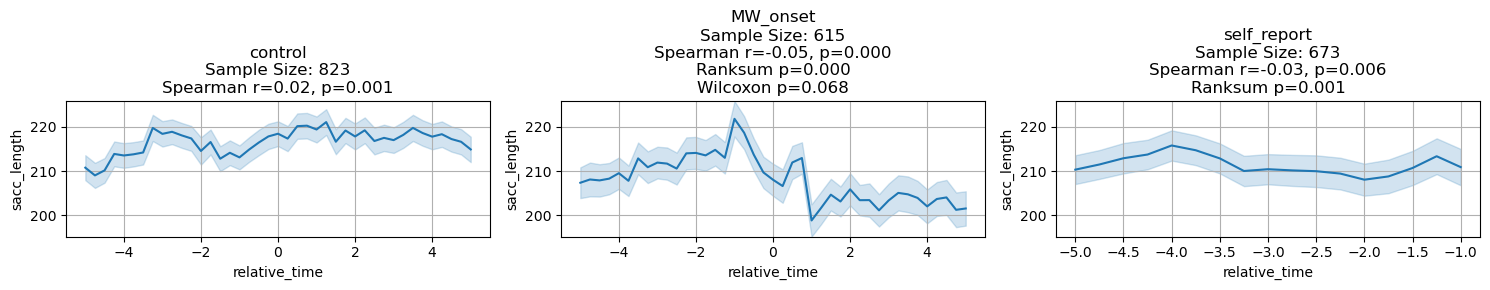

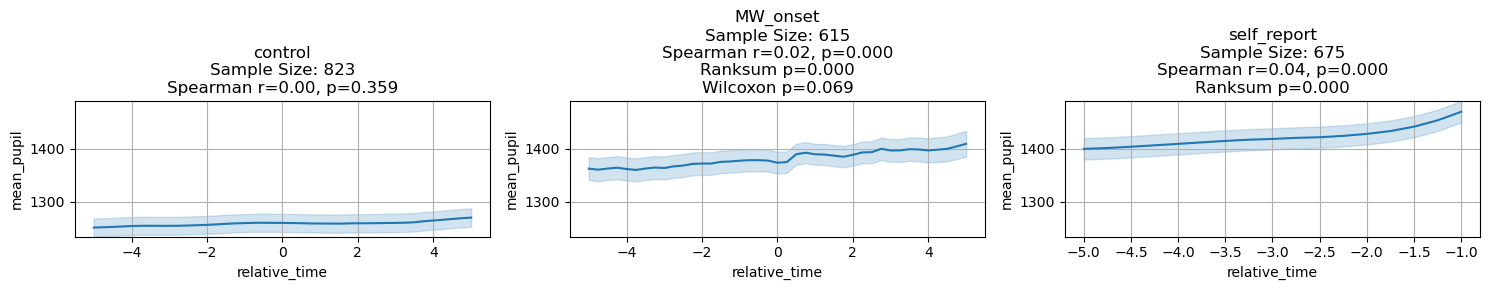

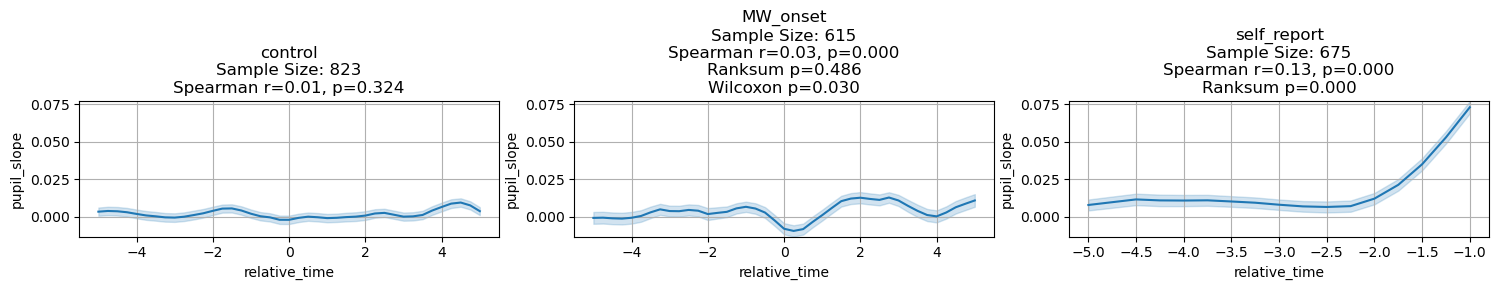

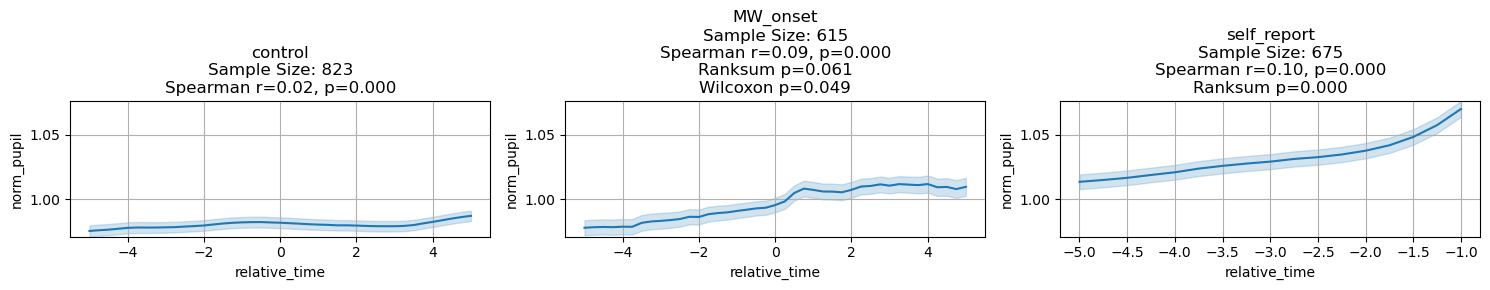

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statannot import add_stat_annotation
from scipy import stats

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"

# Slide Window (window duration 5 seconds)
file_name = 'group_features_slide5.csv'

# load group file
df = pd.read_csv(os.path.join(path, file_name))

# define the time offset (in seconds) to exclude
alpha = 1.5
mask = df['page_end']-df['win_end'] >= alpha
df = df[mask]



# List of features to analyze
features = [
    'fix_num', 'fix_word_num', 'norm_fix_word_num', 'norm_in_word_reg', 
    'norm_out_word_reg', 'zscored_zipf_fixdur_corr', 'zipf_fixdur_corr', 
    'zscored_word_length_fixdur_corr', 'word_length_fixdur_corr', 'norm_total_viewing', 
    'fix_dispersion', 'weighted_vergence', 'blink_num', 'blink_dur', 'blink_freq', 
    'sacc_num', 'norm_sacc_num', 'sacc_length', 'mean_pupil', 'pupil_slope', 'norm_pupil'
]

for feature in features:
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    # Store y-axis limits based on standard error
    y_min, y_max = np.inf, -np.inf  

    # Ranksum Test: Compare Control (t=0) vs MW_onset (t=1) / Self-report (t=-1)
    control_data = df[(df['label'] == 'control') & (df['relative_time'] == 0)][feature].dropna()
    mw_onset_data = df[(df['label'] == 'MW_onset') & (df['relative_time'] == 1)][feature].dropna()
    self_report_data = df[(df['label'] == 'self_report') & (df['relative_time'] == -(win_len/2))][feature].dropna()

    _, ranksum_p_mw = stats.ranksums(control_data, mw_onset_data, nan_policy='omit') if len(control_data) > 1 and len(mw_onset_data) > 1 else (np.nan, np.nan)
    _, ranksum_p_sr = stats.ranksums(control_data, self_report_data, nan_policy='omit') if len(control_data) > 1 and len(self_report_data) > 1 else (np.nan, np.nan)

    for ax, condition in zip(axes, ['control', 'MW_onset', 'self_report']):
        # Filter dataset for the current condition
        df_condition = df[df['label'] == condition]

        # Pivot: Convert 'relative_time' to columns while keeping ('sub_id', 'run', 'page') as index
        df_wide = df_condition.pivot_table(index=['sub_id', 'run', 'page'], columns='relative_time', values=feature)

        # Reindex to ensure all relative_time columns exist
        df_wide = df_wide.reindex(columns=time_range)

        # Convert back to long format
        df_long = df_wide.reset_index().melt(id_vars=['sub_id', 'run', 'page'], var_name='relative_time', value_name=feature)
        df_long['relative_time'] = df_long['relative_time'].astype(float)  # Ensure numeric ordering

        # Compute average across `run` and `page`
        df_avg = df_long.groupby(['relative_time'])[feature].mean().reset_index()
        df_se = df_long.groupby(['relative_time'])[feature].sem().reset_index()  # Compute standard error

        # Determine min/max y-values based on SE bands
        y_min = min(y_min, (df_avg[feature] - df_se[feature]).min())
        y_max = max(y_max, (df_avg[feature] + df_se[feature]).max())

        # Compute Non-NaN sample size at reference time
        reference_time = -(win_len/2) if condition == 'self_report' else 0
        sample_data = df_long[df_long['relative_time'] == reference_time][feature].dropna()
        sample_size = len(sample_data)

        # Compute Spearman's correlation
        spearman_r, spearman_p = stats.spearmanr(df_long["relative_time"], df_long[feature], nan_policy="omit")

        # Plot lineplot with error bars (mean ± standard error)
        sns.lineplot(
            data=df_long, 
            x='relative_time', 
            y=feature, 
            estimator='mean', 
            errorbar='se',  # Standard errors as error bars
            err_style='band',  # Shaded error band
            ax=ax
        )

        # Initialize title text
        title_text = f"{condition}\nSample Size: {sample_size}\nSpearman r={spearman_r:.2f}, p={spearman_p:.3f}"

        # Wilcoxon Test for MW_onset (-2.5 vs 2.5)
        if condition == 'MW_onset':
            pre_onset = df_wide[-2.5]
            post_onset = df_wide[2.5]
            title_text += f"\nRanksum p={ranksum_p_mw:.3f}"
            if len(pre_onset) > 1 and len(post_onset) > 1:
                _, wilcoxon_p = stats.wilcoxon(pre_onset, post_onset, nan_policy='omit')
                title_text += f"\nWilcoxon p={wilcoxon_p:.3f}"

        # Add Ranksum p-values
        if condition == 'self_report':
            title_text += f"\nRanksum p={ranksum_p_sr:.3f}"

        # Update plot title
        ax.set_title(title_text)
        ax.grid()

    # Set y-limits based on computed SE range
    for ax in axes:
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.savefig(f'../../../../Results/LinePlot/{feature}_win{win_len}.png')

## Control and MW onset/self-report in the same figure

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statannot import add_stat_annotation
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.patches import PathPatch
from matplotlib.path import Path

wlen = 5

def fill_between_gradient_imshow(ax, x, y1, y2, color_start, color_end, alpha=0.3, resolution=300):
    x = np.asarray(x)
    y1 = pd.Series(y1).interpolate(method='linear', limit_direction='both').to_numpy()
    y2 = pd.Series(y2).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(y2)
    x, y1, y2 = x[valid], y1[valid], y2[valid]
    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y1, y2 = x[sort_idx], y1[sort_idx], y2[sort_idx]

    cmap = LinearSegmentedColormap.from_list("grad_fill", [color_start, color_end])
    xx = np.linspace(x.min(), x.max(), resolution)
    yy = np.linspace(min(y1.min(), y2.min()), max(y1.max(), y2.max()), resolution)

    # Build horizontal gradient weights: flat on ends, transition between -2.5 to 2.5
    weights = np.zeros_like(xx, dtype=float)
    mask_grad = (xx >= - wlen/2) & (xx <= wlen/2)
    weights[xx > wlen/2] = 1.0
    weights[mask_grad] = (xx[mask_grad] + wlen/2) / wlen

    gradient = np.repeat(weights.reshape(1, -1), resolution, axis=0)

    im = ax.imshow(
        gradient, aspect='auto', extent=[x.min(), x.max(), yy.min(), yy.max()],
        origin='lower', cmap=cmap, alpha=alpha, interpolation='bicubic', zorder=1
    )

    # Create clip path
    verts = np.column_stack([x, y1])
    verts = np.concatenate([verts, np.column_stack([x[::-1], y2[::-1]])])
    path = Path(verts)
    patch = PathPatch(path, facecolor='none', edgecolor='none', zorder=2)
    ax.add_patch(patch)
    im.set_clip_path(patch)
    ax.autoscale_view()   

def plot_gradient_line(ax, x, y, color_start, color_end, label=None, linewidth=2, zorder=3):
    x = np.asarray(x)
    y = pd.Series(y).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[valid], y[valid]

    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]

    # Define gradient weights
    weights = np.zeros_like(x, dtype=float)
    mask_grad = (x >= -wlen/2) & (x <= wlen/2)
    weights[x > wlen/2] = 1.0
    weights[mask_grad] = (x[mask_grad] + wlen/2) / wlen  # Normalize [-wlen/2, wlen/2] → [0, 1]

    cmap = LinearSegmentedColormap.from_list("grad", [color_start, color_end])
    colors = cmap(weights)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, colors=colors[:-1], linewidth=linewidth, zorder=zorder)
    ax.add_collection(lc)

    if label:
        ax.plot([], [], color=color_end, label=label)

    ax.autoscale_view()

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
path_to_save = f"/Volumes/GBLDrive/MindlessReading/Results/Eye/Group/line{wlen}"
# Slide Window (window duration 2 seconds)
file_name = f'group_features_slide{wlen}.csv'

# load group file
df = pd.read_csv(os.path.join(path, file_name))

# define the time offset (in seconds) to exclude
alpha = 1.5
mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)

# List of features to analyze
features = [
    'norm_fix_word_num', 'norm_in_word_reg', 
    'norm_out_word_reg', 'zscored_zipf_fixdur_corr', 
    'zscored_word_length_fixdur_corr', 'norm_total_viewing', 
    'fix_dispersion', 'weighted_vergence', 
    'blink_dur', 'blink_freq', 'norm_ibi',
    'norm_sacc_num', 'sacc_length', 
    'pupil', 'pupil_slope', 'norm_pupil'
]


# Loop through each feature
for i, feature in enumerate(features):
    # Create new figure per feature
    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1], sharey=ax0)
    sig_blocks = [[], []]

    for j, ax, label_control, label_target, color, title in zip(
        [0, 1],
        [ax0, ax1],
        ['control_onset', 'control_sr'],
        ['MW_onset', 'self_report'],
        ['tab:red', 'tab:green'],
        ['MW onset', 'self-report']
    ):
        df_control = df[df['label'] == label_control].copy()
        df_target = df[df['label'] == label_target].copy()

        df_avg_control = (
            df_control.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )
        df_avg_target = (
            df_target.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )

        # Statistical test
        timepoints = df_avg_control['relative_time'].unique()
        timepoints.sort()
        p_values = [
            ttest_ind(
                df_avg_control[df_avg_control['relative_time'] == t][feature],
                df_avg_target[df_avg_target['relative_time'] == t][feature],
                equal_var=False
            )[1]
            for t in timepoints
        ]
        # _, p_corrected = fdrcorrection(p_values, alpha=0.05)
        p_corrected = p_values
        sig_times = np.sort(np.array(timepoints)[np.array(p_corrected) < 0.05])

        breaks = np.where(np.diff(sig_times) > 0.25)[0] + 1
        blocks = np.split(sig_times, breaks)
        sig_blocks[j] = blocks

        # Aggregate mean and SEM
        df_plot = (
            df_avg_target
            .groupby(['relative_time'])[feature]
            .agg(['mean', 'sem'])
            .reset_index()
        )

        for d in [df_avg_control, df_avg_target]:
            mask = abs(d['relative_time']) == wlen / 2
            d.loc[mask, features] = np.nan
        mask = abs(df_plot['relative_time']) == wlen / 2
        df_plot.loc[mask, ['mean', 'sem']] = np.nan

        # Control: solid blue line
        sns.lineplot(data=df_avg_control, x='relative_time', y=feature,
                     estimator='mean', errorbar='se', err_style='band',
                     color='tab:blue', label='control', ax=ax)

        # Target: gradient line + gradient fill
        x = df_plot['relative_time'].values
        y = df_plot['mean'].values
        y1 = y - df_plot['sem'].values
        y2 = y + df_plot['sem'].values
        start_color = 'tab:blue' if title == 'MW onset' else 'tab:red'
        end_color = 'tab:red'
        fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, alpha=0.3)
        plot_gradient_line(ax, x, y, start_color, end_color, label="MW")

        ax.grid()
        if j == 0:
            ax.legend()
        else:
            ax.legend().remove()

    # Align y-axes and add significance bars
    ymin = min(ax0.get_ylim()[0], ax1.get_ylim()[0])
    ymax = max(ax0.get_ylim()[1], ax1.get_ylim()[1])
    offset = (ymax - ymin) * 0.05
    y_sig = ymin - offset
    for ax in [ax0, ax1]:
        ax.set_ylim(y_sig - offset, ymax)
        ax.grid(True)

    is_plotted = False
    for block in sig_blocks[0]:
        if len(block) > 1:
            ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='black', linewidth=2)
            if not is_plotted:
                ax0.text((block[0]-0.1), y_sig, '*', ha='center', va='bottom', fontsize=12)
                is_plotted = True

    is_plotted = False
    for block in sig_blocks[1]:
        if len(block) > 1:
            ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='black', linewidth=2)
            if not is_plotted:
                ax1.text((block[0]-0.1), y_sig, '*', ha='center', va='bottom', fontsize=12)
                is_plotted = True

    ax0.set_xticks(range(int(-5), int(5) + 1))
    ax0.axvline(x=0, color='black', linestyle='--', linewidth=2)

    ax0.set_ylabel(feature)
    ax1.set_ylabel("")

    ax0.set_xlabel("Time relative to MW onset (s)")
    ax1.set_xlabel("Time relative to self-report (s)")

    # Save figure
    filename = os.path.join(path_to_save, f"{feature}_wlen{wlen}.png")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close(fig)

# Individual line-plot

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statannot import add_stat_annotation
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = f'group_features_slide5.csv'
wlen = 5

path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Individual"
save_plot = True

# load group file
df = pd.read_csv(os.path.join(path, file_name))

# define the time offset (in seconds) to exclude
alpha = 1.5
mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)

subjects = df['sub_id'].unique()

# List of features to analyze
features = [
    "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
    "zscored_zipf_fixdur_corr", 'fix_dispersion', 
    'weighted_vergence', "pupil_slope", "norm_pupil", 'norm_ibi'
]

# features = ['norm_pupil']

for feature in features:

    # Save figure in a folder named by the feature
    feature_dir = os.path.join(path_to_save, feature)
    os.makedirs(feature_dir, exist_ok=True)

    for sub in subjects:
        df_ = df[df['sub_id']==sub].copy()

        # make subplots (MW onset - control / self-report - control)
        fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharey=True)
        plt.suptitle(sub)

        # ========================== MW onset ==============================
        ax = axes[0]
        df_control = df_[df_['label'] == 'control_onset'].copy()
        df_target = df_[df_['label'] == 'MW_onset'].copy()


        # compute the significant difference between two lines
        # get unique timepoints
        timepoints = df_control['relative_time'].unique()
        timepoints.sort()
        p_values = []
        for t in timepoints:
            vals1 = df_control[(df_control['relative_time'] == t)][feature]
            vals2 = df_target[(df_target['relative_time'] == t)][feature]

            # Assuming equal variance; use equal_var=False if unsure
            t_stat, p = ttest_ind(vals1, vals2, equal_var=False)
            p_values.append(p)
        _, p_corrected = fdrcorrection(p_values, alpha=0.05)
        sig_mask = np.array(p_corrected) < 0.05
        # sig_mask = np.array(p_values) < 0.05
        sig_times = np.array(timepoints)[sig_mask]

        # Plot lineplot with error bars (mean ± standard error)
        mask = abs(df_control['relative_time']) == wlen/2 
        df_control.loc[mask, features] = np.nan
        sns.lineplot(
            # data=df_long, 
            data=df_control,
            x='relative_time', 
            y=feature, 
            estimator='mean', 
            errorbar='se',  # Standard errors as error bars
            err_style='band',  # Shaded error band
            color='tab:blue',
            label='control',
            ax=ax
        )

        mask = abs(df_target['relative_time']) == wlen/2 
        df_target.loc[mask, features] = np.nan
        sns.lineplot(
            # data=df_long, 
            data=df_target,
            x='relative_time', 
            y=feature, 
            estimator='mean', 
            errorbar='se',  # Standard errors as error bars
            err_style='band',  # Shaded error band
            color='tab:red',
            label='MW onset',
            ax=ax
        )

        # add significance markers
        sig_times = np.sort(sig_times)
        # Find breaks in consecutive timepoints
        breaks = np.where(np.diff(sig_times) > 0.25)[0] + 1  # Adjust 1e-5 depending on precision
        blocks = np.split(sig_times, breaks)
        # Plot horizontal line for each block
        ymin, ymax = ax.get_ylim()
        offset = (ymax - ymin) * 0.05
        y_sig = ymin - offset
        for block in blocks:
            if len(block) > 1:
                ax.plot([block[0], block[-1]], [y_sig, y_sig], color='black', linewidth=2)
        # ax.set_ylim(y_sig - offset, ymax)  # extend to show lines

        # annotation
        ax.grid()
        ax.legend()


        # ========================== self-report ==============================
        ax = axes[1]

        df_control = df_[df_['label'] == 'control_sr'].copy()
        df_target = df_[df_['label'] == 'self_report'].copy()

        # compute the significant difference between two lines
        # get unique timepoints
        timepoints = df_control['relative_time'].unique()
        timepoints.sort()
        p_values = []
        for t in timepoints:
            vals1 = df_control[(df_control['relative_time'] == t)][feature]
            vals2 = df_target[(df_target['relative_time'] == t)][feature]

            # Assuming equal variance; use equal_var=False if unsure
            t_stat, p = ttest_ind(vals1, vals2, equal_var=False)
            p_values.append(p)
        _, p_corrected = fdrcorrection(p_values, alpha=0.05)
        sig_mask = np.array(p_corrected) < 0.05
        # sig_mask = np.array(p_values) < 0.05
        sig_times = np.array(timepoints)[sig_mask]

        # Plot lineplot with error bars (mean ± standard error)
        mask = abs(df_control['relative_time']) == wlen/2 
        df_control.loc[mask, features] = np.nan
        sns.lineplot(
            # data=df_long, 
            data=df_control,
            x='relative_time', 
            y=feature, 
            estimator='mean', 
            errorbar='se',  # Standard errors as error bars
            err_style='band',  # Shaded error band
            color='tab:blue',
            label='control',
            ax=ax
        )

        mask = abs(df_target['relative_time']) == wlen/2 
        df_target.loc[mask, features] = np.nan
        sns.lineplot(
            # data=df_long, 
            data=df_target,
            x='relative_time', 
            y=feature, 
            estimator='mean', 
            errorbar='se',  # Standard errors as error bars
            err_style='band',  # Shaded error band
            color='tab:red',
            label='MW onset',
            ax=ax
        )

        # add significance markers
        sig_times = np.sort(sig_times)
        # Find breaks in consecutive timepoints
        breaks = np.where(np.diff(sig_times) > 0.25)[0] + 1  # Adjust 1e-5 depending on precision
        blocks = np.split(sig_times, breaks)
        # Plot horizontal line for each block
        ymin, ymax = ax.get_ylim()
        offset = (ymax - ymin) * 0.05
        y_sig = ymin - offset
        for block in blocks:
            if len(block) > 1:
                ax.plot([block[0], block[-1]], [y_sig, y_sig], color='black', linewidth=2)
        # ax.set_ylim(y_sig - offset, ymax)  # extend to show lines

        # annotation
        ax.grid()
        ax.legend()

        if save_plot:
            filename = os.path.join(feature_dir, f"{sub}.png")
            plt.tight_layout()
            plt.savefig(filename)
            plt.close(fig)  # Close to free memory

        



/var/folders/dq/384f3y3d7blcwc_x_w8xb47w0000gp/T/ipykernel_14810/1303589595.py:72: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p = ttest_ind(vals1, vals2, equal_var=False)
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/var/folders/dq/384f3y3d7blcwc_x_w8xb47w0000gp/T/ipykernel_14810/1303589595.py:145: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unrelia

# Fit Sigmoid function

Fitting sigmoid curves to the signals...
Running bootstrap analysis to test for significant difference...


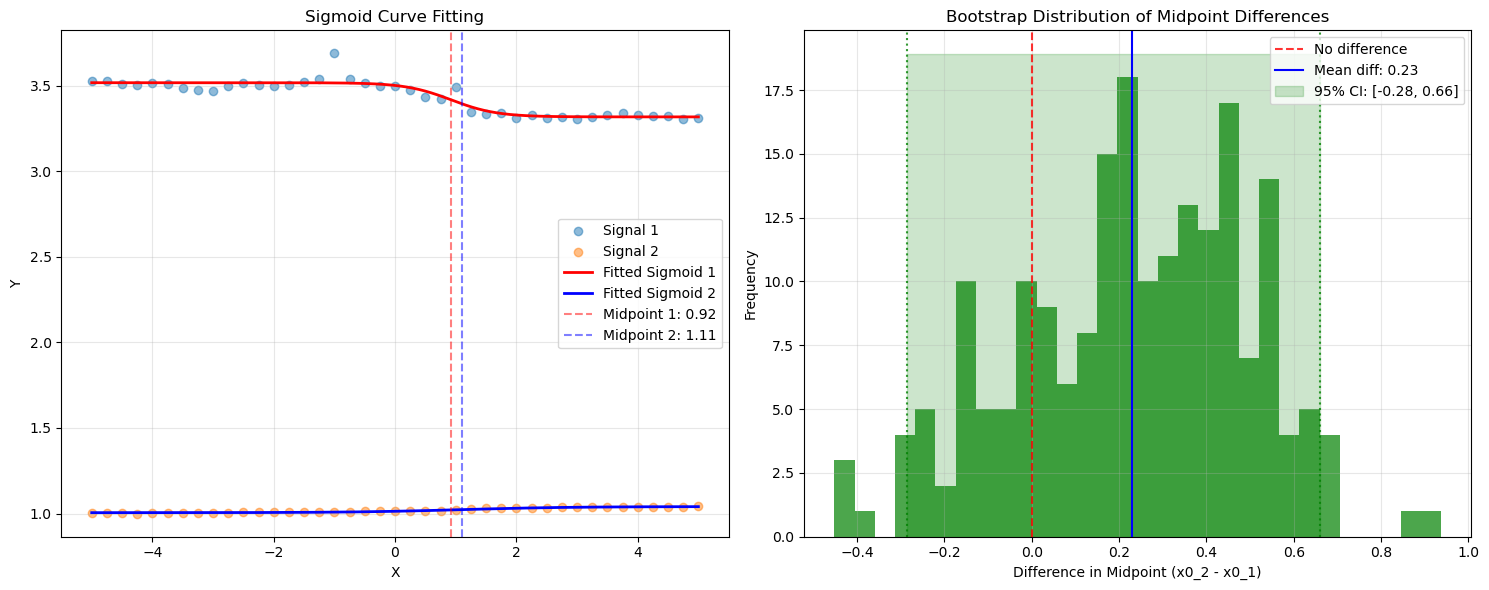


Analysis Results:
Signal 1 midpoint (x0): 0.9225
95% CI: [0.6138, 1.2313]
R² goodness of fit: 0.8710


Signal 2 midpoint (x0): 1.1085
95% CI: [0.8582, 1.3588]
R² goodness of fit: 0.9712


Midpoint difference (Signal 2 - Signal 1): 0.1860
Bootstrap 95% CI of difference: [-0.2850, 0.6608]
P-value: 0.4200
Statistically significant at α=0.05: False


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import r2_score

# Define the sigmoid function
def sigmoid(x, L, x0, k, b):
    """
    Four-parameter logistic sigmoid function.
    L: the curve's maximum value
    x0: the x-value of the sigmoid's midpoint
    k: the steepness of the curve
    b: the curve's minimum value
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

# Generate sample data - two signals with one shifted to the right
def generate_sample_data(n_points=100, noise_level=0.05, shift=2.0):
    # Create x values
    x = np.linspace(-10, 10, n_points)
    
    # Create two sigmoid curves, one shifted to the right
    true_params1 = [1.0, 0.0, 1.0, 0.0]  # L, x0, k, b
    true_params2 = [1.0, shift, 1.0, 0.0]  # x0 is shifted by 'shift' units
    
    # Generate y values with some noise
    y1 = sigmoid(x, *true_params1) + np.random.normal(0, noise_level, size=n_points)
    y2 = sigmoid(x, *true_params2) + np.random.normal(0, noise_level, size=n_points)
    
    return x, y1, y2, true_params1, true_params2

# Fit sigmoid curves to the data
def fit_sigmoid(x, y):
    """Fit sigmoid curve to data and return parameters with confidence intervals"""
    # Initial parameter guess [L, x0, k, b]
    p0 = [max(y) - min(y), np.median(x), 1, min(y)]
    
    try:
        # Fit the curve
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        
        # Calculate 95% confidence intervals
        perr = np.sqrt(np.diag(pcov))
        ci = []
        for i, p in enumerate(popt):
            ci.append((p - 1.96 * perr[i], p + 1.96 * perr[i]))
            
        # Calculate goodness of fit
        y_pred = sigmoid(x, *popt)
        r2 = r2_score(y, y_pred)
        
        return popt, ci, r2
    
    except RuntimeError:
        print("Error - curve fit failed")
        return None, None, None

# Perform bootstrap analysis to test for significant difference in midpoint parameter
def bootstrap_comparison(x, y1, y2, n_bootstrap=1000, confidence_level=0.95):
    """
    Use bootstrapping to test if the difference in x0 parameter is significant
    Returns p-value and confidence interval for the difference
    """
    n_points = len(x)
    diff_samples = []
    
    for _ in range(n_bootstrap):
        # Generate bootstrap samples by resampling residuals
        indices = np.random.choice(range(n_points), size=n_points, replace=True)
        x_sample = x[indices]
        y1_sample = y1[indices]
        y2_sample = y2[indices]
        
        # Fit curves to bootstrap samples
        p1, _, _ = fit_sigmoid(x_sample, y1_sample)
        p2, _, _ = fit_sigmoid(x_sample, y2_sample)
        
        if p1 is not None and p2 is not None:
            # Save the difference in midpoint parameters (x0)
            diff_samples.append(p2[1] - p1[1])
    
    # Convert to numpy array
    diff_samples = np.array(diff_samples)
    
    # Calculate p-value (two-tailed test)
    # H0: difference = 0
    p_value = np.mean(diff_samples <= 0) * 2
    if p_value > 1:
        p_value = 2 - p_value
    
    # Calculate confidence interval
    lower_bound = np.percentile(diff_samples, (1 - confidence_level) * 100 / 2)
    upper_bound = np.percentile(diff_samples, 100 - (1 - confidence_level) * 100 / 2)
    
    return p_value, (lower_bound, upper_bound), diff_samples

# Visualize the results
def plot_results(x, y1, y2, popt1, popt2, ci1, ci2, diff_samples=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot the data and fitted curves
    x_smooth = np.linspace(min(x), max(x), 1000)
    y1_fit = sigmoid(x_smooth, *popt1)
    y2_fit = sigmoid(x_smooth, *popt2)
    
    ax1.scatter(x, y1, alpha=0.5, label='Signal 1')
    ax1.scatter(x, y2, alpha=0.5, label='Signal 2')
    ax1.plot(x_smooth, y1_fit, 'r-', linewidth=2, label='Fitted Sigmoid 1')
    ax1.plot(x_smooth, y2_fit, 'b-', linewidth=2, label='Fitted Sigmoid 2')
    
    # Add vertical lines at the midpoints
    ax1.axvline(popt1[1], color='r', linestyle='--', alpha=0.5, label=f'Midpoint 1: {popt1[1]:.2f}')
    ax1.axvline(popt2[1], color='b', linestyle='--', alpha=0.5, label=f'Midpoint 2: {popt2[1]:.2f}')
    
    ax1.set_title('Sigmoid Curve Fitting')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot the bootstrap distribution of differences if available
    if diff_samples is not None:
        ax2.hist(diff_samples, bins=30, alpha=0.7, color='green')
        ax2.axvline(0, color='r', linestyle='--', alpha=0.8, label='No difference')
        ax2.axvline(np.mean(diff_samples), color='blue', linestyle='-', 
                   label=f'Mean diff: {np.mean(diff_samples):.2f}')
        
        # Add 95% CI
        ci_low = np.percentile(diff_samples, 2.5)
        ci_high = np.percentile(diff_samples, 97.5)
        ax2.axvline(ci_low, color='green', linestyle=':', alpha=0.8)
        ax2.axvline(ci_high, color='green', linestyle=':', alpha=0.8)
        ax2.fill_between([ci_low, ci_high], 0, plt.ylim()[1], alpha=0.2, color='green',
                        label=f'95% CI: [{ci_low:.2f}, {ci_high:.2f}]')
        
        ax2.set_title('Bootstrap Distribution of Midpoint Differences')
        ax2.set_xlabel('Difference in Midpoint (x0_2 - x0_1)')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main function to run the analysis
def analyze_sigmoid_shift(x, y1, y2, n_bootstrap=1000):
    """
    Analyze whether there's a significant shift between two signals
    using sigmoid curve fitting.
    
    Parameters:
    x1, y1: First signal's data points
    x2, y2: Second signal's data points
    n_bootstrap: Number of bootstrap samples for statistical testing
    
    Returns:
    Dictionary with analysis results
    """    
    # Fit sigmoid curves to both signals
    print("Fitting sigmoid curves to the signals...")
    popt1, ci1, r2_1 = fit_sigmoid(x, y1)
    popt2, ci2, r2_2 = fit_sigmoid(x, y2)
    
    if popt1 is None or popt2 is None:
        return {"error": "Curve fitting failed"}
    
    # Create results dictionary
    results = {
        "signal1": {
            "parameters": {
                "L (max value)": popt1[0],
                "x0 (midpoint)": popt1[1],
                "k (steepness)": popt1[2],
                "b (min value)": popt1[3]
            },
            "confidence_intervals": {
                "L_ci": ci1[0],
                "x0_ci": ci1[1],
                "k_ci": ci1[2],
                "b_ci": ci1[3]
            },
            "r2": r2_1
        },
        "signal2": {
            "parameters": {
                "L (max value)": popt2[0],
                "x0 (midpoint)": popt2[1],
                "k (steepness)": popt2[2],
                "b (min value)": popt2[3]
            },
            "confidence_intervals": {
                "L_ci": ci2[0],
                "x0_ci": ci2[1],
                "k_ci": ci2[2],
                "b_ci": ci2[3]
            },
            "r2": r2_2
        }
    }
    
    # Calculate the difference in midpoint parameters
    x0_diff = popt2[1] - popt1[1]
    results["midpoint_difference"] = x0_diff
    
    # Simple check if confidence intervals overlap
    ci_overlap = (ci1[1][1] >= ci2[1][0] and ci1[1][0] <= ci2[1][1])
    results["confidence_intervals_overlap"] = ci_overlap
    
    # Perform bootstrap analysis
    print("Running bootstrap analysis to test for significant difference...")
    p_value, ci_diff, diff_samples = bootstrap_comparison(x, y1, y2, n_bootstrap)
    
    results["bootstrap_analysis"] = {
        "p_value": p_value,
        "difference_ci": ci_diff,
        "significant_at_0.05": p_value < 0.05
    }
    
    # Create plots
    plot_results(x, y1, y2, popt1, popt2, ci1, ci2, diff_samples)
    
    return results

# =================================================================================================
# Example usage
# Generate sample data with a known shift of 2.0
# print("Generating sample data with a shift of 2.0...")
# x, y1, y2, true_params1, true_params2 = generate_sample_data(n_points=100, noise_level=0.05, shift=2.0)

# # Perform the analysis
# results = analyze_sigmoid_shift(x, y1, y2, n_bootstrap=1000)

# # Print the results in a nice format
# print("\nAnalysis Results:")
# print("=================")
# print(f"Signal 1 midpoint (x0): {results['signal1']['parameters']['x0 (midpoint)']:.4f}")
# print(f"95% CI: [{results['signal1']['confidence_intervals']['x0_ci'][0]:.4f}, {results['signal1']['confidence_intervals']['x0_ci'][1]:.4f}]")
# print(f"R² goodness of fit: {results['signal1']['r2']:.4f}")
# print("\n")
# print(f"Signal 2 midpoint (x0): {results['signal2']['parameters']['x0 (midpoint)']:.4f}")
# print(f"95% CI: [{results['signal2']['confidence_intervals']['x0_ci'][0]:.4f}, {results['signal2']['confidence_intervals']['x0_ci'][1]:.4f}]")
# print(f"R² goodness of fit: {results['signal2']['r2']:.4f}")
# print("\n")
# print(f"Midpoint difference (Signal 2 - Signal 1): {results['midpoint_difference']:.4f}")
# print(f"Bootstrap 95% CI of difference: [{results['bootstrap_analysis']['difference_ci'][0]:.4f}, {results['bootstrap_analysis']['difference_ci'][1]:.4f}]")
# print(f"P-value: {results['bootstrap_analysis']['p_value']:.4f}")
# print(f"Statistically significant at α=0.05: {results['bootstrap_analysis']['significant_at_0.05']}")
    
# For a real-world application, you would replace the generated sample data with your actual signals
# real_x = your_x_data
# real_y1 = your_first_signal
# real_y2 = your_second_signal
# results = analyze_sigmoid_shift(real_x, real_y1, real_y2, n_bootstrap=1000)
# =================================================================================================


# Example for using your own data from CSV files
def analyze_from_csv(signal1_file, signal2_file, x_column, y1_column, y2_column=None):
    """
    Analyze sigmoid shift using data from CSV files.
    
    Parameters:
    signal1_file: Path to CSV file with first signal
    signal2_file: Path to CSV file with second signal (can be the same as signal1_file)
    x_column: Column name for x values
    y1_column: Column name for first signal's y values
    y2_column: Column name for second signal's y values (if in the same file as signal1)
    """
    # Load the first signal
    df1 = pd.read_csv(signal1_file)
    x1 = df1[x_column].values
    y1 = df1[y1_column].values
    
    # Load the second signal (either from the same or different file)
    if y2_column is not None and signal2_file == signal1_file:
        # Both signals are in the same file
        x2 = x1
        y2 = df1[y2_column].values
    else:
        # Signals are in different files
        df2 = pd.read_csv(signal2_file)
        x2 = df2[x_column].values
        y2 = df2[y2_column or y1_column].values
    
    # Make sure x values match between the two signals
    if len(x1) != len(x2) or not np.allclose(x1, x2):
        # Interpolate if necessary
        print("X values don't match. Interpolating second signal to match the first...")
        from scipy.interpolate import interp1d
        f = interp1d(x2, y2, bounds_error=False, fill_value="extrapolate")
        y2 = f(x1)
        x2 = x1
    
    # Perform the analysis
    return analyze_sigmoid_shift(x1, y1, x2, y2, n_bootstrap=1000)

# Example of using the CSV function:
# results = analyze_from_csv('signal1.csv', 'signal2.csv', 'time', 'amplitude')
# Or if both signals are in the same file:
# results = analyze_from_csv('signals.csv', 'signals.csv', 'time', 'signal1', 'signal2')


# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"

wlen = 2
# Slide Window (window duration 2 seconds)
file_name = f'group_features_slide{wlen}.csv'

# load group file
df = pd.read_csv(os.path.join(path, file_name))

# define the time offset (in seconds) to exclude
alpha = 1.5
mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)
df_ = df[df['label']=='MW_onset'].copy()

features = ['norm_fix_word_num', 'norm_pupil']
df_ = (
        df_.groupby(['relative_time'])[features]
        .mean().reset_index()
        )

df_['fix_rate'] = df_['norm_fix_word_num']

x = df_['relative_time']
y1 = df_['fix_rate']
y2 = df_['norm_pupil']
results = analyze_sigmoid_shift(x, y1, y2, n_bootstrap=200)

# Print the results in a nice format
print("\nAnalysis Results:")
print("=================")
print(f"Signal 1 midpoint (x0): {results['signal1']['parameters']['x0 (midpoint)']:.4f}")
print(f"95% CI: [{results['signal1']['confidence_intervals']['x0_ci'][0]:.4f}, {results['signal1']['confidence_intervals']['x0_ci'][1]:.4f}]")
print(f"R² goodness of fit: {results['signal1']['r2']:.4f}")
print("\n")
print(f"Signal 2 midpoint (x0): {results['signal2']['parameters']['x0 (midpoint)']:.4f}")
print(f"95% CI: [{results['signal2']['confidence_intervals']['x0_ci'][0]:.4f}, {results['signal2']['confidence_intervals']['x0_ci'][1]:.4f}]")
print(f"R² goodness of fit: {results['signal2']['r2']:.4f}")
print("\n")
print(f"Midpoint difference (Signal 2 - Signal 1): {results['midpoint_difference']:.4f}")
print(f"Bootstrap 95% CI of difference: [{results['bootstrap_analysis']['difference_ci'][0]:.4f}, {results['bootstrap_analysis']['difference_ci'][1]:.4f}]")
print(f"P-value: {results['bootstrap_analysis']['p_value']:.4f}")
print(f"Statistically significant at α=0.05: {results['bootstrap_analysis']['significant_at_0.05']}")



# Fix rate and pupil size from different window length

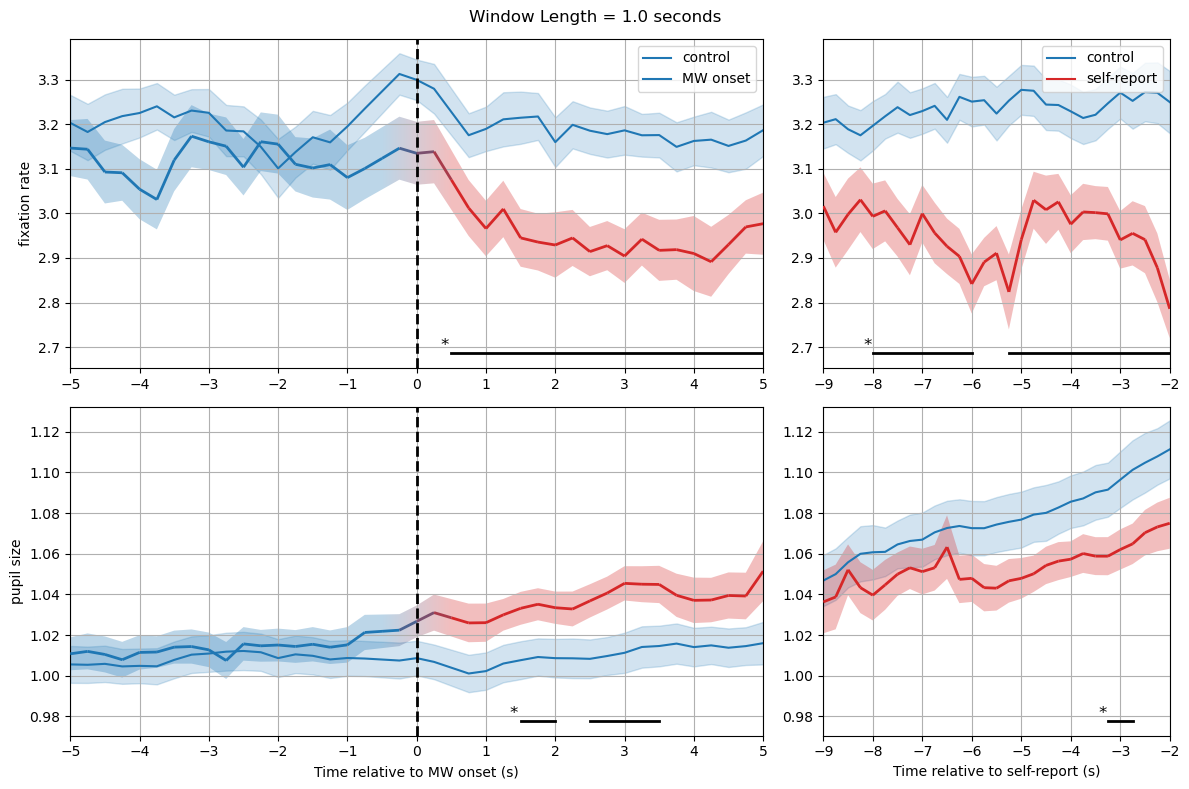

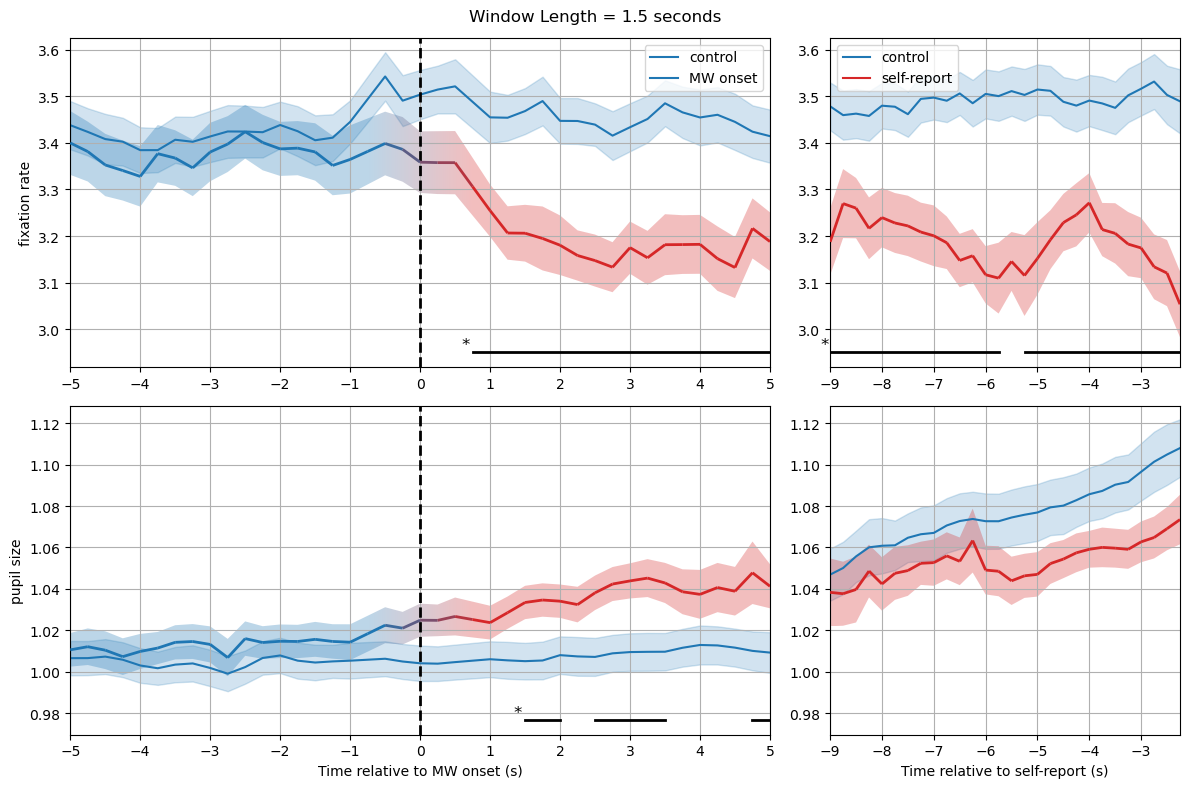

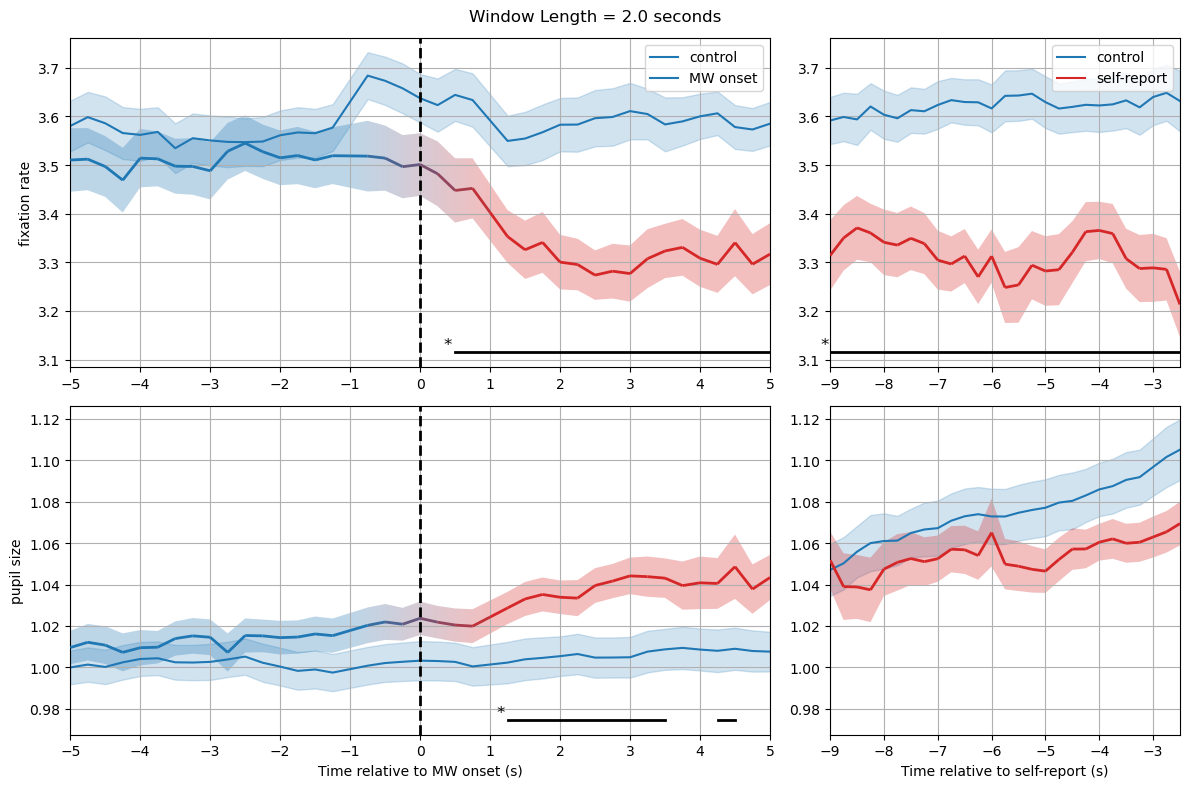

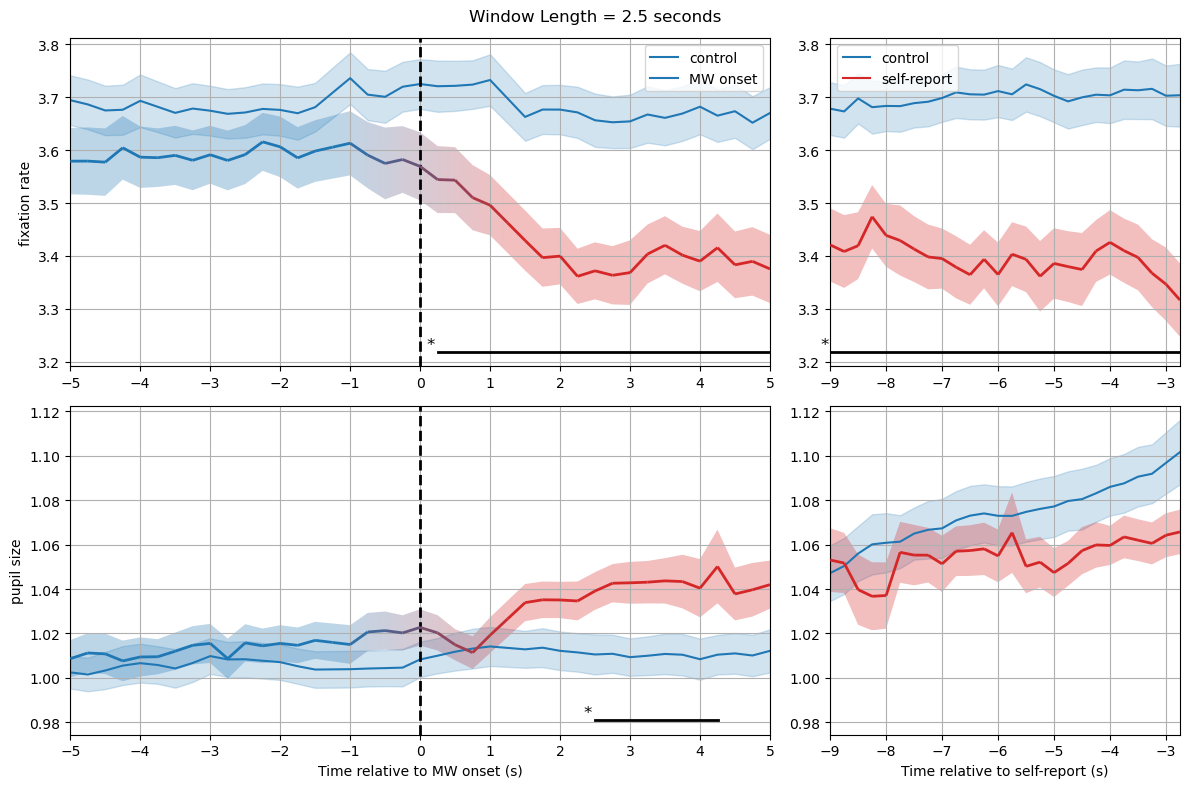

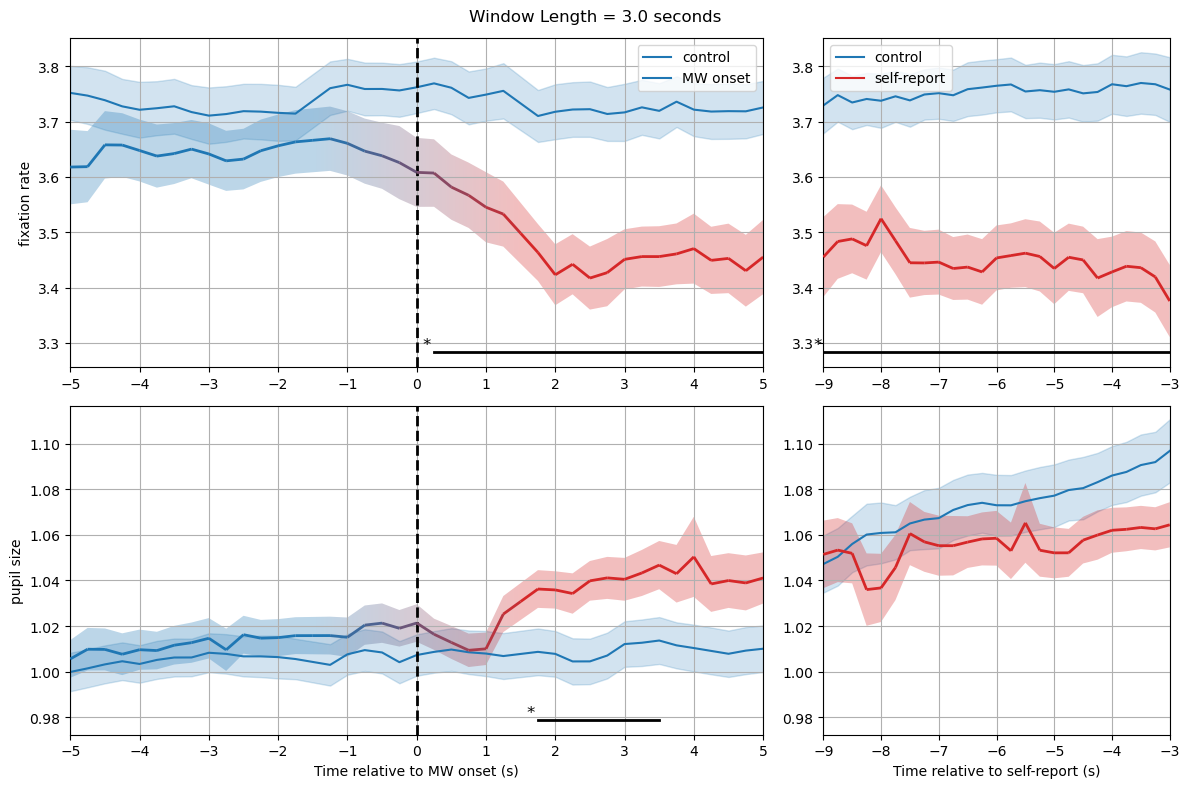

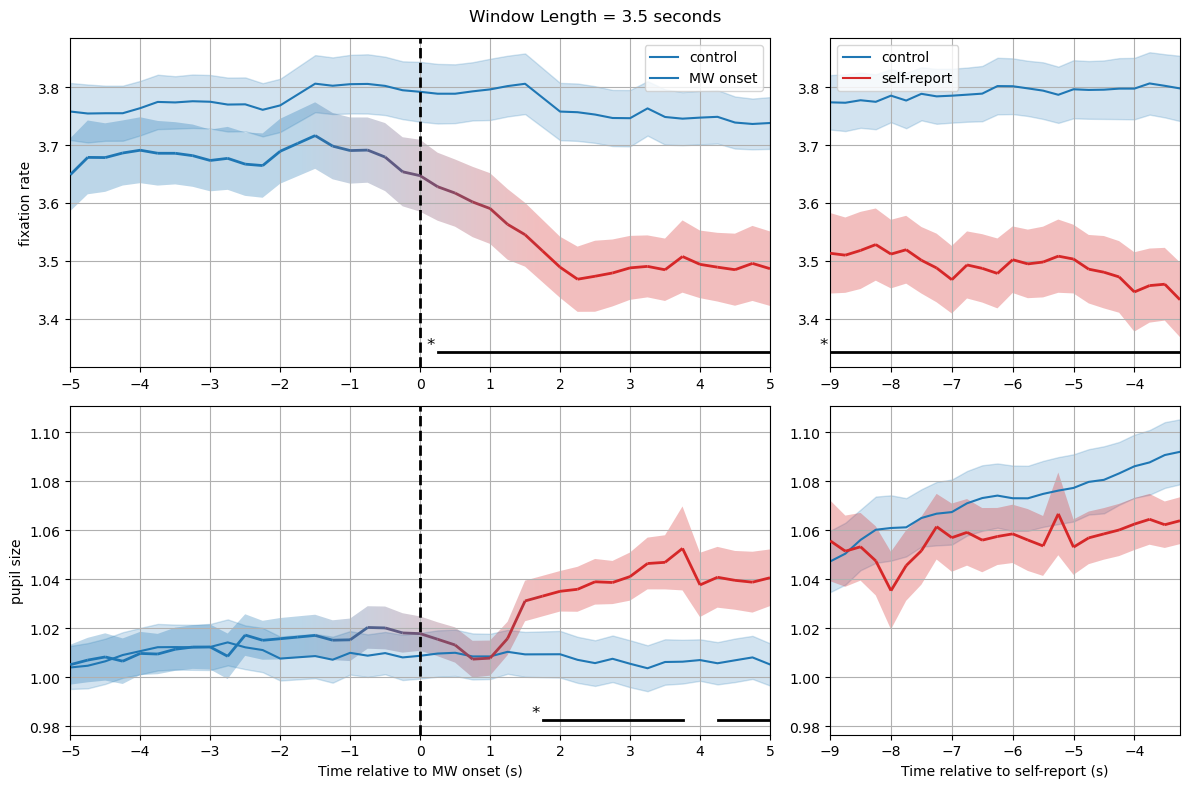

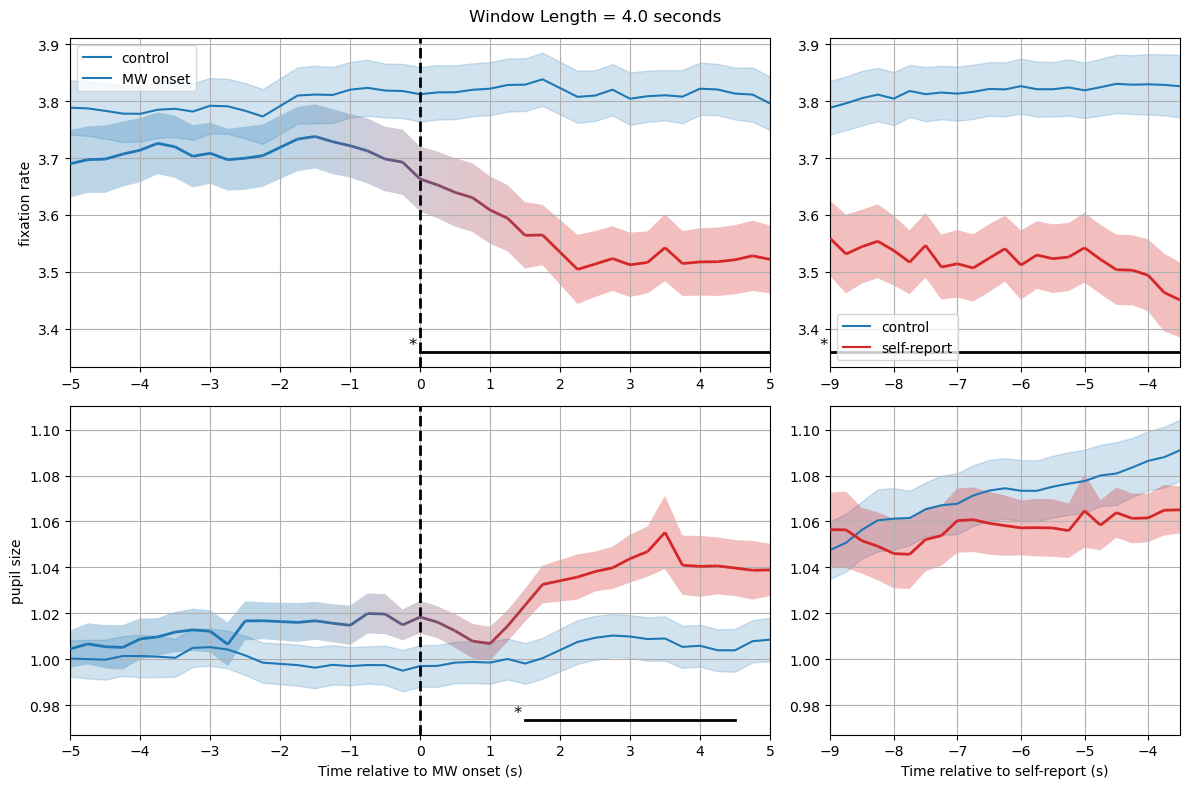

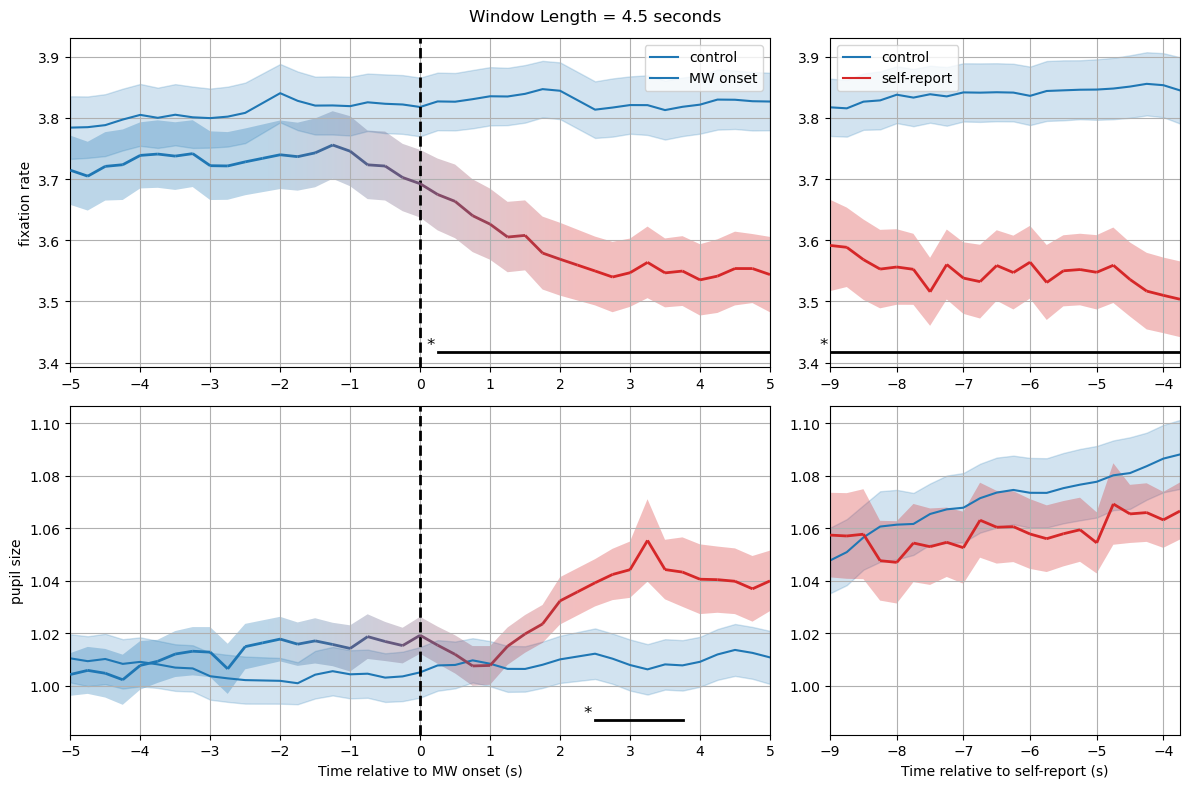

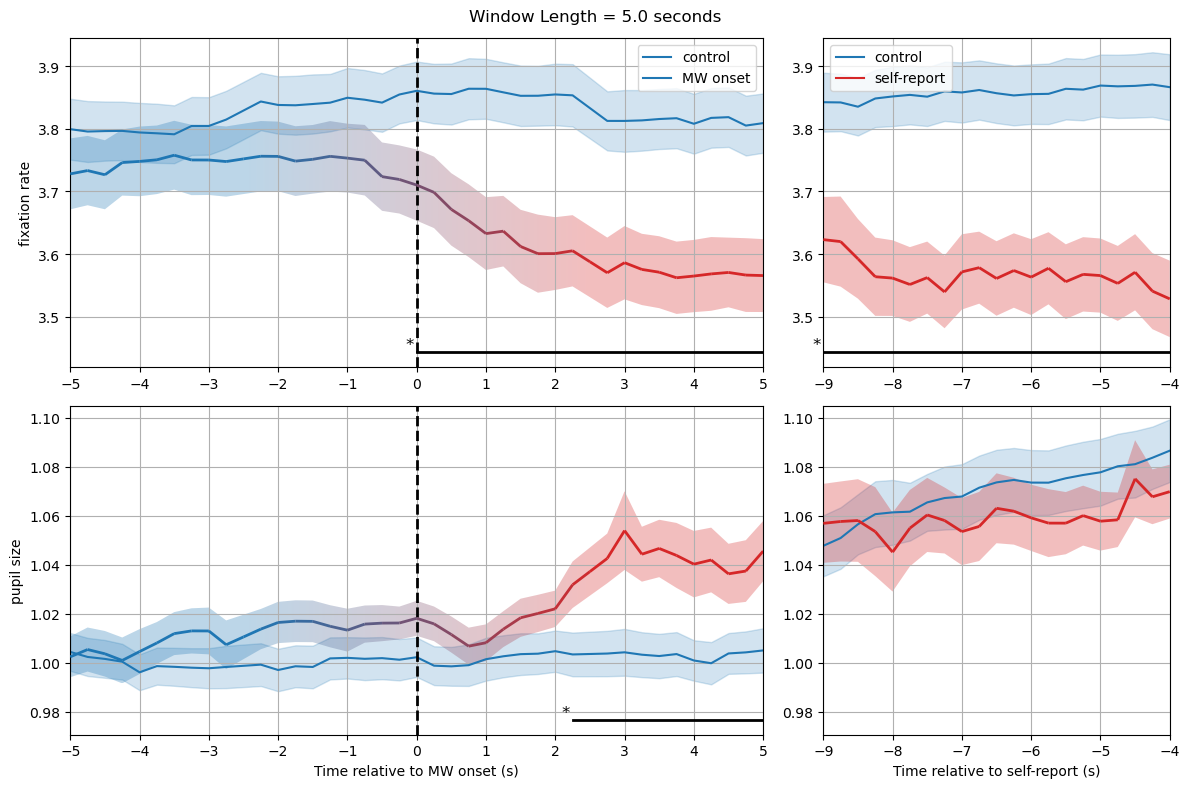

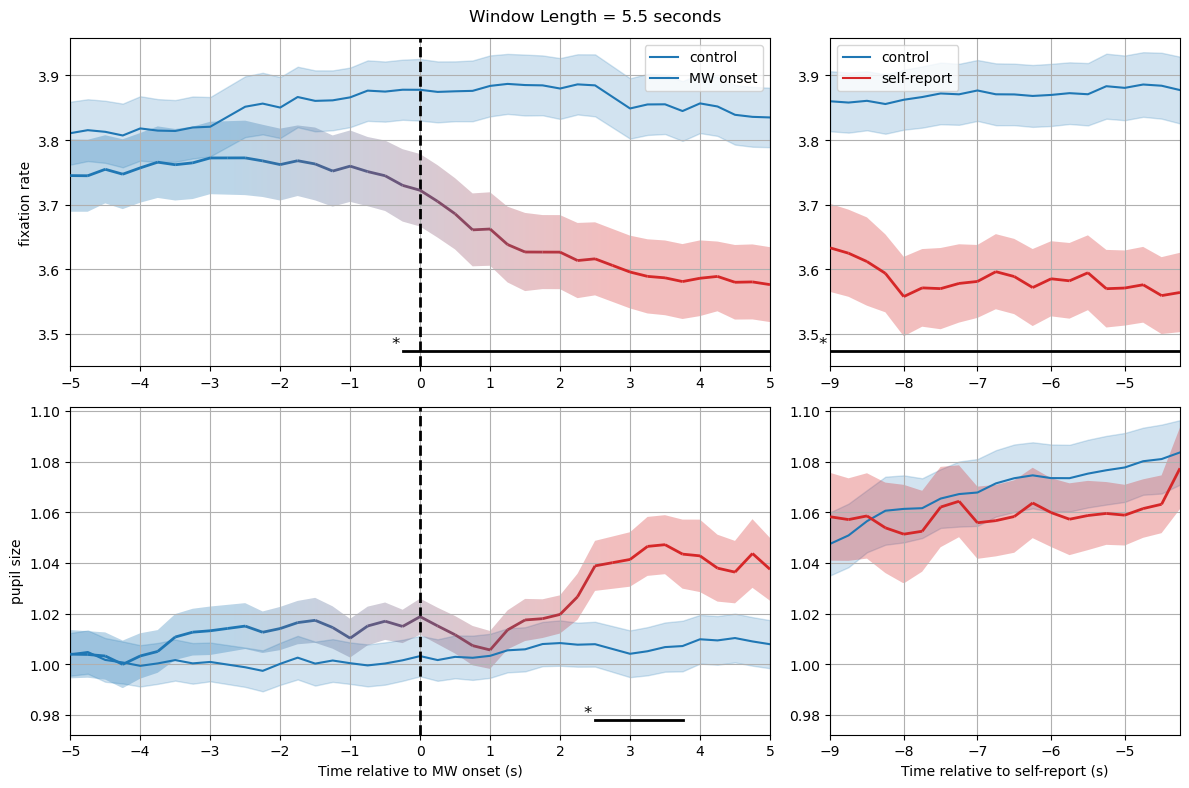

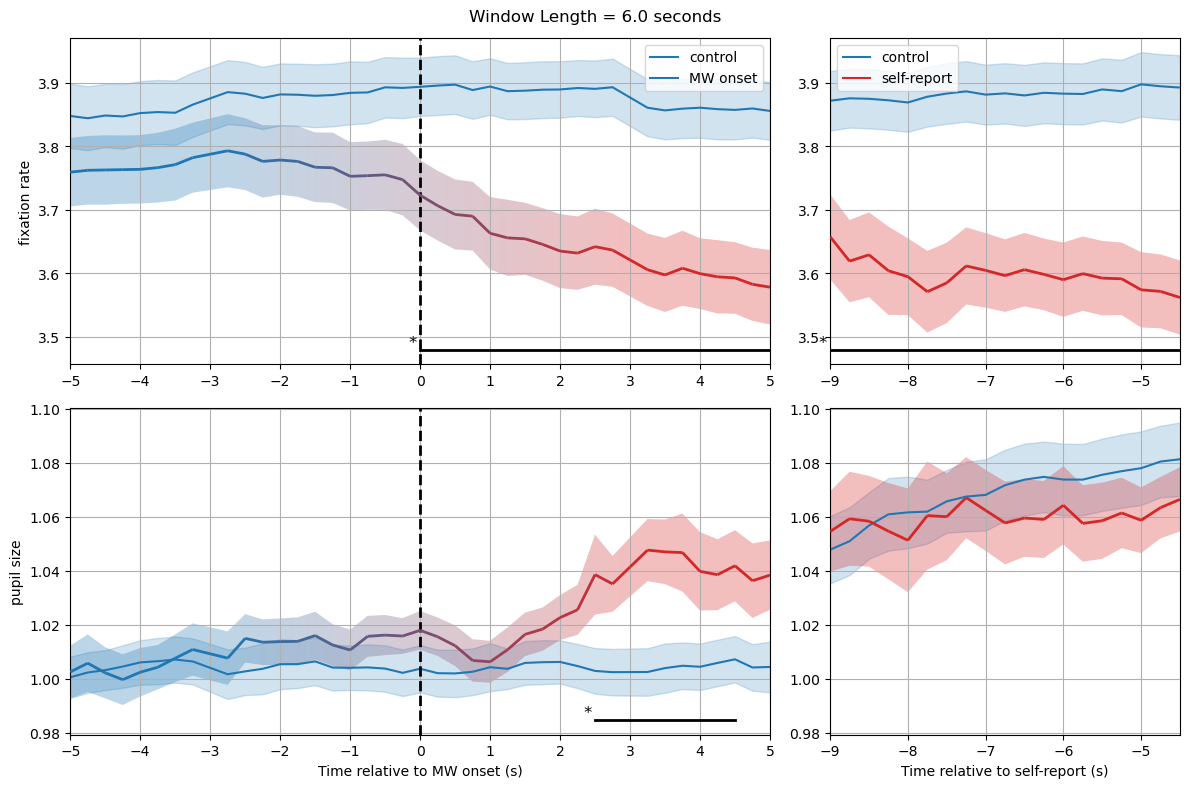

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statannot import add_stat_annotation
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def fill_between_gradient_imshow(ax, x, y1, y2, color_start, color_end, wlen, alpha=0.3, resolution=300):
    x = np.asarray(x)
    y1 = pd.Series(y1).interpolate(method='linear', limit_direction='both').to_numpy()
    y2 = pd.Series(y2).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(y2)
    x, y1, y2 = x[valid], y1[valid], y2[valid]
    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y1, y2 = x[sort_idx], y1[sort_idx], y2[sort_idx]

    cmap = LinearSegmentedColormap.from_list("grad_fill", [color_start, color_end])
    xx = np.linspace(x.min(), x.max(), resolution)
    yy = np.linspace(min(y1.min(), y2.min()), max(y1.max(), y2.max()), resolution)

    # Build horizontal gradient weights: flat on ends, transition between -2.5 to 2.5
    weights = np.zeros_like(xx, dtype=float)
    mask_grad = (xx >= - wlen/2) & (xx <= wlen/2)
    weights[xx > wlen/2] = 1.0
    weights[mask_grad] = (xx[mask_grad] + wlen/2) / wlen

    gradient = np.repeat(weights.reshape(1, -1), resolution, axis=0)

    im = ax.imshow(
        gradient, aspect='auto', extent=[x.min(), x.max(), yy.min(), yy.max()],
        origin='lower', cmap=cmap, alpha=alpha, interpolation='bicubic', zorder=1
    )

    # Create clip path
    verts = np.column_stack([x, y1])
    verts = np.concatenate([verts, np.column_stack([x[::-1], y2[::-1]])])
    path = Path(verts)
    patch = PathPatch(path, facecolor='none', edgecolor='none', zorder=2)
    ax.add_patch(patch)
    im.set_clip_path(patch)
    ax.autoscale_view()
    

def plot_gradient_line(ax, x, y, color_start, color_end, wlen, label=None, linewidth=2, zorder=3):
    x = np.asarray(x)
    y = pd.Series(y).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[valid], y[valid]

    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]

    # Define gradient weights
    weights = np.zeros_like(x, dtype=float)
    mask_grad = (x >= -wlen/2) & (x <= wlen/2)
    weights[x > wlen/2] = 1.0
    weights[mask_grad] = (x[mask_grad] + wlen/2) / wlen  # Normalize [-wlen/2, wlen/2] → [0, 1]

    cmap = LinearSegmentedColormap.from_list("grad", [color_start, color_end])
    colors = cmap(weights)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, colors=colors[:-1], linewidth=linewidth, zorder=zorder)
    ax.add_collection(lc)

    if label:
        ax.plot([], [], color=color_start, label=label)

    ax.autoscale_view()


# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Group/diffwinlen"

# define features to plot
features = [ 'norm_fix_word_num', 'norm_pupil']
# mapping feature names to clean y-axis labels
y_labels = {
    'norm_fix_word_num': 'fixation rate',
    'norm_pupil': 'pupil size'
}

# define the time offset (in seconds) to exclude
alpha = 1.5

for wlen in np.arange(1, 6.5, 0.5):
    # Slide Window (window duration 2 seconds)
    file_name = f'group_features_slide{wlen:.1f}.csv'
    # load group file
    df = pd.read_csv(os.path.join(path, file_name))

    mask = df['page_end']-df['win_end'] >= alpha
    df = df[mask].copy()
    # limit self-report to only MW discourse
    mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
    df = df[~mask].copy()
    df['relative_time'] = df['relative_time'].round(4)

    # Create the figure with a customized gridspec
    fig = plt.figure(figsize=(12, 4 * len(features)))
    gs = GridSpec(len(features), 2, width_ratios=[2, 1], figure=fig)  # column 0 is twice as wide

    for i, feature in enumerate(features):
        # Left plot (MW onset)
        ax0 = fig.add_subplot(gs[i, 0])
        # Right plot (Self-report)
        ax1 = fig.add_subplot(gs[i, 1], sharey=ax0)

        sig_blocks = [[], []]  # store blocks for both conditions (onset, self-report)

        for j, ax, label_control, label_target, color, title in zip(
            [0, 1],
            [ax0, ax1],
            ['control_onset', 'control_sr'],
            ['MW_onset', 'self_report'],
            ['tab:red', 'tab:green'],
            ['MW onset', 'self-report']
        ):
            df_control = df[df['label'] == label_control].copy()
            df_target = df[df['label'] == label_target].copy()

            df_avg_control = (
                df_control.groupby(['sub_id', 'relative_time'])[feature]
                .mean().reset_index()
            )
            df_avg_target = (
                df_target.groupby(['sub_id', 'relative_time'])[feature]
                .mean().reset_index()
            )

            # Statistical test
            timepoints = df_avg_control['relative_time'].unique()
            timepoints.sort()
            p_values = [
                ttest_ind(
                    df_avg_control[df_avg_control['relative_time'] == t][feature],
                    df_avg_target[df_avg_target['relative_time'] == t][feature],
                    equal_var=False
                )[1]
                for t in timepoints
            ]
            # _, p_corrected = fdrcorrection(p_values, alpha=0.05)
            p_corrected = p_values
            sig_times = np.sort(np.array(timepoints)[np.array(p_corrected) < 0.05])

            # Group significant timepoints into blocks
            breaks = np.where(np.diff(sig_times) > 0.25)[0] + 1
            blocks = np.split(sig_times, breaks)
            sig_blocks[j] = blocks

            # Aggregate mean and SEM
            df_plot = (
                df_avg_target
                .groupby(['relative_time'])[feature]
                .agg(['mean', 'sem'])
                .reset_index()
            )

            # Remove edge values for smoothing
            for d in [df_avg_control, df_avg_target]:
                mask = abs(d['relative_time']) == wlen / 2
                d.loc[mask, features] = np.nan
            mask = abs(df_plot['relative_time']) == wlen / 2
            df_plot.loc[mask, ['mean', 'sem']] = np.nan
            

            sns.lineplot(data=df_avg_control, x='relative_time', y=feature,
                        estimator='mean', errorbar='se', err_style='band',
                        color='tab:blue', label='control', ax=ax)
            # sns.lineplot(data=df_avg_target, x='relative_time', y=feature,
            #              estimator='mean', errorbar='se', err_style='band',
            #              color=color, label=title, ax=ax)

        
            x = df_plot['relative_time'].values
            y = df_plot['mean'].values
            y1 = y - df_plot['sem'].values
            y2 = y + df_plot['sem'].values

            # Fill with gradient
            start_color = 'tab:blue' if title == 'MW onset' else 'tab:red'
            end_color = 'tab:red'
            fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

            # Plot gradient line
            plot_gradient_line(ax, x, y, start_color, end_color, wlen, label=title)

            # ax.set_title(title)
            ax.grid()
            if i == 0:
                ax.legend()
            else:
                ax.legend().remove()

        # Consistent y-axis and significance bar
        ymins = [ax0.get_ylim()[0], ax1.get_ylim()[0]]
        ymaxs = [ax0.get_ylim()[1], ax1.get_ylim()[1]]
        ymin, ymax = min(ymins), max(ymaxs)
        offset = (ymax - ymin) * 0.05
        y_sig = ymin - offset
        for ax in [ax0, ax1]:
            ax.set_ylim(y_sig - offset, ymax)
            ax.grid(True)

        # add significance bars for both plots
        is_plotted = False
        for block in sig_blocks[0]:
            if len(block) > 1:
                ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='black', linewidth=2)
                if not is_plotted:
                    ax0.text((block[0]-0.1), y_sig, '*', ha='center', va='bottom', fontsize=12, color='black')
                    is_plotted = True
        
        is_plotted = False
        for block in sig_blocks[1]:
            if len(block) > 1:
                ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='black', linewidth=2)
                if not is_plotted:
                    ax1.text((block[0]-0.1), y_sig, '*', ha='center', va='bottom', fontsize=12, color='black')
                    is_plotted = True
        
        ax0.set_xticks(range(int(-5), int(5) + 1, 1))  # 1-second interval
        ax0.axvline(x=0, color='black', linestyle='--', linewidth=2)
        # Y-label only on left
        ax0.set_ylabel(y_labels.get(feature, feature))
        ax1.set_ylabel("")
        # ax1.set_yticklabels([])

        # X-label only on bottom row
        if i == len(features) - 1:
            ax0.set_xlabel("Time relative to MW onset (s)")
            ax1.set_xlabel("Time relative to self-report (s)")
        else:
            ax0.set_xlabel("")
            ax1.set_xlabel("")

    # Hide the middle spacer column
    for i in range(len(features)):
        fig.add_subplot(gs[i, 1]).axis('off')

    fig.suptitle(f"Window Length = {wlen:.1f} seconds")
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_save, f'win{wlen:.1f}.png'))
    plt.show()



    

# Sigmoid fit on different window

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Define the sigmoid function
def sigmoid(x, L, x0, k, b):
    """
    Four-parameter logistic sigmoid function.
    L: the curve's maximum value
    x0: the x-value of the sigmoid's midpoint
    k: the steepness of the curve
    b: the curve's minimum value
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

# Generate sample data - two signals with one shifted to the right
def generate_sample_data(n_points=100, noise_level=0.05, shift=2.0):
    # Create x values
    x = np.linspace(-10, 10, n_points)
    
    # Create two sigmoid curves, one shifted to the right
    true_params1 = [1.0, 0.0, 1.0, 0.0]  # L, x0, k, b
    true_params2 = [1.0, shift, 1.0, 0.0]  # x0 is shifted by 'shift' units
    
    # Generate y values with some noise
    y1 = sigmoid(x, *true_params1) + np.random.normal(0, noise_level, size=n_points)
    y2 = sigmoid(x, *true_params2) + np.random.normal(0, noise_level, size=n_points)
    
    return x, y1, y2, true_params1, true_params2

# Fit sigmoid curves to the data
def fit_sigmoid(x, y):
    """Fit sigmoid curve to data and return parameters with confidence intervals"""
    # Initial parameter guess [L, x0, k, b]
    p0 = [max(y) - min(y), np.median(x), 1, min(y)]
    
    try:
        # Fit the curve
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        
        # Calculate 95% confidence intervals
        perr = np.sqrt(np.diag(pcov))
        ci = []
        for i, p in enumerate(popt):
            ci.append((p - 1.96 * perr[i], p + 1.96 * perr[i]))
            
        # Calculate goodness of fit
        y_pred = sigmoid(x, *popt)
        r2 = r2_score(y, y_pred)
        
        return popt, ci, r2
    
    except RuntimeError:
        print("Error - curve fit failed")
        return None, None, None

# Perform bootstrap analysis to test for significant difference in midpoint parameter
def bootstrap_comparison(x, y1, y2, n_bootstrap=1000, confidence_level=0.95):
    """
    Use bootstrapping to test if the difference in x0 parameter is significant
    Returns p-value and confidence interval for the difference
    """
    n_points = len(x)
    diff_samples = []
    
    for _ in range(n_bootstrap):
        # Generate bootstrap samples by resampling residuals
        indices = np.random.choice(range(n_points), size=n_points, replace=True)
        x_sample = x[indices]
        y1_sample = y1[indices]
        y2_sample = y2[indices]
        
        # Fit curves to bootstrap samples
        p1, _, _ = fit_sigmoid(x_sample, y1_sample)
        p2, _, _ = fit_sigmoid(x_sample, y2_sample)
        
        if p1 is not None and p2 is not None:
            # Save the difference in midpoint parameters (x0)
            diff_samples.append(p2[1] - p1[1])
    
    # Convert to numpy array
    diff_samples = np.array(diff_samples)
    
    # Calculate p-value (two-tailed test)
    # H0: difference = 0
    p_value = np.mean(diff_samples <= 0) * 2
    if p_value > 1:
        p_value = 2 - p_value
    
    # Calculate confidence interval
    lower_bound = np.percentile(diff_samples, (1 - confidence_level) * 100 / 2)
    upper_bound = np.percentile(diff_samples, 100 - (1 - confidence_level) * 100 / 2)
    
    return p_value, (lower_bound, upper_bound), diff_samples

# Visualize the results
def plot_results(x, y1, y2, popt1, popt2, ci1, ci2, diff_samples=None, title_suffix="", save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Smoothed curves
    x_smooth = np.linspace(min(x), max(x), 1000)
    y1_fit = sigmoid(x_smooth, *popt1)
    y2_fit = sigmoid(x_smooth, *popt2)

    ax1.scatter(x, y1, color='r', alpha=0.5, label='Fixation (std)')
    ax1.scatter(x, y2, color='b', alpha=0.5, label='Pupil (std)')
    ax1.plot(x_smooth, y1_fit, 'r-', linewidth=2, label='Fit Fixation')
    ax1.plot(x_smooth, y2_fit, 'b-', linewidth=2, label='Fit Pupil')
    ax1.axvline(popt1[1], color='r', linestyle='--', alpha=0.5, label=f'Midpoint Fix: {popt1[1]:.2f}')
    ax1.axvline(popt2[1], color='b', linestyle='--', alpha=0.5, label=f'Midpoint Pup: {popt2[1]:.2f}')
    ax1.set_title(f'Sigmoid Fit {title_suffix}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Standardized Signal')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    if diff_samples is not None:
        ax2.hist(diff_samples, bins=30, alpha=0.7, color='green')
        ax2.axvline(0, color='r', linestyle='--', label='No diff')
        ax2.axvline(np.mean(diff_samples), color='blue', label=f'Mean diff: {np.mean(diff_samples):.2f}')
        ci_low, ci_high = np.percentile(diff_samples, [2.5, 97.5])
        ax2.axvline(ci_low, color='green', linestyle=':')
        ax2.axvline(ci_high, color='green', linestyle=':')
        ax2.fill_between([ci_low, ci_high], 0, plt.ylim()[1], alpha=0.2, color='green',
                         label=f'95% CI: [{ci_low:.2f}, {ci_high:.2f}]')
        ax2.set_title("Bootstrap Difference Distribution")
        ax2.set_xlabel("Midpoint Diff (Pupil - Fixation)")
        ax2.set_ylabel("Count")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# Main function to run the analysis
def analyze_sigmoid_shift(x, y1, y2, n_bootstrap=1000):
    """
    Analyze whether there's a significant shift between two signals
    using sigmoid curve fitting.
    
    Parameters:
    x1, y1: First signal's data points
    x2, y2: Second signal's data points
    n_bootstrap: Number of bootstrap samples for statistical testing
    
    Returns:
    Dictionary with analysis results
    """    
    # Fit sigmoid curves to both signals
    print("Fitting sigmoid curves to the signals...")
    popt1, ci1, r2_1 = fit_sigmoid(x, y1)
    popt2, ci2, r2_2 = fit_sigmoid(x, y2)
    
    if popt1 is None or popt2 is None:
        return {"error": "Curve fitting failed"}
    
    # Create results dictionary
    results = {
        "signal1": {
            "parameters": {
                "L (max value)": popt1[0],
                "x0 (midpoint)": popt1[1],
                "k (steepness)": popt1[2],
                "b (min value)": popt1[3]
            },
            "confidence_intervals": {
                "L_ci": ci1[0],
                "x0_ci": ci1[1],
                "k_ci": ci1[2],
                "b_ci": ci1[3]
            },
            "r2": r2_1
        },
        "signal2": {
            "parameters": {
                "L (max value)": popt2[0],
                "x0 (midpoint)": popt2[1],
                "k (steepness)": popt2[2],
                "b (min value)": popt2[3]
            },
            "confidence_intervals": {
                "L_ci": ci2[0],
                "x0_ci": ci2[1],
                "k_ci": ci2[2],
                "b_ci": ci2[3]
            },
            "r2": r2_2
        }
    }
    
    # Calculate the difference in midpoint parameters
    x0_diff = popt2[1] - popt1[1]
    results["midpoint_difference"] = x0_diff
    
    # Simple check if confidence intervals overlap
    ci_overlap = (ci1[1][1] >= ci2[1][0] and ci1[1][0] <= ci2[1][1])
    results["confidence_intervals_overlap"] = ci_overlap
    
    # Perform bootstrap analysis
    print("Running bootstrap analysis to test for significant difference...")
    p_value, ci_diff, diff_samples = bootstrap_comparison(x, y1, y2, n_bootstrap)
    
    results["bootstrap_analysis"] = {
        "p_value": p_value,
        "difference_ci": ci_diff,
        "significant_at_0.05": p_value < 0.05
    }
    
    # Create plots
    plot_results(x, y1, y2, popt1, popt2, ci1, ci2, diff_samples)
    
    return results


# Example for using your own data from CSV files
def analyze_from_csv(signal1_file, signal2_file, x_column, y1_column, y2_column=None):
    """
    Analyze sigmoid shift using data from CSV files.
    
    Parameters:
    signal1_file: Path to CSV file with first signal
    signal2_file: Path to CSV file with second signal (can be the same as signal1_file)
    x_column: Column name for x values
    y1_column: Column name for first signal's y values
    y2_column: Column name for second signal's y values (if in the same file as signal1)
    """
    # Load the first signal
    df1 = pd.read_csv(signal1_file)
    x1 = df1[x_column].values
    y1 = df1[y1_column].values
    
    # Load the second signal (either from the same or different file)
    if y2_column is not None and signal2_file == signal1_file:
        # Both signals are in the same file
        x2 = x1
        y2 = df1[y2_column].values
    else:
        # Signals are in different files
        df2 = pd.read_csv(signal2_file)
        x2 = df2[x_column].values
        y2 = df2[y2_column or y1_column].values
    
    # Make sure x values match between the two signals
    if len(x1) != len(x2) or not np.allclose(x1, x2):
        # Interpolate if necessary
        print("X values don't match. Interpolating second signal to match the first...")
        from scipy.interpolate import interp1d
        f = interp1d(x2, y2, bounds_error=False, fill_value="extrapolate")
        y2 = f(x1)
        x2 = x1
    
    # Perform the analysis
    return analyze_sigmoid_shift(x1, y1, x2, y2, n_bootstrap=1000)

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Group/sigfit"
features = ['norm_fix_word_num', 'norm_pupil']
alpha = 1.5

# Store result rows for dataframe and scatter
all_results = []

for wlen in np.arange(1, 6.5, 0.5):
    file_name = f"group_features_slide{wlen:.1f}.csv"
    file_path = os.path.join(path, file_name)
    if not os.path.exists(file_path):
        continue

    # Load and filter
    df = pd.read_csv(file_path)
    df = df[(df['page_end'] - df['win_end']) >= alpha]
    df = df[~((df['label'] == 'self_report') & (df['win_start'] < df['mw_onset']))]
    df['relative_time'] = df['relative_time'].round(4)

    df_mw = df[df['label'] == 'MW_onset'].copy()
    df_avg = df_mw.groupby('relative_time')[features].mean().reset_index()

    # Standardize features
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_avg[features])
    df_avg['fix_rate_std'], df_avg['pupil_std'] = scaled[:, 0], scaled[:, 1]

    x = df_avg['relative_time'].values
    y1 = df_avg['fix_rate_std'].values
    y2 = df_avg['pupil_std'].values

    # Fit sigmoid
    popt1, ci1, r2_1 = fit_sigmoid(x, y1)
    popt2, ci2, r2_2 = fit_sigmoid(x, y2)

    if popt1 is None or popt2 is None:
        print(f"Skipping wlen={wlen:.1f} due to failed fit.")
        continue

    # Midpoint difference
    x0_diff = popt2[1] - popt1[1]
    ci_overlap = (ci1[1][1] >= ci2[1][0] and ci1[1][0] <= ci2[1][1])

    # Bootstrap significance
    p_value, ci_diff, diff_samples = bootstrap_comparison(x, y1, y2, n_bootstrap=200)

    # Store in list
    all_results.append({
        "wlen": wlen,
        "x0_diff": x0_diff,
        "x0_1": popt1[1],
        "x0_2": popt2[1],
        "x0_1_ci_low": ci1[1][0],
        "x0_1_ci_high": ci1[1][1],
        "x0_2_ci_low": ci2[1][0],
        "x0_2_ci_high": ci2[1][1],
        "r2_1": r2_1,
        "r2_2": r2_2,
        "ci_overlap": ci_overlap,
        "p_value": p_value,
        "ci_diff_low": ci_diff[0],
        "ci_diff_high": ci_diff[1],
        "significant": p_value < 0.05
    })

    plot_results(
    x, y1, y2, popt1, popt2, ci1, ci2, diff_samples,
    title_suffix=f"(wlen={wlen:.1f}s)",
    save_path=os.path.join(path_to_save, f"fit_plot_wlen{wlen:.1f}.png")
    )

# Create DataFrame and save
df_results = pd.DataFrame(all_results)
df_results.to_csv(os.path.join(path_to_save, "diffwin_sigmoid_analysis_results.csv"), index=False)

# Prepare data
X = df_results['wlen'].values.reshape(-1, 1)
y = df_results['x0_diff'].values

# Fit linear model
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='purple', label='DP')
plt.plot(X, y_pred, color='black', linestyle='-', label=f'Linear Fit (R² = {r2:.2f})')

plt.xlabel("Window Length (s)")
plt.ylabel("Midpoint Difference (Pupil - Fixation)")
plt.title("Sigmoid Midpoint Shift Across Window Lengths")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, "sigmoid_midpoint_diff_scatter.png"))
plt.close()



/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

Error - curve fit failed
Error - curve fit failed
Error - curve fit failed
Error - curve fit failed
Error - curve fit failed
Error - curve fit failed


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

Error - curve fit failed
Error - curve fit failed


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/dq/384f3y3d7blcwc_x_w8xb47w0000gp/T/ipykernel_17195/435989204.py:19: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeW

# Sigmoid fit on individuals

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.special import expit  # numerically stable sigmoid

def sigmoid(x, L, x0, k, b):
    """Four-parameter logistic sigmoid using numerically stable expit."""
    return L * expit(k * (x - x0)) + b

# Generate sample data - two signals with one shifted to the right
def generate_sample_data(n_points=100, noise_level=0.05, shift=2.0):
    # Create x values
    x = np.linspace(-10, 10, n_points)
    
    # Create two sigmoid curves, one shifted to the right
    true_params1 = [1.0, 0.0, 1.0, 0.0]  # L, x0, k, b
    true_params2 = [1.0, shift, 1.0, 0.0]  # x0 is shifted by 'shift' units
    
    # Generate y values with some noise
    y1 = sigmoid(x, *true_params1) + np.random.normal(0, noise_level, size=n_points)
    y2 = sigmoid(x, *true_params2) + np.random.normal(0, noise_level, size=n_points)
    
    return x, y1, y2, true_params1, true_params2

# Fit sigmoid curves to the data
def fit_sigmoid(x, y):
    """Fit sigmoid curve to data and return parameters with confidence intervals"""
    # Initial parameter guess [L, x0, k, b]
    p0 = [max(y) - min(y), np.median(x), 1, min(y)]
    
    try:
        # Fit the curve
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        
        # Calculate 95% confidence intervals
        perr = np.sqrt(np.diag(pcov))
        ci = []
        for i, p in enumerate(popt):
            ci.append((p - 1.96 * perr[i], p + 1.96 * perr[i]))
            
        # Calculate goodness of fit
        y_pred = sigmoid(x, *popt)
        r2 = r2_score(y, y_pred)
        
        return popt, ci, r2
    
    except RuntimeError:
        # print("Error - curve fit failed")
        return None, None, None

# Perform bootstrap analysis to test for significant difference in midpoint parameter
def bootstrap_comparison(x, y1, y2, n_bootstrap=1000, confidence_level=0.95):
    """
    Use bootstrapping to test if the difference in x0 parameter is significant
    Returns p-value and confidence interval for the difference
    """
    n_points = len(x)
    diff_samples = []
    
    for _ in range(n_bootstrap):
        # Generate bootstrap samples by resampling residuals
        indices = np.random.choice(range(n_points), size=n_points, replace=True)
        x_sample = x[indices]
        y1_sample = y1[indices]
        y2_sample = y2[indices]
        
        # Fit curves to bootstrap samples
        p1, _, _ = fit_sigmoid(x_sample, y1_sample)
        p2, _, _ = fit_sigmoid(x_sample, y2_sample)
        
        if p1 is not None and p2 is not None:
            # Save the difference in midpoint parameters (x0)
            diff_samples.append(p2[1] - p1[1])
    
    # Convert to numpy array
    diff_samples = np.array(diff_samples)
    
    # Calculate p-value (two-tailed test)
    # H0: difference = 0
    p_value = np.mean(diff_samples <= 0) * 2
    if p_value > 1:
        p_value = 2 - p_value
    
    # Calculate confidence interval
    lower_bound = np.percentile(diff_samples, (1 - confidence_level) * 100 / 2)
    upper_bound = np.percentile(diff_samples, 100 - (1 - confidence_level) * 100 / 2)
    
    return p_value, (lower_bound, upper_bound), diff_samples

# Visualize the results
def plot_results(x, y1, y2, popt1, popt2, ci1, ci2, diff_samples=None, title_suffix="", save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Smoothed curves
    x_smooth = np.linspace(min(x), max(x), 1000)
    y1_fit = sigmoid(x_smooth, *popt1)
    y2_fit = sigmoid(x_smooth, *popt2)

    ax1.scatter(x, y1, color='r', alpha=0.5, label='Fixation (std)')
    ax1.scatter(x, y2, color='b', alpha=0.5, label='Pupil (std)')
    ax1.plot(x_smooth, y1_fit, 'r-', linewidth=2, label='Fit Fixation')
    ax1.plot(x_smooth, y2_fit, 'b-', linewidth=2, label='Fit Pupil')
    ax1.axvline(popt1[1], color='r', linestyle='--', alpha=0.5, label=f'Midpoint Fix: {popt1[1]:.2f}')
    ax1.axvline(popt2[1], color='b', linestyle='--', alpha=0.5, label=f'Midpoint Pup: {popt2[1]:.2f}')
    ax1.set_title(f'Sigmoid Fit {title_suffix}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Standardized Signal')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    if diff_samples is not None:
        ax2.hist(diff_samples, bins=30, alpha=0.7, color='green')
        ax2.axvline(0, color='r', linestyle='--', label='No diff')
        ax2.axvline(np.mean(diff_samples), color='blue', label=f'Mean diff: {np.mean(diff_samples):.2f}')
        ci_low, ci_high = np.percentile(diff_samples, [2.5, 97.5])
        ax2.axvline(ci_low, color='green', linestyle=':')
        ax2.axvline(ci_high, color='green', linestyle=':')
        ax2.fill_between([ci_low, ci_high], 0, plt.ylim()[1], alpha=0.2, color='green',
                         label=f'95% CI: [{ci_low:.2f}, {ci_high:.2f}]')
        ax2.set_title("Bootstrap Difference Distribution")
        ax2.set_xlabel("Midpoint Diff (Pupil - Fixation)")
        ax2.set_ylabel("Count")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# Main function to run the analysis
def analyze_sigmoid_shift(x, y1, y2, n_bootstrap=1000):
    """
    Analyze whether there's a significant shift between two signals
    using sigmoid curve fitting.
    
    Parameters:
    x1, y1: First signal's data points
    x2, y2: Second signal's data points
    n_bootstrap: Number of bootstrap samples for statistical testing
    
    Returns:
    Dictionary with analysis results
    """    
    # Fit sigmoid curves to both signals
    print("Fitting sigmoid curves to the signals...")
    popt1, ci1, r2_1 = fit_sigmoid(x, y1)
    popt2, ci2, r2_2 = fit_sigmoid(x, y2)
    
    if popt1 is None or popt2 is None:
        return {"error": "Curve fitting failed"}
    
    # Create results dictionary
    results = {
        "signal1": {
            "parameters": {
                "L (max value)": popt1[0],
                "x0 (midpoint)": popt1[1],
                "k (steepness)": popt1[2],
                "b (min value)": popt1[3]
            },
            "confidence_intervals": {
                "L_ci": ci1[0],
                "x0_ci": ci1[1],
                "k_ci": ci1[2],
                "b_ci": ci1[3]
            },
            "r2": r2_1
        },
        "signal2": {
            "parameters": {
                "L (max value)": popt2[0],
                "x0 (midpoint)": popt2[1],
                "k (steepness)": popt2[2],
                "b (min value)": popt2[3]
            },
            "confidence_intervals": {
                "L_ci": ci2[0],
                "x0_ci": ci2[1],
                "k_ci": ci2[2],
                "b_ci": ci2[3]
            },
            "r2": r2_2
        }
    }
    
    # Calculate the difference in midpoint parameters
    x0_diff = popt2[1] - popt1[1]
    results["midpoint_difference"] = x0_diff
    
    # Simple check if confidence intervals overlap
    ci_overlap = (ci1[1][1] >= ci2[1][0] and ci1[1][0] <= ci2[1][1])
    results["confidence_intervals_overlap"] = ci_overlap
    
    # Perform bootstrap analysis
    print("Running bootstrap analysis to test for significant difference...")
    p_value, ci_diff, diff_samples = bootstrap_comparison(x, y1, y2, n_bootstrap)
    
    results["bootstrap_analysis"] = {
        "p_value": p_value,
        "difference_ci": ci_diff,
        "significant_at_0.05": p_value < 0.05
    }
    
    # Create plots
    plot_results(x, y1, y2, popt1, popt2, ci1, ci2, diff_samples)
    
    return results


# Example for using your own data from CSV files
def analyze_from_csv(signal1_file, signal2_file, x_column, y1_column, y2_column=None):
    """
    Analyze sigmoid shift using data from CSV files.
    
    Parameters:
    signal1_file: Path to CSV file with first signal
    signal2_file: Path to CSV file with second signal (can be the same as signal1_file)
    x_column: Column name for x values
    y1_column: Column name for first signal's y values
    y2_column: Column name for second signal's y values (if in the same file as signal1)
    """
    # Load the first signal
    df1 = pd.read_csv(signal1_file)
    x1 = df1[x_column].values
    y1 = df1[y1_column].values
    
    # Load the second signal (either from the same or different file)
    if y2_column is not None and signal2_file == signal1_file:
        # Both signals are in the same file
        x2 = x1
        y2 = df1[y2_column].values
    else:
        # Signals are in different files
        df2 = pd.read_csv(signal2_file)
        x2 = df2[x_column].values
        y2 = df2[y2_column or y1_column].values
    
    # Make sure x values match between the two signals
    if len(x1) != len(x2) or not np.allclose(x1, x2):
        # Interpolate if necessary
        print("X values don't match. Interpolating second signal to match the first...")
        from scipy.interpolate import interp1d
        f = interp1d(x2, y2, bounds_error=False, fill_value="extrapolate")
        y2 = f(x1)
        x2 = x1
    
    # Perform the analysis
    return analyze_sigmoid_shift(x1, y1, x2, y2, n_bootstrap=1000)

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
wlen = 2
file_name = f"group_features_slide{wlen:.1f}.csv"
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)

alpha = 1.5
df = df[(df['page_end'] - df['win_end']) >= alpha]
df = df[~((df['label'] == 'self_report') & (df['win_start'] < df['mw_onset']))]
df['relative_time'] = df['relative_time'].round(4)
subs = df['sub_id'].unique()

path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Individual/sigfit"
features = ['norm_fix_word_num', 'norm_pupil']

# Store result rows for dataframe and scatter
all_results = []

for sub in subs:
    df_ = df[df['sub_id']==sub].copy()
    df_mw = df_[df_['label'] == 'MW_onset'].copy()
    df_avg = df_mw.groupby('relative_time')[features].mean().reset_index()

    # Standardize features
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_avg[features])
    df_avg['fix_rate_std'], df_avg['pupil_std'] = scaled[:, 0], scaled[:, 1]

    x = df_avg['relative_time'].values
    y1 = df_avg['fix_rate_std'].values
    y2 = df_avg['pupil_std'].values

    # Fit sigmoid
    popt1, ci1, r2_1 = fit_sigmoid(x, y1)
    popt2, ci2, r2_2 = fit_sigmoid(x, y2)

    if popt1 is None or popt2 is None:
        print(f"Skipping wlen={wlen:.1f} due to failed fit.")
        continue

    # Midpoint difference
    x0_diff = popt2[1] - popt1[1]
    ci_overlap = (ci1[1][1] >= ci2[1][0] and ci1[1][0] <= ci2[1][1])

    # Bootstrap significance
    p_value, ci_diff, diff_samples = bootstrap_comparison(x, y1, y2, n_bootstrap=200)

    # Store in list
    all_results.append({
        "sub": sub,
        "x0_diff": x0_diff,
        "x0_1": popt1[1],
        "x0_2": popt2[1],
        "x0_1_ci_low": ci1[1][0],
        "x0_1_ci_high": ci1[1][1],
        "x0_2_ci_low": ci2[1][0],
        "x0_2_ci_high": ci2[1][1],
        "r2_1": r2_1,
        "r2_2": r2_2,
        "ci_overlap": ci_overlap,
        "p_value": p_value,
        "ci_diff_low": ci_diff[0],
        "ci_diff_high": ci_diff[1],
        "significant": p_value < 0.05
    })

    plot_results(
    x, y1, y2, popt1, popt2, ci1, ci2, diff_samples,
    title_suffix=f"(sub={sub})",
    save_path=os.path.join(path_to_save, f"fit_plot_{sub}.png")
    )

# Create DataFrame and save
df_results = pd.DataFrame(all_results)
df_results.to_csv(os.path.join(path_to_save, "individual_sigmoid_analysis_results.csv"), index=False)

# Prepare data
# X = df_results['wlen'].values.reshape(-1, 1)
# y = df_results['x0_diff'].values

# # Fit linear model
# model = LinearRegression().fit(X, y)
# y_pred = model.predict(X)
# r2 = r2_score(y, y_pred)

# # Plot
# plt.figure(figsize=(8, 5))
# plt.scatter(X, y, color='purple', label='DP')
# plt.plot(X, y_pred, color='black', linestyle='-', label=f'Linear Fit (R² = {r2:.2f})')

# plt.xlabel("Window Length (s)")
# plt.ylabel("Midpoint Difference (Pupil - Fixation)")
# plt.title("Sigmoid Midpoint Shift Across Window Lengths")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.savefig(os.path.join(path_to_save, "sigmoid_midpoint_diff_scatter.png"))
# plt.close()



Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Skipping wlen=2.0 due to failed fit.
Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

Skipping wlen=2.0 due to failed fit.
Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

Skipping wlen=2.0 due to failed fit.


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

# Fix rate and pupil size from different MW

Quartile thresholds:
  Q1: 3.94, Q2: 6.94, Q3: 12.43


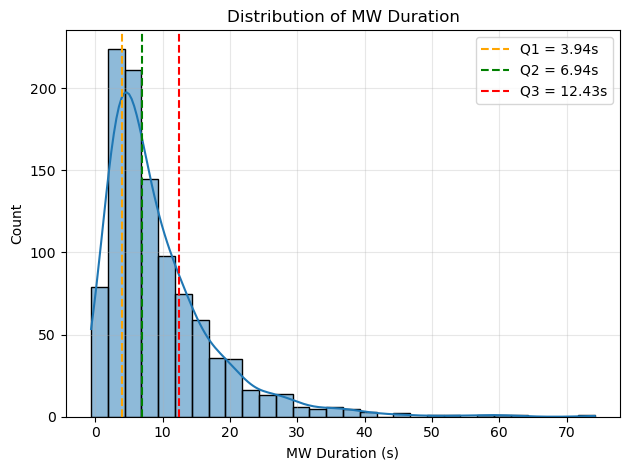

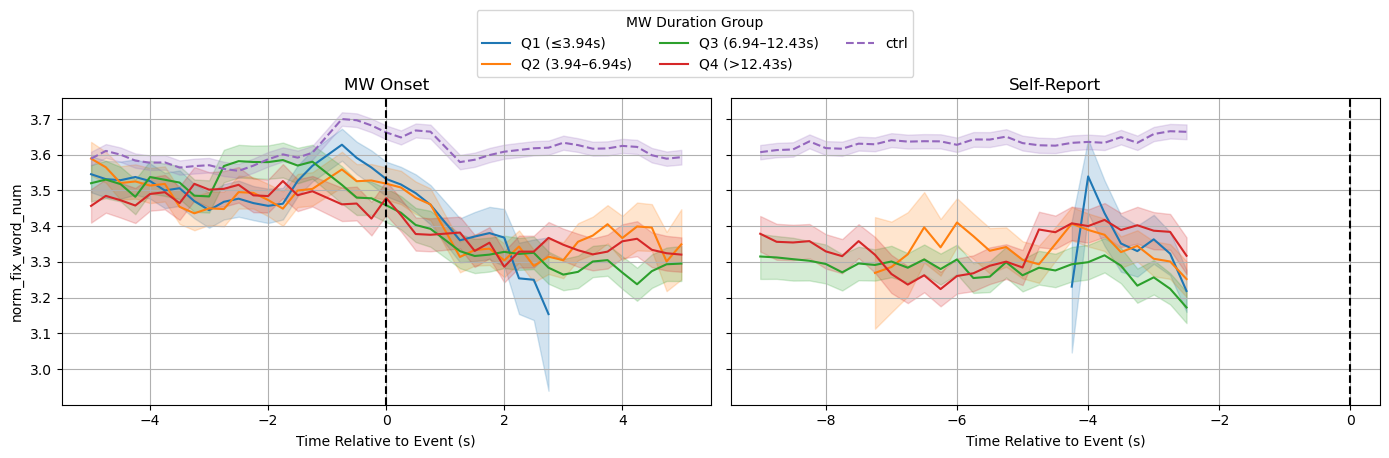

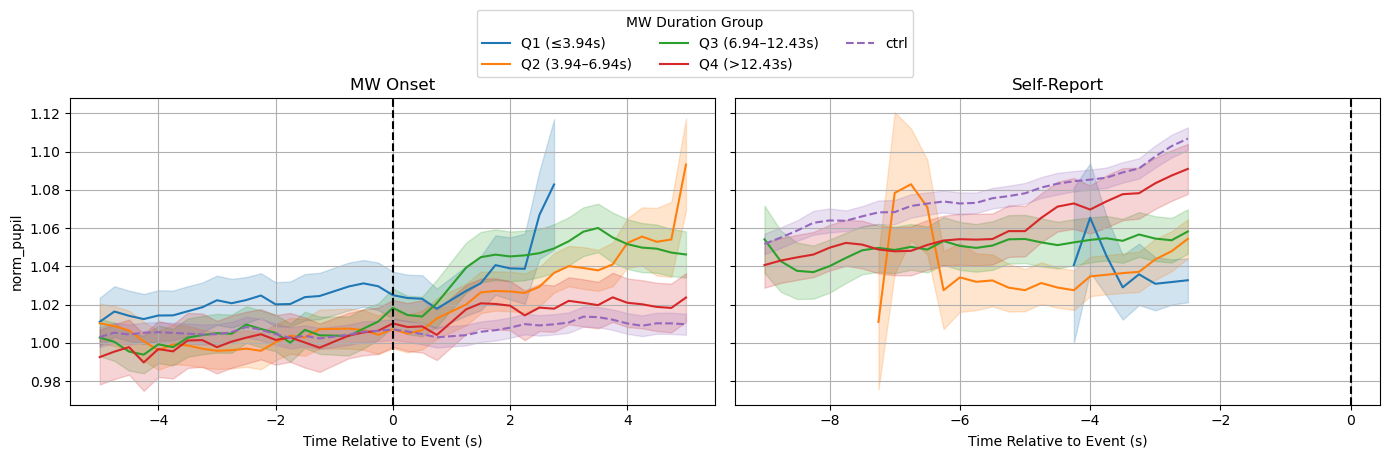

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
import matplotlib.colors as mcolors

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Group/diffwinlen"

# define features to plot
features = [ 'norm_fix_word_num', 'norm_pupil']

# define the time offset (in seconds) to exclude
alpha = 1.5
wlen = 2.0
file_name = f'group_features_slide{wlen:.1f}.csv'
# load group file
df = pd.read_csv(os.path.join(path, file_name))

mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)

# get MW duration distribution
df['mw_dur'] = df['page_end'] - df['mw_onset'] - alpha
df_ = df[df['label'] == 'MW_onset']
df_unique = df_[['run', 'page', 'sub_id', 'mw_dur']].drop_duplicates()

# Get quartiles
q1, q2, q3 = df_unique['mw_dur'].quantile([0.25, 0.5, 0.75])
print(f"Quartile thresholds:\n  Q1: {q1:.2f}, Q2: {q2:.2f}, Q3: {q3:.2f}")

# Plot histogram
plt.figure()
sns.histplot(df_unique['mw_dur'], bins=30, kde=True)

# Plot quartile lines
plt.axvline(q1, color='orange', linestyle='--', label=f'Q1 = {q1:.2f}s')
plt.axvline(q2, color='green', linestyle='--', label=f'Q2 = {q2:.2f}s')
plt.axvline(q3, color='red', linestyle='--', label=f'Q3 = {q3:.2f}s')

# Aesthetic settings
plt.xlabel("MW Duration (s)")
plt.ylabel("Count")
plt.title("Distribution of MW Duration")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Merge mw_dur back into full df
df = df.merge(df_unique, on=['run', 'page', 'sub_id'], how='left', suffixes=('', '_unique'))

# Define readable labels with seconds
q1_label = f"Q1 (≤{q1:.2f}s)"
q2_label = f"Q2 ({q1:.2f}–{q2:.2f}s)"
q3_label = f"Q3 ({q2:.2f}–{q3:.2f}s)"
q4_label = f"Q4 (>{q3:.2f}s)"
hue_order = [q1_label, q2_label, q3_label, q4_label]

def assign_mw_group(dur):
    if dur <= q1:
        return q1_label
    elif dur <= q2:
        return q2_label
    elif dur <= q3:
        return q3_label
    else:
        return q4_label

df['mw_group'] = df['mw_dur'].apply(assign_mw_group)
# Remove edge values for smoothing
mask = abs(df['relative_time']) == wlen / 2
df.loc[mask, features] = np.nan

for feature in features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    for ax, target_label, title in zip(
        [ax1, ax2],
        ['MW_onset', 'self_report'],
        ['MW Onset', 'Self-Report']
    ):
        control_label = 'control_onset' if target_label == 'MW_onset' else 'control_sr'
        # Plot MW groups (solid lines)
        for group in hue_order:
            # Plot MW group
            df_mw = df[(df['label'] == target_label) & (df['mw_group'] == group)]
            sns.lineplot(
                data=df_mw,
                x='relative_time',
                y=feature,
                label=f"{group}",
                errorbar='se',
                ax=ax
            )

        # Plot matching control group
        df_ctrl = df[(df['label'] == control_label)]
        sns.lineplot(
            data=df_ctrl,
            x='relative_time',
            y=feature,
            label=f"ctrl",  # distinct label for legend
            linestyle='--',
            errorbar='se',
            ax=ax
        )

        ax.axvline(0, linestyle='--', color='black')
        ax.set_title(f"{title}")
        ax.set_xlabel("Time Relative to Event (s)")
        if ax is ax1:
            ax.set_ylabel(feature)
        else:
            ax.set_ylabel("")
        ax.legend().remove()
        ax.grid(True)

    # Shared legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title="MW Duration Group", loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15))
    plt.tight_layout()
    plt.show()


# # Define second-based bins
# bins = [0, 1, 2, 3, 4, 5, float('inf')]
# labels = ['0–1s', '1–2s', '2–3s', '3–4s', '4–5s', '>5s']
# df_unique['mw_group'] = pd.cut(df_unique['mw_dur'], bins=bins, labels=labels, right=False)

# # Merge back to main df
# df = df.merge(df_unique[['run', 'page', 'sub_id', 'mw_group']], on=['run', 'page', 'sub_id'], how='left')

# # Plot eye features by MW duration group
# features_to_plot = ['norm_fix_word_num', 'norm_pupil']
# for feature in features_to_plot:
#     plt.figure(figsize=(10, 4))
#     sns.lineplot(
#         data=df[df['label'] == 'MW_onset'],
#         x='relative_time',
#         y=feature,
#         hue='mw_group',
#         palette='Spectral',
#         errorbar='se'
#     )
#     plt.axvline(0, linestyle='--', color='black')
#     plt.title(f"{feature} by MW Duration Group")
#     plt.xlabel("Time Relative to MW Onset (s)")
#     plt.ylabel(feature)
#     plt.legend(title='MW Duration Group', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True)
#     plt.tight_layout()


# Sigmoid fit on different MW length

Fitting sigmoid curves to the signals...
Error - curve fit failed
Fitting sigmoid curves to the signals...
Error - curve fit failed
Fitting sigmoid curves to the signals...
Running bootstrap analysis to test for significant difference...


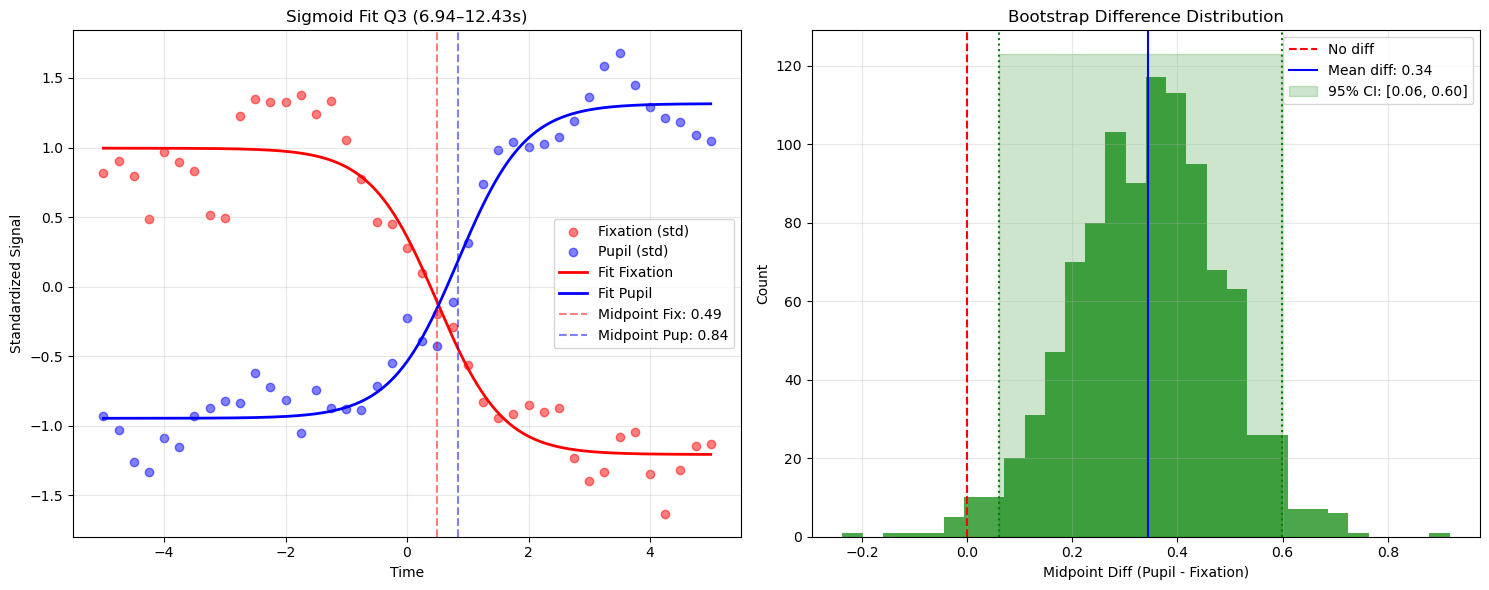

Fitting sigmoid curves to the signals...
Running bootstrap analysis to test for significant difference...
Error - curve fit failed
Error - curve fit failed
Error - curve fit failed
Error - curve fit failed


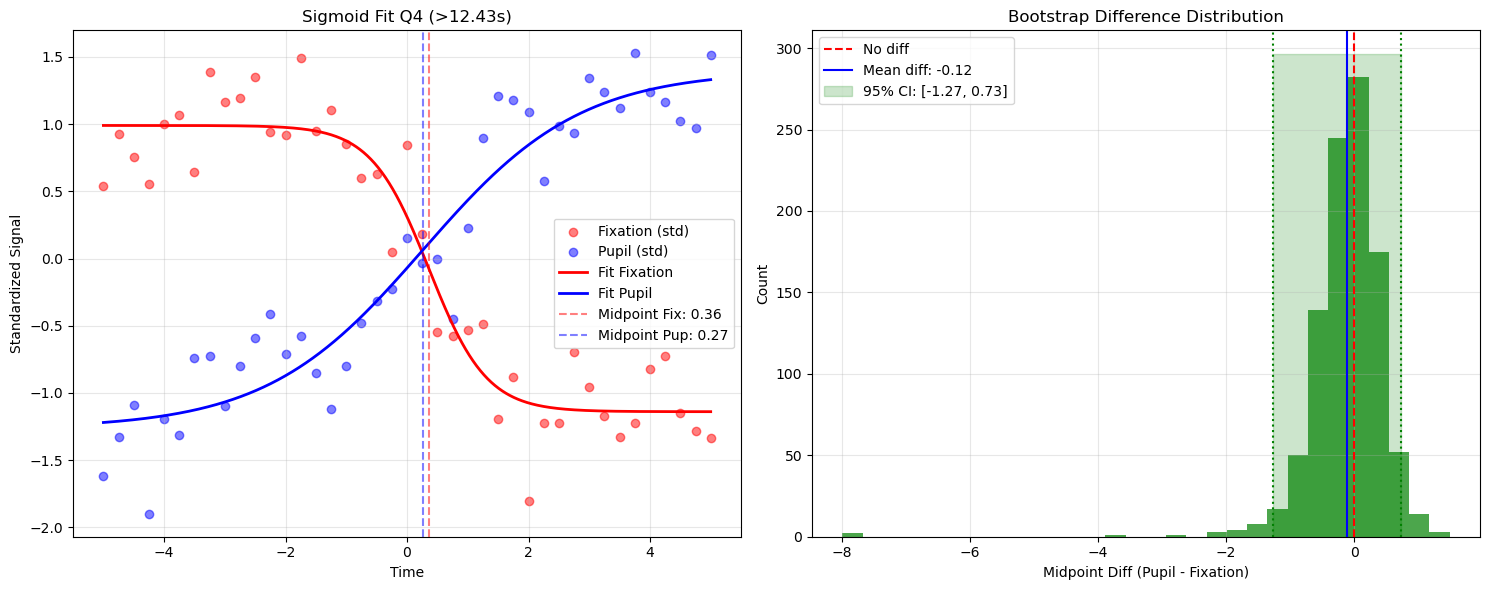

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.special import expit  # numerically stable sigmoid

def sigmoid(x, L, x0, k, b):
    """Four-parameter logistic sigmoid using numerically stable expit."""
    return L * expit(k * (x - x0)) + b

# Fit sigmoid curves to the data
def fit_sigmoid(x, y):
    """Fit sigmoid curve to data and return parameters with confidence intervals"""
    # Initial parameter guess [L, x0, k, b]
    p0 = [max(y) - min(y), np.median(x), 1, min(y)]
    
    try:
        # Fit the curve
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        
        # Calculate 95% confidence intervals
        perr = np.sqrt(np.diag(pcov))
        ci = []
        for i, p in enumerate(popt):
            ci.append((p - 1.96 * perr[i], p + 1.96 * perr[i]))
            
        # Calculate goodness of fit
        y_pred = sigmoid(x, *popt)
        r2 = r2_score(y, y_pred)
        
        return popt, ci, r2
    
    except RuntimeError:
        print("Error - curve fit failed")
        return None, None, None

# Perform bootstrap analysis to test for significant difference in midpoint parameter
def bootstrap_comparison(x, y1, y2, n_bootstrap=1000, confidence_level=0.95):
    """
    Use bootstrapping to test if the difference in x0 parameter is significant
    Returns p-value and confidence interval for the difference
    """
    n_points = len(x)
    diff_samples = []
    
    for _ in range(n_bootstrap):
        # Generate bootstrap samples by resampling residuals
        indices = np.random.choice(range(n_points), size=n_points, replace=True)
        x_sample = x[indices]
        y1_sample = y1[indices]
        y2_sample = y2[indices]
        
        # Fit curves to bootstrap samples
        p1, _, _ = fit_sigmoid(x_sample, y1_sample)
        p2, _, _ = fit_sigmoid(x_sample, y2_sample)
        
        if p1 is not None and p2 is not None:
            # Save the difference in midpoint parameters (x0)
            diff_samples.append(p2[1] - p1[1])
    
    # Convert to numpy array
    diff_samples = np.array(diff_samples)
    
    # Calculate p-value (two-tailed test)
    # H0: difference = 0
    p_value = np.mean(diff_samples <= 0) * 2
    if p_value > 1:
        p_value = 2 - p_value
    
    # Calculate confidence interval
    lower_bound = np.percentile(diff_samples, (1 - confidence_level) * 100 / 2)
    upper_bound = np.percentile(diff_samples, 100 - (1 - confidence_level) * 100 / 2)
    
    return p_value, (lower_bound, upper_bound), diff_samples

# Visualize the results
def plot_results(x, y1, y2, popt1, popt2, ci1, ci2, diff_samples=None, title_suffix="", save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Smoothed curves
    x_smooth = np.linspace(min(x), max(x), 1000)
    y1_fit = sigmoid(x_smooth, *popt1)
    y2_fit = sigmoid(x_smooth, *popt2)

    ax1.scatter(x, y1, color='r', alpha=0.5, label='Fixation (std)')
    ax1.scatter(x, y2, color='b', alpha=0.5, label='Pupil (std)')
    ax1.plot(x_smooth, y1_fit, 'r-', linewidth=2, label='Fit Fixation')
    ax1.plot(x_smooth, y2_fit, 'b-', linewidth=2, label='Fit Pupil')
    ax1.axvline(popt1[1], color='r', linestyle='--', alpha=0.5, label=f'Midpoint Fix: {popt1[1]:.2f}')
    ax1.axvline(popt2[1], color='b', linestyle='--', alpha=0.5, label=f'Midpoint Pup: {popt2[1]:.2f}')
    ax1.set_title(f'Sigmoid Fit {title_suffix}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Standardized Signal')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    if diff_samples is not None:
        ax2.hist(diff_samples, bins=30, alpha=0.7, color='green')
        ax2.axvline(0, color='r', linestyle='--', label='No diff')
        ax2.axvline(np.mean(diff_samples), color='blue', label=f'Mean diff: {np.mean(diff_samples):.2f}')
        ci_low, ci_high = np.percentile(diff_samples, [2.5, 97.5])
        ax2.axvline(ci_low, color='green', linestyle=':')
        ax2.axvline(ci_high, color='green', linestyle=':')
        ax2.fill_between([ci_low, ci_high], 0, plt.ylim()[1], alpha=0.2, color='green',
                         label=f'95% CI: [{ci_low:.2f}, {ci_high:.2f}]')
        ax2.set_title("Bootstrap Difference Distribution")
        ax2.set_xlabel("Midpoint Diff (Pupil - Fixation)")
        ax2.set_ylabel("Count")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# Main function to run the analysis
def analyze_sigmoid_shift(x, y1, y2, title=None, n_bootstrap=1000):
    """
    Analyze whether there's a significant shift between two signals
    using sigmoid curve fitting.
    
    Parameters:
    x1, y1: First signal's data points
    x2, y2: Second signal's data points
    n_bootstrap: Number of bootstrap samples for statistical testing
    
    Returns:
    Dictionary with analysis results
    """    
    # Fit sigmoid curves to both signals
    print("Fitting sigmoid curves to the signals...")
    popt1, ci1, r2_1 = fit_sigmoid(x, y1)
    popt2, ci2, r2_2 = fit_sigmoid(x, y2)
    
    if popt1 is None or popt2 is None:
        return {"error": "Curve fitting failed"}
    
    # Create results dictionary
    results = {
        "signal1": {
            "parameters": {
                "L (max value)": popt1[0],
                "x0 (midpoint)": popt1[1],
                "k (steepness)": popt1[2],
                "b (min value)": popt1[3]
            },
            "confidence_intervals": {
                "L_ci": ci1[0],
                "x0_ci": ci1[1],
                "k_ci": ci1[2],
                "b_ci": ci1[3]
            },
            "r2": r2_1
        },
        "signal2": {
            "parameters": {
                "L (max value)": popt2[0],
                "x0 (midpoint)": popt2[1],
                "k (steepness)": popt2[2],
                "b (min value)": popt2[3]
            },
            "confidence_intervals": {
                "L_ci": ci2[0],
                "x0_ci": ci2[1],
                "k_ci": ci2[2],
                "b_ci": ci2[3]
            },
            "r2": r2_2
        }
    }
    
    # Calculate the difference in midpoint parameters
    x0_diff = popt2[1] - popt1[1]
    results["midpoint_difference"] = x0_diff
    
    # Simple check if confidence intervals overlap
    ci_overlap = (ci1[1][1] >= ci2[1][0] and ci1[1][0] <= ci2[1][1])
    results["confidence_intervals_overlap"] = ci_overlap
    
    # Perform bootstrap analysis
    print("Running bootstrap analysis to test for significant difference...")
    p_value, ci_diff, diff_samples = bootstrap_comparison(x, y1, y2, n_bootstrap)
    
    results["bootstrap_analysis"] = {
        "p_value": p_value,
        "difference_ci": ci_diff,
        "significant_at_0.05": p_value < 0.05
    }
    
    # Create plots
    plot_results(x, y1, y2, popt1, popt2, ci1, ci2, diff_samples, title)
    
    return results

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
# define the time offset (in seconds) to exclude
alpha = 1.5
wlen = 2.0
file_name = f'group_features_slide{wlen:.1f}.csv'
# load group file
df = pd.read_csv(os.path.join(path, file_name))

mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)

# get MW duration distribution
df['mw_dur'] = df['page_end'] - df['mw_onset'] - alpha
df_ = df[df['label'] == 'MW_onset']
df_unique = df_[['run', 'page', 'sub_id', 'mw_dur']].drop_duplicates()
# Merge mw_dur back into full df
df = df.merge(df_unique, on=['run', 'page', 'sub_id'], how='left', suffixes=('', '_unique'))

# Get quartiles
q1, q2, q3 = df_unique['mw_dur'].quantile([0.25, 0.5, 0.75])

labels = [
    f"Q1 (≤{q1:.2f}s)",
    f"Q2 ({q1:.2f}–{q2:.2f}s)",
    f"Q3 ({q2:.2f}–{q3:.2f}s)",
    f"Q4 (>{q3:.2f}s)"
]

def assign_group(dur):
    if dur <= q1:
        return labels[0]
    elif dur <= q2:
        return labels[1]
    elif dur <= q3:
        return labels[2]
    else:
        return labels[3]

df['mw_group'] = df['mw_dur'].apply(assign_mw_group)

# Remove edge values
mask = abs(df['relative_time']) == wlen / 2
df.loc[mask, features] = np.nan

# Analyze each group
output_path = os.path.join(path, "sigmoid_fits_by_group")
os.makedirs(output_path, exist_ok=True)

for group in labels:
    df_group = df[(df['label'] == 'MW_onset') & (df['mw_group'] == group)]
    df_group_avg = df_group.groupby('relative_time')[features].mean().reset_index()
    df_group_avg = df_group_avg.interpolate(method='linear', limit_direction='both')

    x = df_group_avg['relative_time'].values
    y1 = df_group_avg['norm_fix_word_num'].values
    y2 = df_group_avg['norm_pupil'].values

    # Standardize
    scaler = StandardScaler()
    y1_std = scaler.fit_transform(y1.reshape(-1, 1)).flatten()
    y2_std = scaler.fit_transform(y2.reshape(-1, 1)).flatten()

    # Fit and plot
    result = analyze_sigmoid_shift(x, y1_std, y2_std, group, n_bootstrap=1000)






# Sigmoid fit on individual trials

In [19]:
import os
import re
import itertools
import pandas as pd
from glob import glob
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.special import expit  # numerically stable sigmoid
from scipy.interpolate import interp1d
import matplotlib.cm as cm

# Add src folder to path to import utility functions
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
from utils import downsample_data, interpolate_blink

# FUNCTIONS
# ==================================================================================================
def detect_and_interpolate_dips(signal, v_thresh=800, max_duration=0.01, fs=100):
    """
    Detect and interpolate dips in a 1D signal based on velocity (first derivative).

    Parameters:
    - signal (np.ndarray): 1D array of pupil data.
    - drop_thresh (float): Threshold for detecting fast decrease (velocity).
    - rise_thresh (float): Threshold for detecting fast increase (velocity).
    - max_duration (float): Max allowed duration between dip start and end (seconds).
    - fs (int): Sampling rate in Hz (default 100Hz).

    Returns:
    - cleaned_signal (np.ndarray): Signal with interpolated dips.
    - dip_mask (np.ndarray): Boolean array marking dip regions.
    """
    t_sample = np.arange(len(signal)) / fs
    dt = 1 / fs
    margin = 5

    # Velocity
    velocity = np.gradient(signal) / dt

    drop_idxs = np.where(velocity < -v_thresh)[0]
    rise_idxs = np.where(velocity > v_thresh)[0]

    dip_mask = np.zeros_like(signal, dtype=bool)
    used = np.zeros_like(signal, dtype=bool)
    max_samples = int(max_duration * fs)

    for drop_idx in drop_idxs:
        if used[drop_idx]:
            continue

        # Look for rise after drop within max duration
        candidates = rise_idxs[(rise_idxs > drop_idx) & (rise_idxs - drop_idx <= max_samples)]
        if len(candidates) == 0:
            continue

        rise_idx = candidates[0]
        start = max(0, drop_idx - margin)
        end = min(len(dip_mask), rise_idx + margin + 1)

        dip_mask[start:end] = True
        used[start:end] = True

    # Interpolate over dip regions
    cleaned_signal = signal.copy()
    valid = ~dip_mask
    if np.sum(valid) > 1:
        interp_func = interp1d(
            t_sample[valid], signal[valid],
            kind='linear', bounds_error=False, fill_value='extrapolate'
        )
        cleaned_signal[dip_mask] = interp_func(t_sample[dip_mask])

    return cleaned_signal, dip_mask

def remove_outliers(signal, maxdev=2.5, invalid=-1, interpolate=True, mode='auto', allowp=0.05):
    """
    Detects and replaces outliers in a 1D signal using standard deviation, and interpolates over them.

    Parameters:
    - signal (np.ndarray): 1D array of signal values (e.g., pupil size).
    - maxdev (float): Max allowed deviation from mean in SD units (default: 2.5).
    - invalid (float): Placeholder value for invalid entries (default: -1).
    - interpolate (bool): Whether to interpolate over invalids (default: True).
    - mode (str): Interpolation mode ('auto', 'linear', or 'cubic').
    - allowp (float): If SD is less than this proportion of mean, skip outlier removal.

    Returns:
    - np.ndarray: Cleaned (and interpolated) signal.
    """
    if signal.ndim != 1:
        raise ValueError("Signal must be 1D.")

    signal = signal.copy()
    mean_val = np.mean(signal)
    std_val = np.std(signal)

    if std_val < allowp * abs(mean_val):
        return signal  # too stable to meaningfully detect outliers

    # Define outlier bounds
    lower_bound = mean_val - maxdev * std_val
    upper_bound = mean_val + maxdev * std_val

    # Mark outliers with invalid placeholder
    outliers = (signal < lower_bound) | (signal > upper_bound)
    signal[outliers] = invalid

    # Interpolate if requested
    if interpolate:
        # signal = interpolate_missing(signal, mode=mode, invalid=invalid)
        
        x = np.arange(len(signal))
        valid = signal != invalid

        if valid.sum() < 2:
            return signal  # not enough valid points to interpolate

        interp_func = interp1d(
            x[valid], signal[valid], kind='linear',
            bounds_error=False, fill_value='extrapolate'
        )
        signal = interp_func(x)
        
    return signal

def sigmoid(x, L, x0, k, b):
    """Four-parameter logistic sigmoid using numerically stable expit."""
    return L * expit(k * (x - x0)) + b

# Fit sigmoid curves to the data
def fit_sigmoid(x, y):
    """Fit sigmoid curve to data and return parameters with confidence intervals"""
    # Initial parameter guess [L, x0, k, b]
    p0 = [max(y) - min(y), np.median(x), 1, min(y)]
    
    try:
        # Fit the curve
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        
        # Calculate 95% confidence intervals
        perr = np.sqrt(np.diag(pcov))
        ci = []
        for i, p in enumerate(popt):
            ci.append((p - 1.96 * perr[i], p + 1.96 * perr[i]))
            
        # Calculate goodness of fit
        y_pred = sigmoid(x, *popt)
        r2 = r2_score(y, y_pred)
        
        return popt, ci, r2
    except RuntimeError:
        return None, None, None
# ==================================================================================================
# Create color gradients (not full spectrum)
mw_colors = cm.Reds(np.linspace(0.4, 0.85, 10))
ctrl_colors = cm.Blues(np.linspace(0.4, 0.85, 10))

# Use cycle so we can call next()
mw_cycle = itertools.cycle(mw_colors)
ctrl_cycle = itertools.cycle(ctrl_colors)

data_root = r"/Volumes/GBLDrive/MindlessReading/Data"
path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Individual/sigfit_trial"
file_pattern = 'Sample.csv'
eye = 'R'
alpha = 1.5
# Get all subject directories
subject_folders = [f.path for f in os.scandir(data_root) if f.is_dir()]

# Empty list to collect trial-level fit results
fit_results = []

# Iterate over each subject
for subject_folder in subject_folders:
    
    # Extract subject ID
    match = re.search(r's\d{5}', subject_folder)
    if not match:
        continue
    subject_id = match.group(0)

    # Load the subject's default timing and features file
    timing_file = os.path.join(subject_folder, f"{subject_id}_R_features_slide2.0.csv")
    df_timing = pd.read_csv(timing_file)

    # get the median pupil size from all five runs as baseline
    pupil_baseline = df_timing['pupil_baseline'].median()

    # Recursively find all Sample.csv files
    sample_files = glob(os.path.join(subject_folder, '**', f'*{file_pattern}'), recursive=True)

    for sample_file in sample_files:
        df_sample = pd.read_csv(sample_file)
        # Get run number from file path
        file_dir = os.path.dirname(sample_file)
        run_match = re.search(r'_r(\d)_', file_dir)
        run_number = int(run_match.group(1))
        
        # Load blink and saccade files
        blink_files = glob(os.path.join(file_dir, '*_Blink.csv'))
        saccade_files = glob(os.path.join(file_dir, '*_Saccade.csv'))
        df_blink = pd.read_csv(blink_files[0])
        df_saccade = pd.read_csv(saccade_files[0])
        # interpolate the pupil size
        df_sample = interpolate_blink(df_sample, df_blink, df_saccade)

        # downsample both df
        df_sample = downsample_data(df_sample)

        # remove dips
        df_sample[f"{eye}Pupil"], _ = detect_and_interpolate_dips(df_sample[f"{eye}Pupil"])

        # remove outliers
        df_sample[f"{eye}Pupil"] = remove_outliers(df_sample[f"{eye}Pupil"])

        # Convert time to seconds and zero-baseline it
        df_sample["tSample"] = df_sample["tSample"]/1000

        # Extract timing info for this run
        df_run_timing = df_timing[df_timing['run'] == run_number].copy()
        df_run_timing = df_run_timing.drop_duplicates(subset=['page', 'label'], keep='first')

        plt.figure(figsize=(12, 12))
        for _, row in df_run_timing.iterrows():
            label = row['label']
            if label == 'MW_onset':
                win_mid = row['mw_onset']
                mw_dur = row['page_end'] - alpha - row['mw_onset']
                # color = next(mw_cycle)
                color = 'tab:red'
            elif label == 'control_onset':
                win_mid = (row['win_start']+row['win_end'])/2 - row['relative_time']
                mw_dur = np.nan
                # color = next(ctrl_cycle)
                color = 'tab:blue'
            else:
                continue

            win_start = max(win_mid - 5, row['page_start'])
            win_end = min(win_mid + 5, row['page_end'] - alpha)
            if win_start > win_end:
                continue
            win_dur = win_end - win_start

            # Extract data
            mask = (df_sample["tSample"] > win_start) & (df_sample["tSample"] < win_end)
            x = df_sample.loc[mask, "tSample"].values
            y = df_sample.loc[mask, f"{eye}Pupil"].values

            # normalize the pupil size based on individual pupil baseline
            y = y / pupil_baseline
            # center x 
            x = x - win_mid
            # scaler = StandardScaler()
            # y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

            # Fit sigmoid
            popt, ci, r2 = fit_sigmoid(x, y)
            if popt is None:
                continue

            # Save results
            fit_results.append({
                'subject_id': subject_id,
                'run': run_number,
                'mw_dur': mw_dur,
                'win_dur': win_dur,
                'label': row['label'],
                'r2': r2,
                'L': popt[0],
                'x0': popt[1],
                'k': popt[2],
                'b': popt[3]
            })

            # Plot both raw and fit in the same color
            y_fit = sigmoid(x, *popt)
            plt.plot(x, y, '--', color=color, alpha=0.5, label=f'{label} raw')
            plt.plot(x, y_fit, '-', color=color, linewidth=2, label=f'{label} fit')

        plt.axvline(0, linestyle='--', color='black')
        plt.title(f"{subject_id} Run {run_number} | MW Event Sigmoid Fit")
        plt.xlabel("Time (s) relative to MW onset")
        plt.ylabel("Standardized Pupil Size")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        # Add legend after plotting all events in this run
        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        plt.legend(unique.values(), unique.keys())
        plt.savefig(os.path.join(path_to_save, f'{subject_id}_r{run_number}_sigfit.png'))
        plt.close()

# Save all sigmoid fit results to CSV
fit_df = pd.DataFrame(fit_results)
fit_df.to_csv(os.path.join(path_to_save, 'sigmoid_fit_results.csv'), index=False)
    


/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/mindless_reading/lib

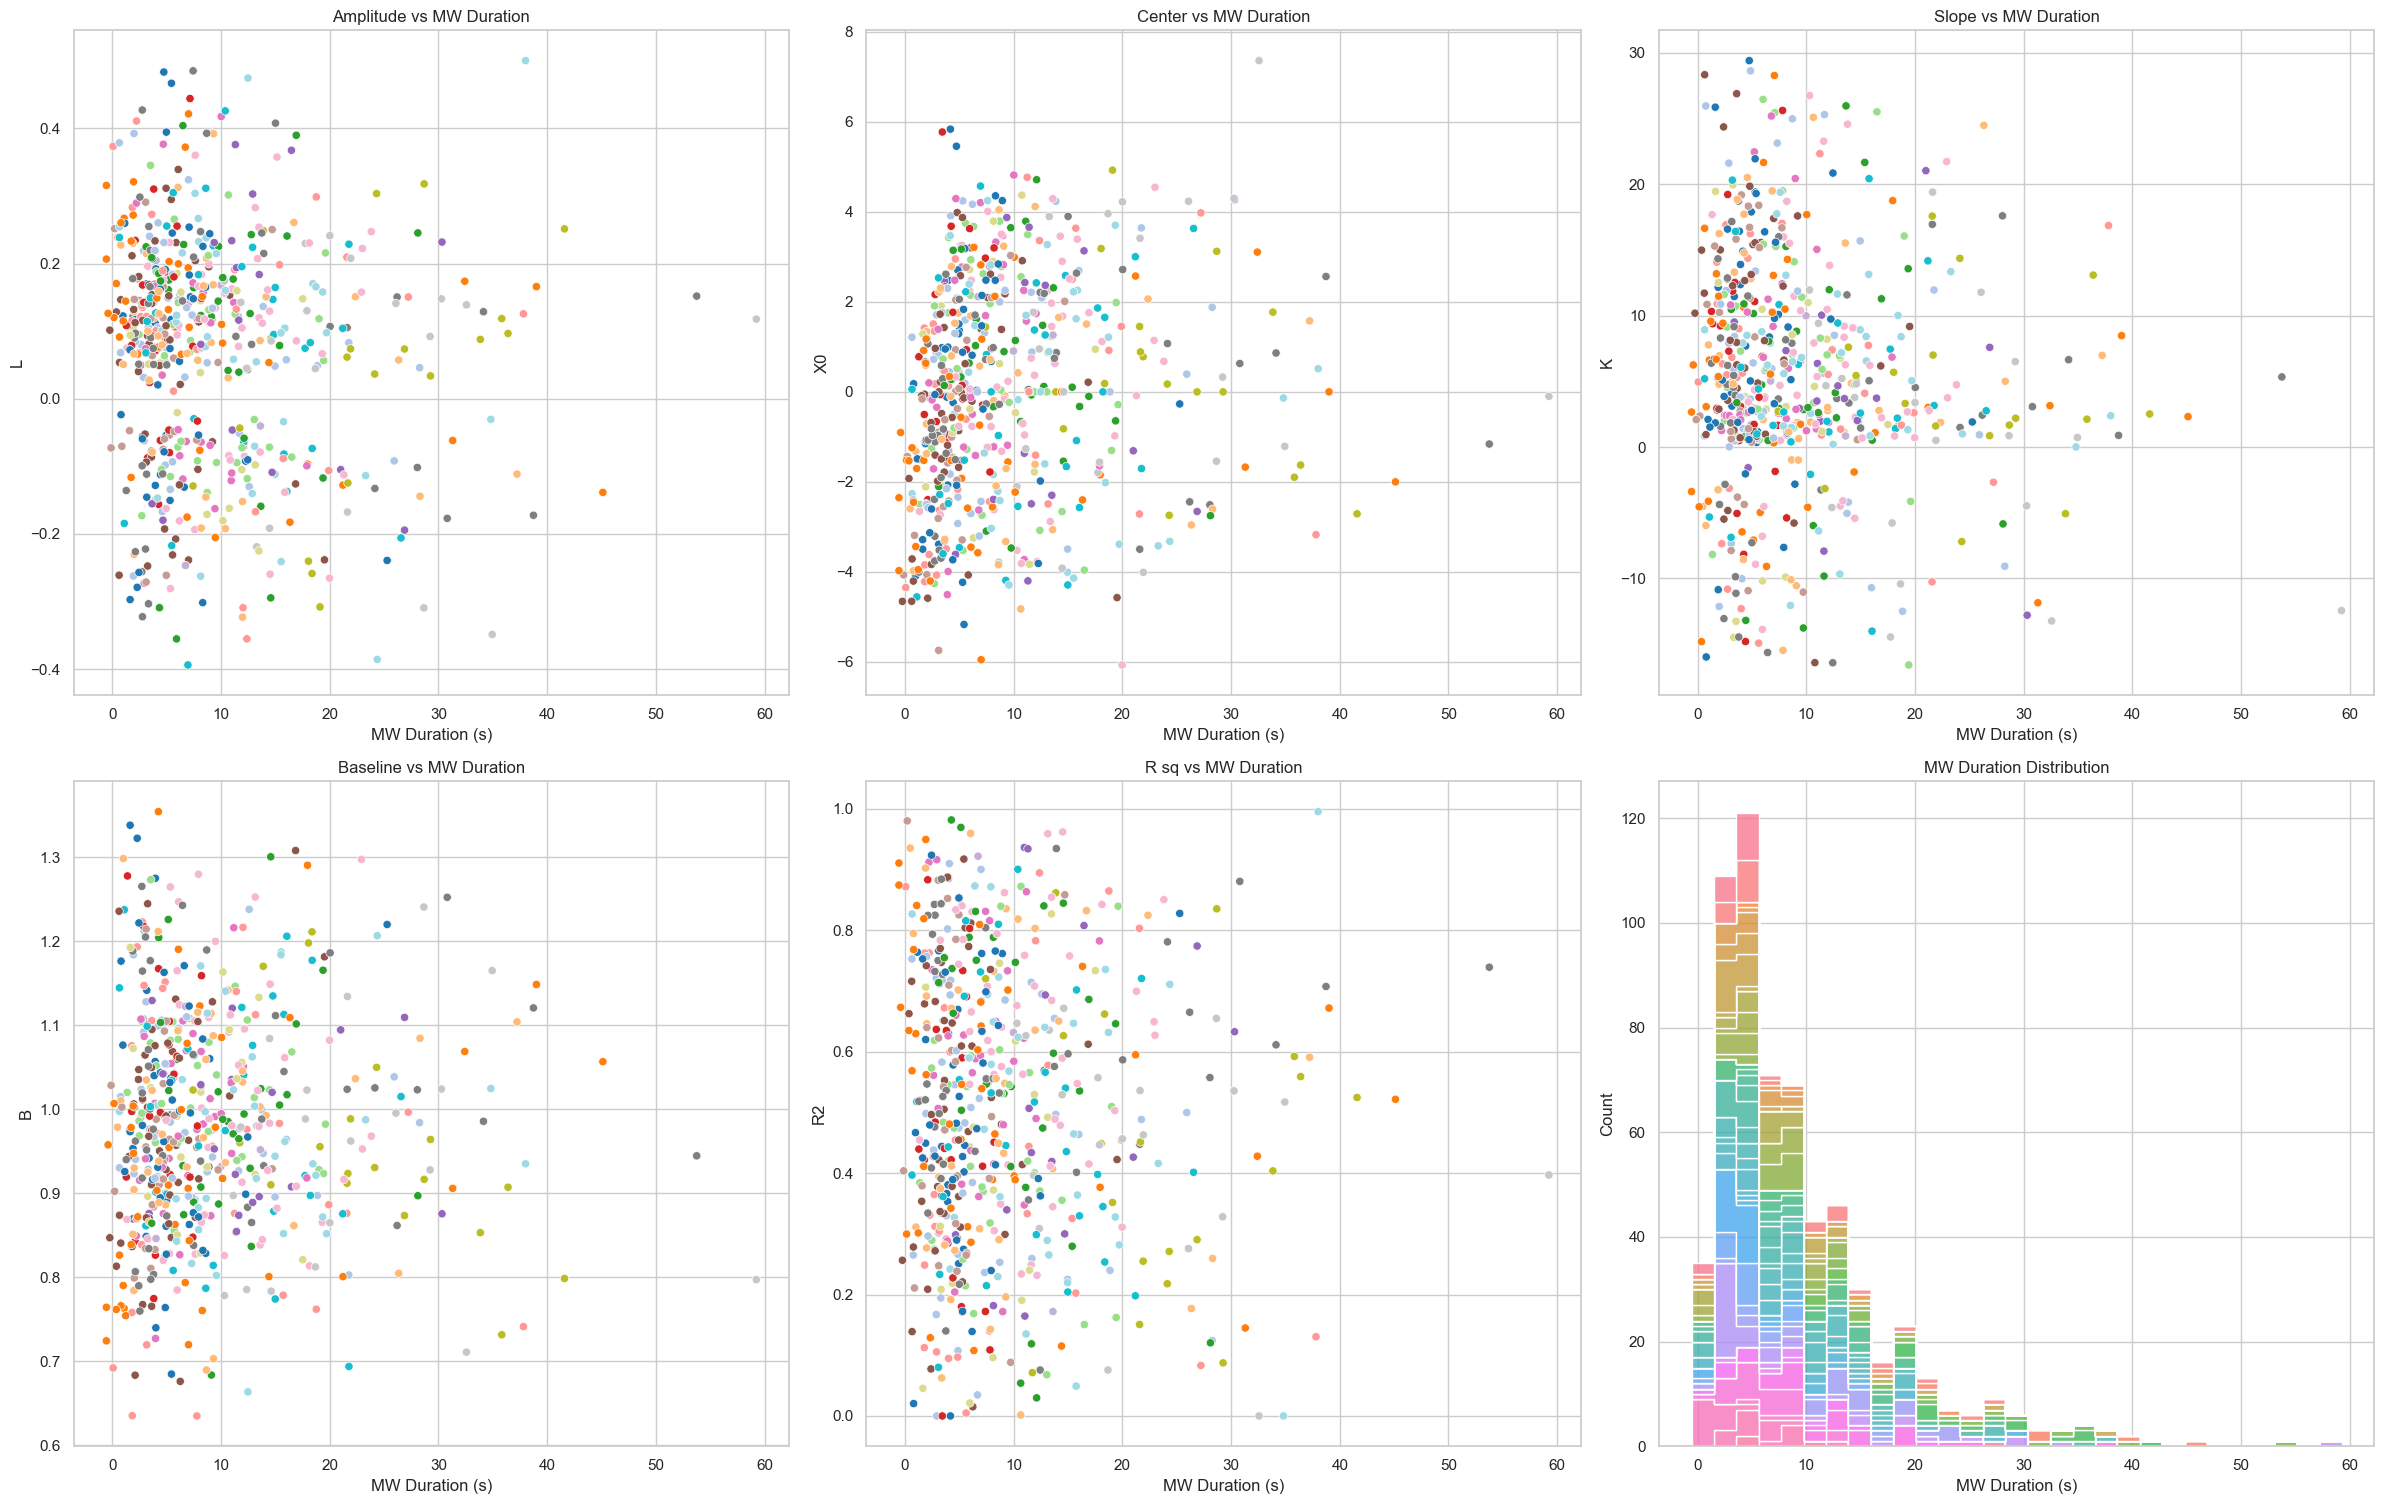

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV
path = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Individual/sigfit_trial"
df_fit = pd.read_csv(os.path.join(path, "sigmoid_fit_results.csv"))

df_fit = df_fit[df_fit['label']=='MW_onset'].copy()

# Remove outliers for L and b using IQR
for param in ["L", "x0", "k", "b"]:
    Q1 = df_fit[param].quantile(0.25)
    Q3 = df_fit[param].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_fit = df_fit[(df_fit[param] >= lower) & (df_fit[param] <= upper)]

# Set figure style
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 3, figsize=(24, 16), sharey=False)
# fig.suptitle("Sigmoid Fit Parameters and R² vs MW Duration", fontsize=18)

# Flatten axis for easier indexing
axs = axs.flatten()

# Define plot settings
plot_settings = [
    ("L", "Amplitude vs MW Duration"),
    ("x0", "Center vs MW Duration"),
    ("k", "Slope vs MW Duration"),
    ("b", "Baseline vs MW Duration"),
    ("r2", "R sq vs MW Duration")
]

# Generate scatter plots
for i, (y_var, title) in enumerate(plot_settings):
    sns.scatterplot(
        data=df_fit, x="mw_dur", y=y_var, hue="subject_id",
        palette="tab20", ax=axs[i], legend=False
    )
    axs[i].set_title(title)
    axs[i].set_xlabel("MW Duration (s)")
    axs[i].set_ylabel(y_var.capitalize())

# Hide the last unused subplot
# Histogram of MW Duration on the last subplot with hue = subject_id, no legend
sns.histplot(
    data=df_fit, x="mw_dur", hue="subject_id", ax=axs[-1], element="step", multiple="stack", legend=False
)
axs[-1].set_title("MW Duration Distribution")
axs[-1].set_xlabel("MW Duration (s)")
axs[-1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

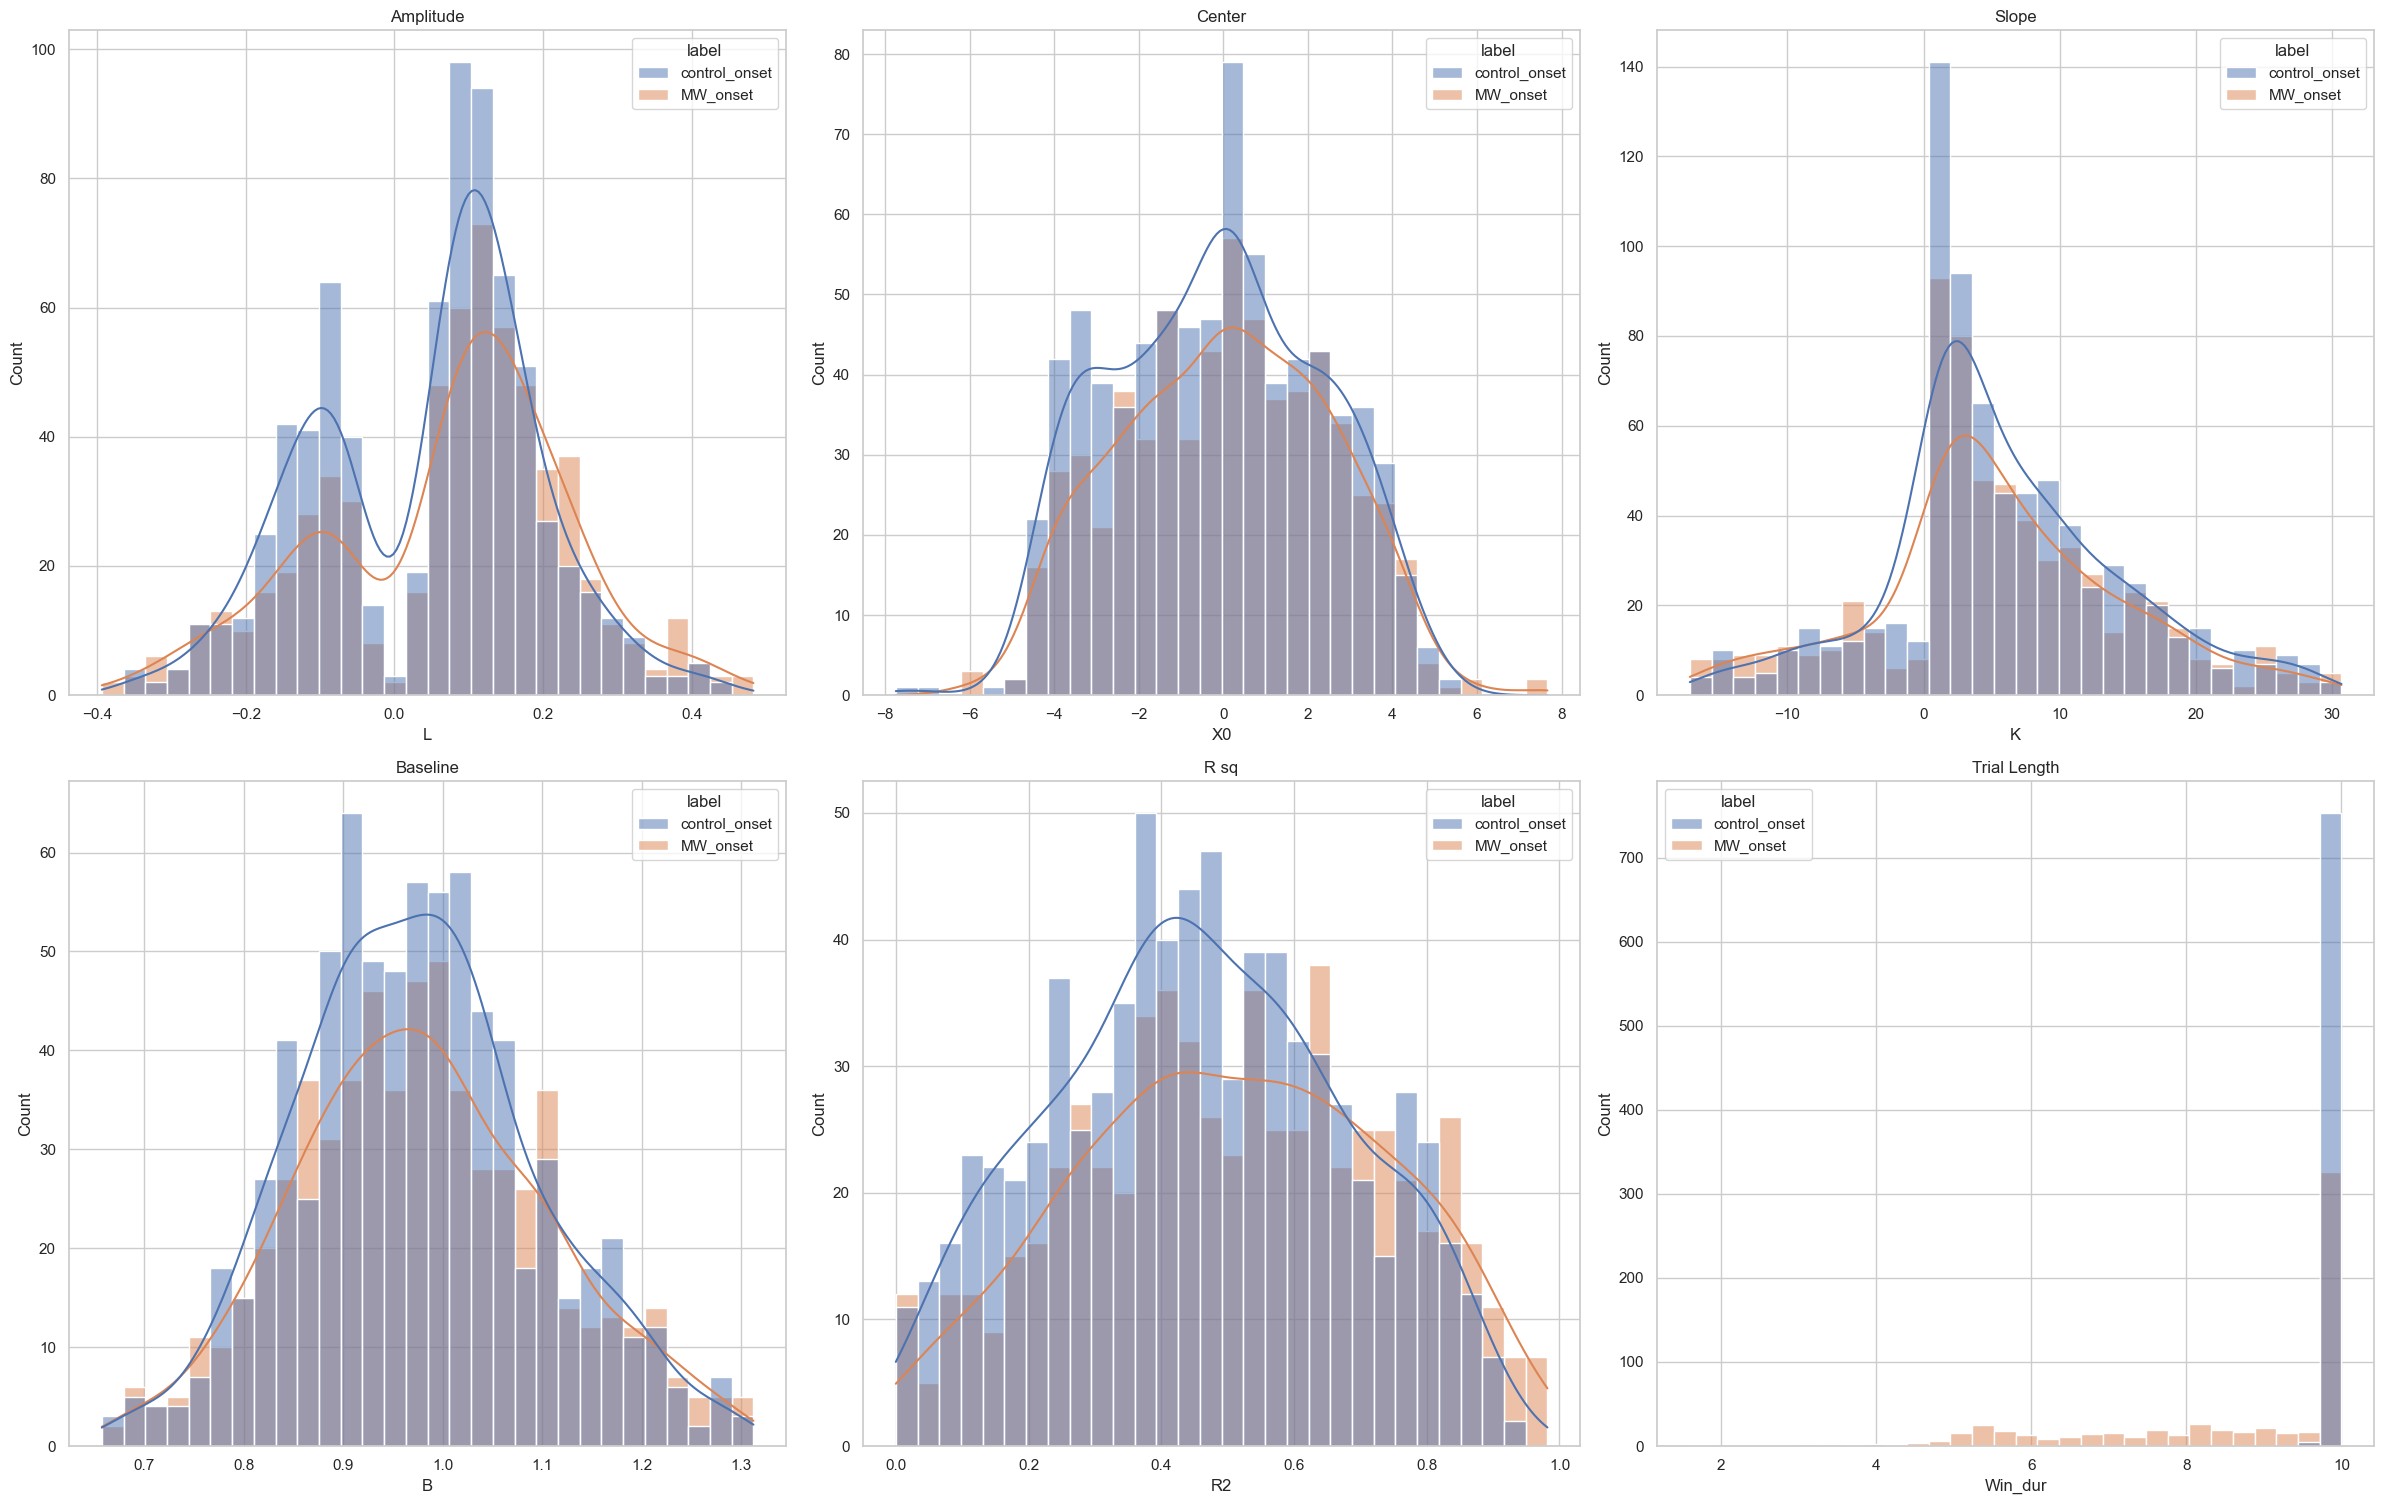

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV
path = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Individual/sigfit_trial"
df_fit = pd.read_csv(os.path.join(path, "sigmoid_fit_results.csv"))

# Remove outliers for L and b using IQR
for param in ["L", "x0", "k", "b"]:
    Q1 = df_fit[param].quantile(0.25)
    Q3 = df_fit[param].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_fit = df_fit[(df_fit[param] >= lower) & (df_fit[param] <= upper)]

# Set figure style
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 3, figsize=(24, 16), sharey=False)
# fig.suptitle("Sigmoid Fit Parameters and R² vs MW Duration", fontsize=18)

# Flatten axis for easier indexing
axs = axs.flatten()

# Define plot settings
plot_settings = [
    ("L", "Amplitude"),
    ("x0", "Center"),
    ("k", "Slope"),
    ("b", "Baseline"),
    ("r2", "R sq"),
    ('win_dur', 'Trial Length')
]

# Generate scatter plots
for i, (x_var, title) in enumerate(plot_settings):
    if x_var == 'win_dur':
        is_kde = False
    else:
        is_kde = True
    sns.histplot(
        data=df_fit,
        x=x_var,
        hue="label",
        ax=axs[i],
        bins=30,                 
        alpha=0.5,                  
        kde=is_kde
    )
    axs[i].set_title(title)
    axs[i].set_ylabel("Count")
    axs[i].set_xlabel(x_var.capitalize())


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

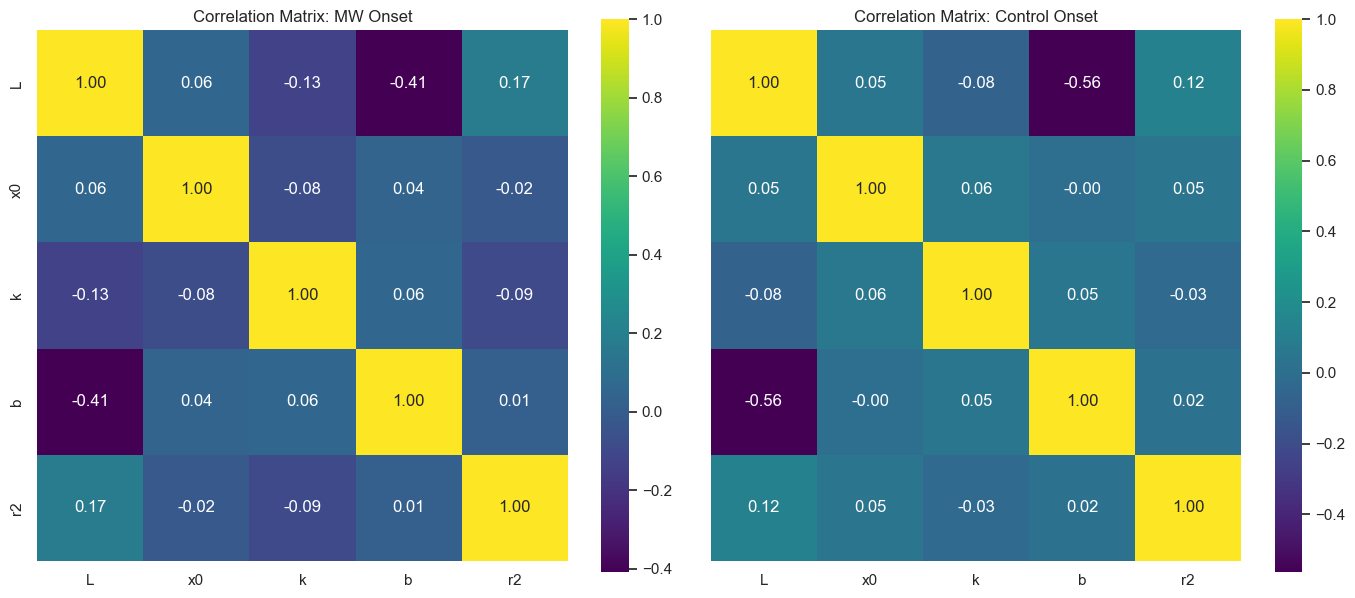

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV
path = r"/Volumes/GBLDrive/MindlessReading/Results/Eye/Individual/sigfit_trial"
df_fit = pd.read_csv(os.path.join(path, "sigmoid_fit_results.csv"))

# Remove outliers for L and b using IQR
for param in ["L", "x0", "k", "b"]:
    Q1 = df_fit[param].quantile(0.25)
    Q3 = df_fit[param].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_fit = df_fit[(df_fit[param] >= lower) & (df_fit[param] <= upper)]

# Filter data by label
df_mw = df_fit[df_fit['label'] == 'MW_onset']
df_control = df_fit[df_fit['label'] == 'control_onset']

# Select sigmoid parameters
params = ["L", "x0", "k", "b", "r2"]

# Compute correlation matrices
corr_mw = df_mw[params].corr()
corr_control = df_control[params].corr()

# Plot side-by-side heatmaps
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.heatmap(corr_mw, annot=True, fmt=".2f", cmap="viridis", square=True, ax=axs[0])
axs[0].set_title("Correlation Matrix: MW Onset")

sns.heatmap(corr_control, annot=True, fmt=".2f", cmap="viridis", square=True, ax=axs[1])
axs[1].set_title("Correlation Matrix: Control Onset")

plt.tight_layout()
plt.show()

# Pupil size on page location

## Percentage time on that page

In [ ]:
import os
import re
import pandas as pd
from glob import glob
import sys
import numpy as np
import pandas as pd

# Add src folder to path to import utility functions
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
from utils import downsample_data, interpolate_blink, detect_and_interpolate_dips

data_root = r"/Volumes/GBLDrive/MindlessReading/Data"
path_to_save = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_pattern = 'Sample.csv'
eye = 'R'
alpha = 2
# Get all subject directories
subject_folders = [f.path for f in os.scandir(data_root) if f.is_dir()]

# Empty list to collect trial-level fit results
fit_results = []

tPage_bins = np.round(np.arange(0, 1.01, 0.01), 2)

df_all = pd.DataFrame()  # To store per-subject averages across all subjects

for subject_folder in subject_folders:
    match = re.search(r's\d{5}', subject_folder)
    if not match:
        continue
    subject_id = match.group(0)

    timing_file = os.path.join(subject_folder, f"{subject_id}_R_features_slide2.0.csv")
    df_timing = pd.read_csv(timing_file)
    pupil_baseline = df_timing['pupil_baseline'].median()

    sample_files = glob(os.path.join(subject_folder, '**', f'*{file_pattern}'), recursive=True)
    df_subject = pd.DataFrame()

    pupil_median_list = []

    for sample_file in sample_files:
        df_sample = pd.read_csv(sample_file)
        file_dir = os.path.dirname(sample_file)
        run_match = re.search(r'_r(\d)_', file_dir)
        run_number = int(run_match.group(1))

        blink_files = glob(os.path.join(file_dir, '*_Blink.csv'))
        saccade_files = glob(os.path.join(file_dir, '*_Saccade.csv'))
        df_blink = pd.read_csv(blink_files[0])
        df_saccade = pd.read_csv(saccade_files[0])

        df_sample = interpolate_blink(df_sample, df_blink, df_saccade)
        df_sample = downsample_data(df_sample)
        df_sample[f"{eye}Pupil"], _ = detect_and_interpolate_dips(df_sample[f"{eye}Pupil"])
        df_sample[f"{eye}Pupil"] = remove_outliers(df_sample[f"{eye}Pupil"])
        df_sample["tSample"] /= 1000
        df_sample['tPage'] = np.nan
        df_sample['is_MW'] = False

        df_run_timing = df_timing[df_timing['run'] == run_number].copy()
        df_run_timing = df_run_timing.drop_duplicates(subset=['page'], keep='first')

        for _, row in df_run_timing.iterrows():
            page_start, page_end = row['page_start'], row['page_end']
            mask = (df_sample['tSample'] >= page_start) & (df_sample['tSample'] <= page_end)
            time = df_sample.loc[mask, 'tSample']
            df_sample.loc[mask, 'tPage'] = (time - time.iloc[0]) / (time.iloc[-1] - time.iloc[0])
                

            # append median pupil size on every page
            pupil_median_list.append(df_sample.loc[mask, f"{eye}Pupil"].median())

            if pd.notna(row['mw_onset']):
                mw_onset = row['mw_onset']
                mw_offset = page_end - alpha
                mw_mask = (df_sample['tSample'] >= mw_onset) & (df_sample['tSample'] <= mw_offset)
                df_sample.loc[mw_mask, 'is_MW'] = True

        df_sample['tPage_bin'] = pd.cut(df_sample['tPage'], bins=tPage_bins, labels=tPage_bins[:-1], include_lowest=True)
        df_sample['tPage_bin'] = df_sample['tPage_bin'].astype(float)

        df_subject = pd.concat([df_subject, df_sample], ignore_index=True)

    # Compute averages per subject across all runs
    df_mw = df_subject[df_subject['is_MW']]
    df_control = df_subject[~df_subject['is_MW']]

    df_avg_mw = df_mw.groupby('tPage_bin').agg(
        RPupil=('RPupil', 'mean')
    ).reset_index()
    df_avg_mw['label'] = 'mw'

    df_avg_control = df_control.groupby('tPage_bin').agg(
        RPupil=('RPupil', 'mean')
    ).reset_index()
    df_avg_control['label'] = 'control'

    df_avg = pd.concat([df_avg_mw, df_avg_control], ignore_index=True)
    df_avg['sub_id'] = subject_id
    
    # normalize the pupil size based on individual pupil baseline
    df_avg['RPupil'] = df_avg['RPupil'] / np.median(pupil_median_list)

    df_all = pd.concat([df_all, df_avg], ignore_index=True)

# save group results to Files folder
df_all.to_csv(os.path.join(path_to_save, 'pupil_size_on_page_time.csv'))

NameError: name 'detect_and_interpolate_dips' is not defined

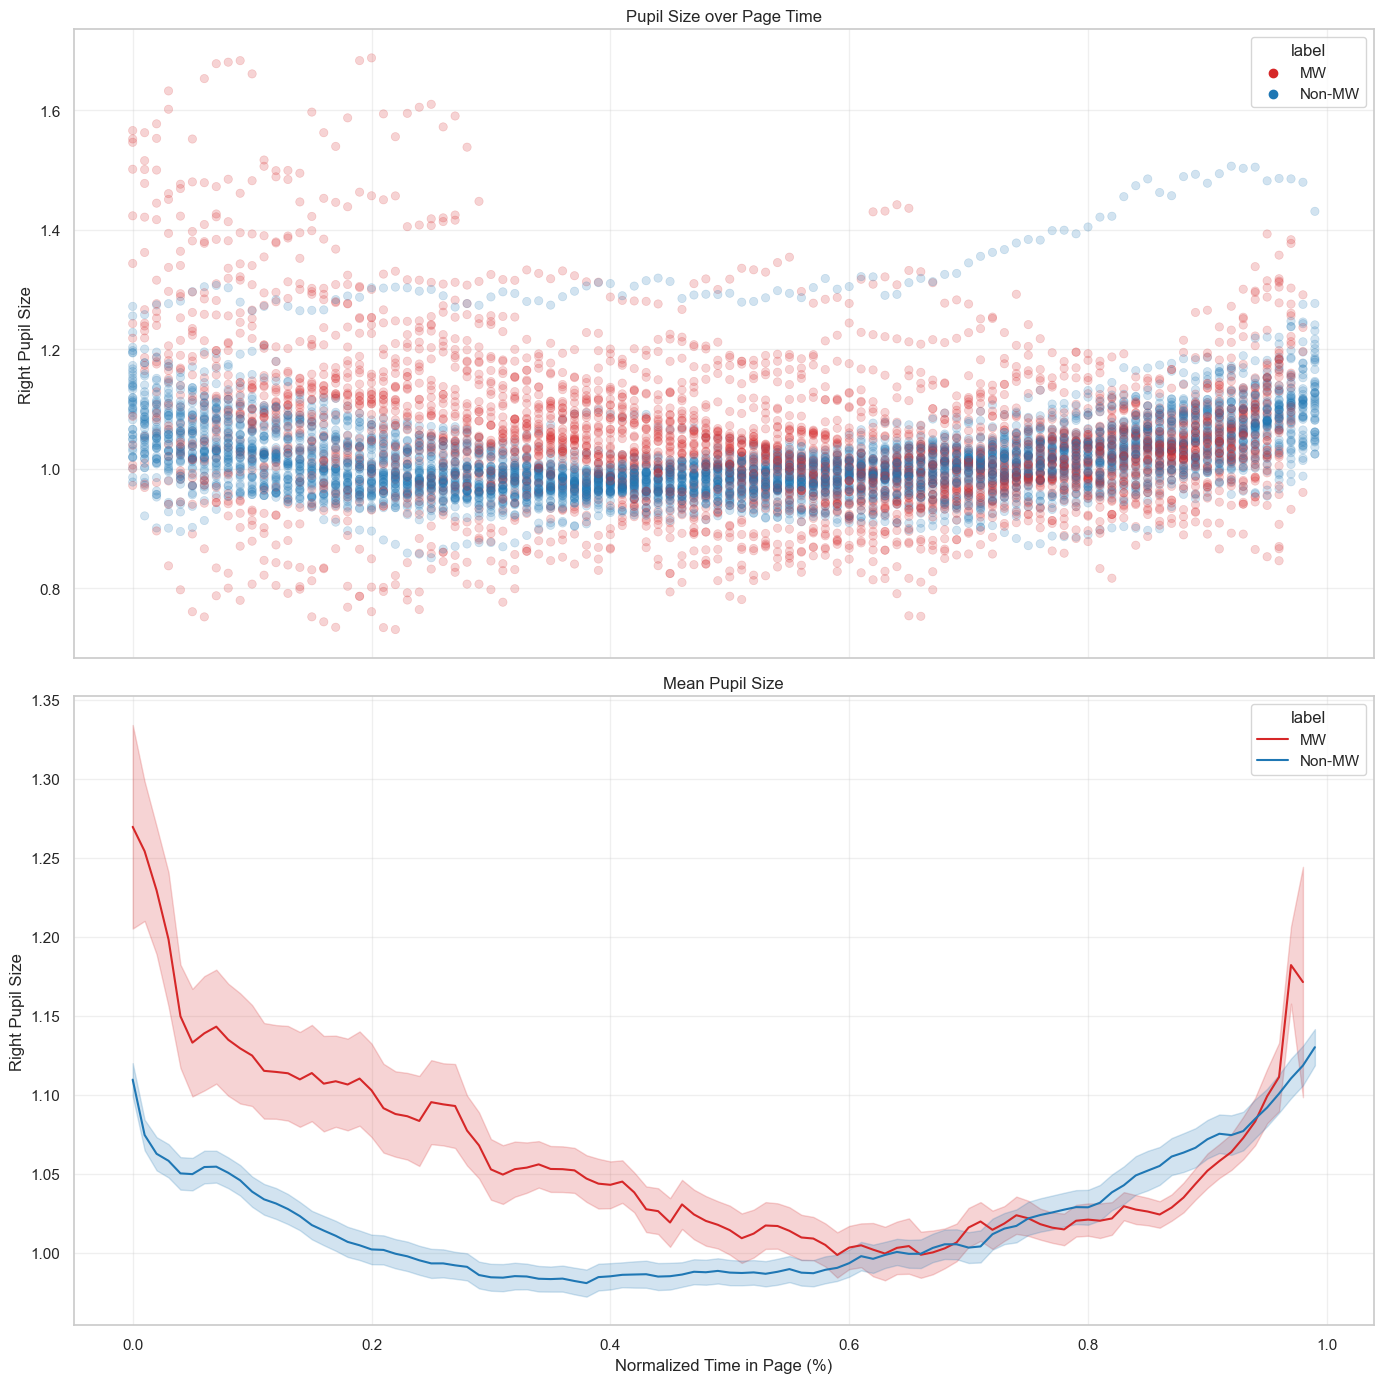

In [72]:
fig, axs = plt.subplots(2, 1, figsize=(14, 14), sharex=True)
palette = {'MW': 'tab:red', 'Non-MW': 'tab:blue'}
# Scatterplot
sns.scatterplot(
    data=df_all, x='tPage_bin', y='RPupil', hue='label',
    palette=palette, alpha=0.2, edgecolor=None, ax=axs[0]
)
axs[0].set_ylabel("Right Pupil Size")
axs[0].set_title("Pupil Size over Page Time")
axs[0].grid(True, alpha=0.3)

# Lineplot with SE bands
df_all = df_all[df_all['RPupil'] <= 1.75]
sns.lineplot(
    data=df_all, x='tPage_bin', y='RPupil', hue='label',
    errorbar='se', ax=axs[1], palette=palette,
)
axs[1].set_xlabel("Normalized Time in Page (%)")
axs[1].set_ylabel("Right Pupil Size")
axs[1].set_title("Mean Pupil Size")
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Y coordinate

In [ ]:
import os
import re
import pandas as pd
from glob import glob
import sys
import numpy as np
import pandas as pd

# Add src folder to path to import utility functions
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
from utils import downsample_data, interpolate_blink

data_root = r"/Volumes/GBLDrive/MindlessReading/Data"
path_to_save = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_pattern = 'Sample.csv'
eye = 'R'
alpha = 2
# Get all subject directories
subject_folders = [f.path for f in os.scandir(data_root) if f.is_dir()]

# Empty list to collect trial-level fit results
fit_results = []

# Generate 16 bins from 0 to 1050 for 16 lines
y_bins = np.round(np.linspace(0, 1050, 17), 2)  

df_all = pd.DataFrame()  # To store per-subject averages across all subjects

for subject_folder in subject_folders:
    match = re.search(r's\d{5}', subject_folder)
    if not match:
        continue
    subject_id = match.group(0)

    timing_file = os.path.join(subject_folder, f"{subject_id}_R_features_slide2.0.csv")
    df_timing = pd.read_csv(timing_file)
    pupil_baseline = df_timing['pupil_baseline'].median()

    sample_files = glob(os.path.join(subject_folder, '**', f'*{file_pattern}'), recursive=True)
    df_subject = pd.DataFrame()

    pupil_median_list = []

    for sample_file in sample_files:
        df_sample = pd.read_csv(sample_file)
        file_dir = os.path.dirname(sample_file)
        run_match = re.search(r'_r(\d)_', file_dir)
        run_number = int(run_match.group(1))

        blink_files = glob(os.path.join(file_dir, '*_Blink.csv'))
        saccade_files = glob(os.path.join(file_dir, '*_Saccade.csv'))
        df_blink = pd.read_csv(blink_files[0])
        df_saccade = pd.read_csv(saccade_files[0])

        df_sample = interpolate_blink(df_sample, df_blink, df_saccade)
        df_sample = downsample_data(df_sample)
        df_sample[f"{eye}Pupil"], _ = detect_and_interpolate_dips(df_sample[f"{eye}Pupil"])
        df_sample[f"{eye}Pupil"] = remove_outliers(df_sample[f"{eye}Pupil"])
        df_sample["tSample"] /= 1000
        df_sample['is_MW'] = False

        df_run_timing = df_timing[df_timing['run'] == run_number].copy()
        df_run_timing = df_run_timing.drop_duplicates(subset=['page'], keep='first')

        for _, row in df_run_timing.iterrows():
            page_start, page_end = row['page_start'], row['page_end']
            mask = (df_sample['tSample'] >= page_start) & (df_sample['tSample'] <= page_end)
            time = df_sample.loc[mask, 'tSample']
                
            # append median pupil size on every page
            pupil_median_list.append(df_sample.loc[mask, f"{eye}Pupil"].median())

            if pd.notna(row['mw_onset']):
                mw_onset = row['mw_onset']
                mw_offset = page_end - alpha
                mw_mask = (df_sample['tSample'] >= mw_onset) & (df_sample['tSample'] <= mw_offset)
                df_sample.loc[mw_mask, 'is_MW'] = True

        df_sample['y_bin'] = pd.cut(df_sample['RY'], bins=y_bins, labels=y_bins[:-1], include_lowest=True)
        df_sample['y_bin'] = df_sample['y_bin'].astype(float)

        df_subject = pd.concat([df_subject, df_sample], ignore_index=True)

    # Compute averages per subject across all runs
    df_mw = df_subject[df_subject['is_MW']]
    df_control = df_subject[~df_subject['is_MW']]

    df_avg_mw = df_mw.groupby('y_bin').agg(
        RPupil=('RPupil', 'mean')
    ).reset_index()
    df_avg_mw['label'] = 'mw'

    df_avg_control = df_control.groupby('y_bin').agg(
        RPupil=('RPupil', 'mean')
    ).reset_index()
    df_avg_control['label'] = 'control'

    df_avg = pd.concat([df_avg_mw, df_avg_control], ignore_index=True)
    df_avg['sub_id'] = subject_id
    
    # normalize the pupil size based on individual pupil baseline
    df_avg['RPupil'] = df_avg['RPupil'] / np.median(pupil_median_list)

    df_all = pd.concat([df_all, df_avg], ignore_index=True)

# save group results to Files folder
df_all.to_csv(os.path.join(path_to_save, 'pupil_size_on_page_y.csv'))



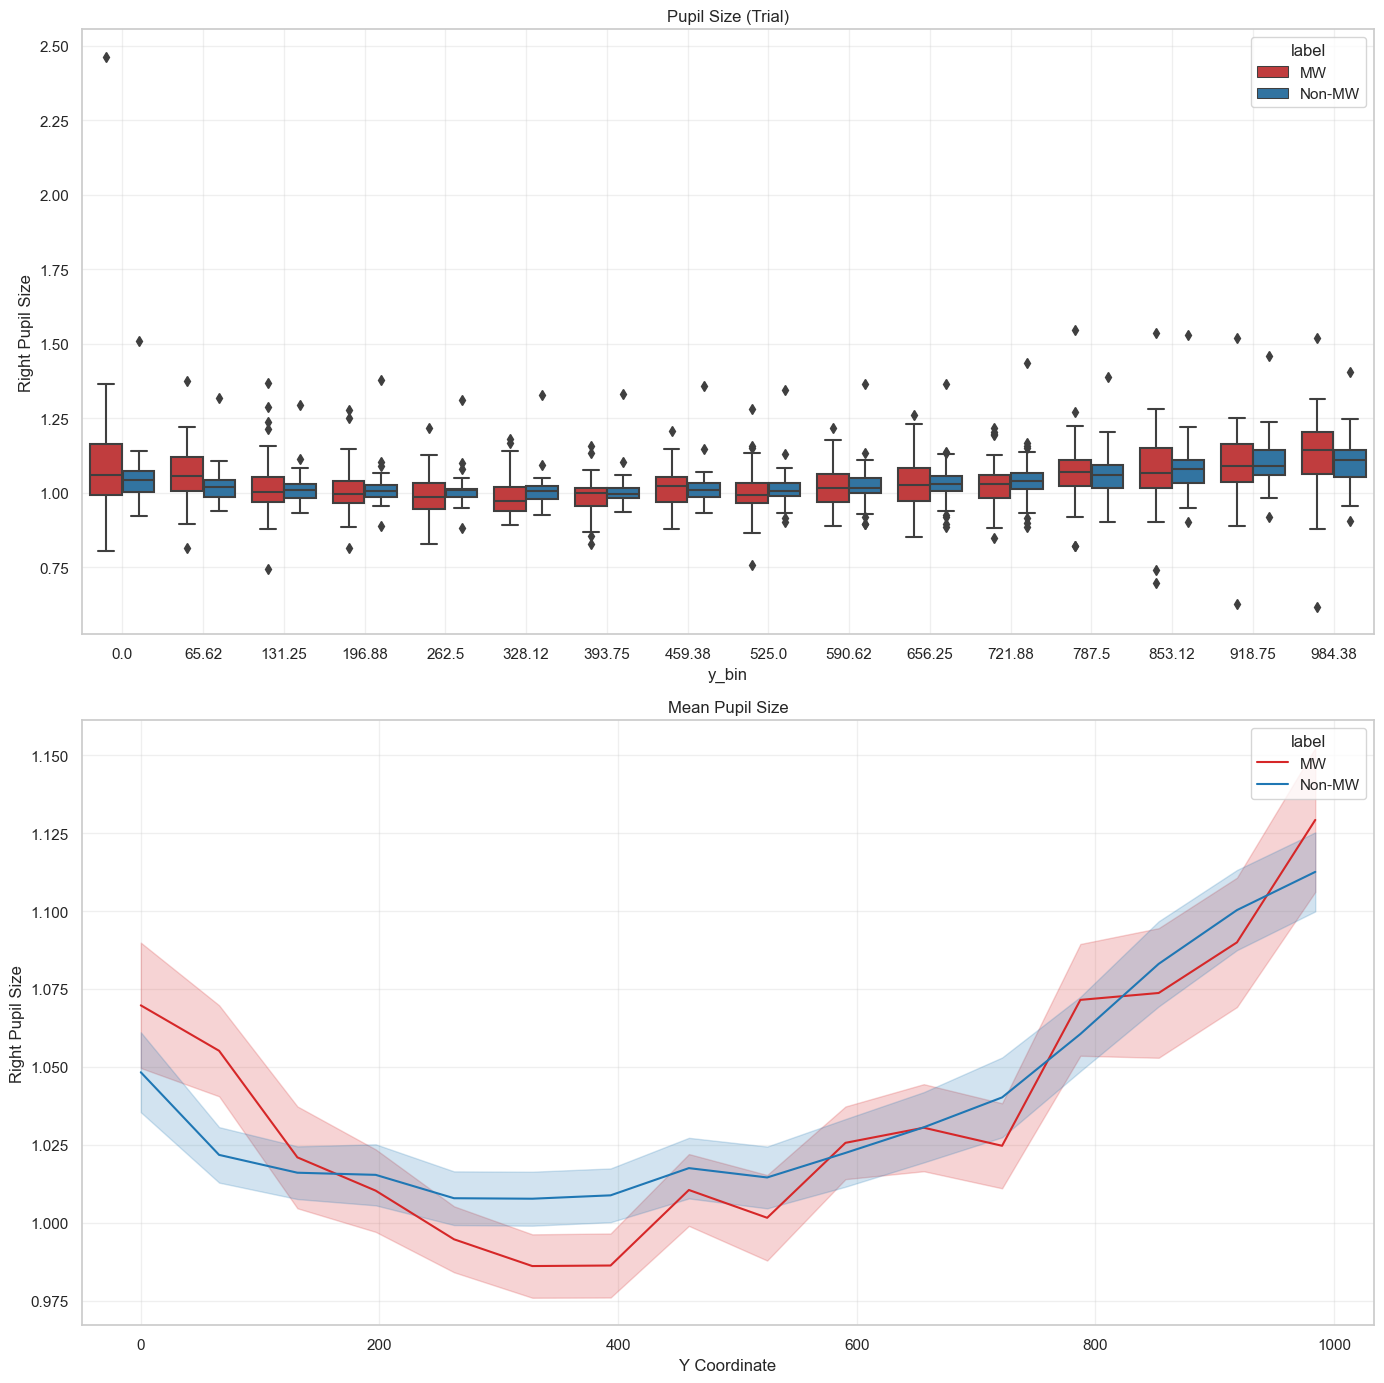

In [96]:
from matplotlib import pyplot as pyplot
import seaborn as sns
import os
import pandas as pd
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
df_all = pd.read_csv(os.path.join(path, 'pupil_size_on_page_y.csv'))
fig, axs = plt.subplots(2, 1, figsize=(14, 14))
palette = {'MW': 'tab:red', 'Non-MW': 'tab:blue'}
# Scatterplot
sns.boxplot(
    data=df_all, x='y_bin', y='RPupil', hue='label',
    palette=palette, ax=axs[0]
)
axs[0].set_ylabel("Right Pupil Size")
axs[0].set_title("Pupil Size (Trial)")
axs[0].grid(True, alpha=0.3)

# Lineplot with SE bands
df_all = df_all[df_all['RPupil'] <= 1.75]
sns.lineplot(
    data=df_all, x='y_bin', y='RPupil', hue='label',
    errorbar='se', ax=axs[1], palette=palette,
)
axs[1].set_xlabel("Y Coordinate")
axs[1].set_ylabel("Right Pupil Size")
axs[1].set_title("Mean Pupil Size")
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()